#Set up NeuralCoref for coreference detection(restart runtime after first cell)

In [1]:
!git clone https://github.com/huggingface/neuralcoref.git
%cd neuralcoref
!pip install -r requirements.txt
!pip install -e .
!python -m spacy download en_core_web_sm

Cloning into 'neuralcoref'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 772 (delta 10), reused 16 (delta 7), pack-reused 748
Receiving objects: 100% (772/772), 67.85 MiB | 26.30 MiB/s, done.
Resolving deltas: 100% (407/407), done.
Checking out files: 100% (151/151), done.
/content/neuralcoref
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 7.1 MB/s 
     |████████████████████████████████| 208 kB 15.1 MB/s 
     |████████████████████████████████| 1.0 MB 29.1 MB/s 
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.5
    Uninstalling srsly-2.4.5:
      Successfully uninstalled srsly-2.4.5
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting un

In [2]:
# Load your usual SpaCy model (one of SpaCy English models)
import spacy
import en_core_web_sm
spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()

# Add neural coref to SpaCy's pipe
import neuralcoref
neuralcoref.add_to_pipe(nlp)

# You're done. You can now use NeuralCoref as you usually manipulate a SpaCy document annotations.
doc = nlp(u'My sister has a dog. She loves him. The dog hated the cat.')

doc._.coref_clusters

100%|██████████| 40155833/40155833 [00:01<00:00, 26454715.40B/s]


[My sister: [My sister, She], a dog: [a dog, him, The dog]]

In [3]:
import json
import numpy as np

#Set up stanford corenlp

In [4]:
import os
os.environ["CORENLP_HOME"] = '/content/drive/MyDrive/stanford-corenlp-full-2018-10-05'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [7]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 7.4 MB/s 
     |████████████████████████████████| 240 kB 54.0 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=add5587ff25dd21ab80b01aa2ae780836853f6ba1acbe788ae5e70ebb05b5be6
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [8]:
import stanza
# Import client module
from stanza.server import CoreNLPClient

client = CoreNLPClient(timeout=150000000, be_quiet=True, annotators=['openie'], 
endpoint='http://localhost:9001')
client.start()
import time
time.sleep(10)

INFO:stanza:Writing properties to tmp file: corenlp_server-7f89dd8b434748b8.props
INFO:stanza:Starting server with command: java -Xmx5G -cp /content/drive/MyDrive/stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 150000000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7f89dd8b434748b8.props -annotators openie -preload -outputFormat serialized


In [9]:
def get_triples(sentence):
  text = sentence
  document = client.annotate(text, output_format='json')
  triples = []
  for sentence in document['sentences']:
      for triple in sentence['openie']:
          triples.append({
            'subject': triple['subject'],
            'relation': triple['relation'],
              'object': triple['object']
          })
  return triples
get_triples("John was at John's home.")

[{'subject': 'John', 'relation': 'was at', 'object': "John 's home"},
 {'subject': 'John', 'relation': 'at', 'object': 'home'}]

In [10]:
client.stop()

#Set up spacy

In [11]:
# def spacy_np(text):
#   doc = nlp(text)
#   n_chunks = []
#   for _np in doc.noun_chunks:
#     n_chunks.append(_np.text)
#   return n_chunks

# spacy_np(u'The cat and the dog sleep in the basket near the door.')

def spacy_np(text):
  doc = nlp(text)
  # Variable for entities with no coreferences
  non_coref = 0
  # Variables for entities with corferences
  corefs = 0
  # Array for all noun phrases
  n_chunks = []
  # Array for all coreferences
  refs = []
  # Final array of unique entities 
  unique_entities = []

  # Grab all noun phrases
  for _np in doc.noun_chunks:
    n_chunks.append(_np.text)

  # Get all coreferences
  if doc._.has_coref:
    corefs = len(doc._.coref_clusters)
    for ref in doc._.coref_clusters:
      refs += ref
      unique_entities.append(ref[0])
  
  # Refs are in span objects, unwrap them so they can be used as strings
  refs_string = []
  for ref in refs:
    refs_string.append(ref.text)

  # Cross reference the noun phrases with the coreferences
  for chunk in n_chunks:
    if chunk not in refs_string:
      unique_entities.append(chunk)

  return unique_entities
  


unique_entities = spacy_np('My sister has a dog. She loves him. The dog hates the cat. The cat ate the fish.')
print(unique_entities)
print(len(unique_entities))

[My sister, a dog, the cat, 'the fish']
4


#Baselines

In [12]:
summary_expanded_wo_why_fixed_location = """John walked to get to store.<\\s> John buys a uniform from a shop.<\\s> John took a bus to get to school.<\\s> John did karate in high school at school<\\s> John went to get to store.<\\s> John buys a wrestling uniform at a store.<\\s> John took a bus to get to laundry.<\\s> John washed the wrestling uniform at laundry<\\s>John wrestled to get to wrestling.<\\s> John became a pro wrestler at wrestling
John walked to get to kitchen.<\\s> John washed dishes with sponge at kitchen<\\s> John washed the smelly dishes in the kitchen at kitchen
 John drove to get to office.<\\s> John working at the office until 3 am.
John walked home to get to home.<\\s> John gets scissors from the drawer.<\\s>John walked to get to barber.<\\s> John trimmed his hair at barber
John walked to get to zoo.<\\s> John entered the zoo at zoo
John walked to get to pet shop.<\\s> John bought a new cat at pet shop
 John drove to get to office.<\\s> John studies hard for the test at office<\\s> John received an A on the test at office<\\s> John became the director at office
John walked to get to office.<\\s> John has key from his superior.<\\s> John turned the key of the office of his superior at office<\\s> John will sneak into the office of his superior at office
 John took a taxi to get to pharmacy.<\\s> John buys sleeping pills from a pharmacy.<\\s> John took sleeping pills to sleep at pharmacy
 John took a bus to get to home.<\\s> John got dvr from internet tv shop.<\\s> John watched the tv show on the dvr at home
John walked to get to cinema.<\\s> John buys a costume from a costume shop.<\\s> John met a girl on Halloween at cinema.<\\s> John dress up as a ghost on Halloween at cinema
John walked to get to bookstore.<\\s> John buys many books from a bookstore.<\\s> John gets many exam books from a bookstore.<\\s> John took a bus to get to university.<\\s> John took a lot of exams this semester at university
 John used the stairs to get to kitchen.<\\s> John gets a knife from the kitchen drawer.<\\s> John cut the cable with a knife at kitchen
John walked to get to street.<\\s> John found a penny on the street at street
John walked to get to river.<\\s> John crossed a flash flood in a narrow path at river
 John walked to get to hair dye.<\\s> John gets hair dye at the hair dye.<\\s> John drove to get to hair salon.<\\s> John dye his hair in a silly wig at hair salon
 John took a taxi to get to concert.<\\s> John played the piano in a musical disappointment at concert
 John took a train to get to park.<\\s> John took a hike to the park at park
John went to get to trophy cabinet.<\\s> John gets the trophy from the trophy cabinet.<\\s> John drove to get to ceremony.<\\s> John cleaned the trophy at the ceremony.<\\s> John gets the award from the ceremony.<\\s> John won the award at ceremony
John walked to get to amusement park.<\\s> John rode the roller coaster in the amusement park at amusement park
John walked home to get to home.<\\s> John bought a fire extinguisher at home<\\s> John put out the fire in his house at home
 John took a bus to get to home.<\\s> John buys a uniform from a uniform shop.<\\s>John walked to get to scout.<\\s> John gets a scout uniform from a scout.<\\s> John rode as a scout at scout
 John took a car to get to party.<\\s> John invited his friend to party at party
John took the dogs to get to vet.<\\s> John take care of old dogs at vet
John walked to get to kitchen.<\\s> John gets sunscreen from the cabinet.<\\s>John walked to get to garden.<\\s> John applied sunscreen to his hands at garden
John was taken to get to hospital.<\\s> John help one guy in surgery at hospital
 John took a taxi to get to office.<\\s> John negotiated to improve his job prospects at office
 John took a taxi to get to home.<\\s> John turned off the cable at the television.
John walked to get to square.<\\s> John likes his girlfriend at square<\\s> John danced with his girlfriend in the square at square
 John took a bus to get to pharmacy.<\\s> John buys the medicine from the pharmacy.<\\s>John was taken to get to hospital.<\\s> John suffer an asthma attack at hospital
John walked to get to supermarket.<\\s> John buys a umbrella from the supermarket.<\\s>John was taken to get to hospital.<\\s> John got sick because of the cold rain at hospital
 John took a bus to get to home.<\\s> John gets pen from his drawer.<\\s>John walked to get to writing desk.<\\s> John sharpened the pen at writing desk<\\s> John went to get to home.<\\s> John write back to his best friend at home
John walked to get to grocery.<\\s> John eat some rice in a shop at grocery
 John took a bus to get to supermarket.<\\s> John bought chocolate candy in the supermarket at supermarket<\\s>John walked to get to park.<\\s> John melted the chocolate candy at park<\\s> John sucked chocolate candy in the park at park
John jumped into the pool to get to pool.<\\s> John buys a swimming costume from a shop.<\\s> John frozen by ice cold water at pool
 John took a bus to get to bank.<\\s> John put the money in a bank at bank<\\s> John took a bus to get to home.<\\s> John gets a mop from the closet.<\\s> John mopped the floor of the dirty room at home
John walked to get to shoe store.<\\s> John bought new shoes at the store.
John went to get to internet.<\\s> John gets internet connection from the internet provider.<\\s> John searched a wife in internet at internet.<\\s>John walked to get to home.<\\s> John got wedding ring from his wife.<\\s> John married his wife at home<\\s> John went to get to internet.<\\s> John found a wife in the internet at internet
John took a lift to get to nursery.<\\s> John met the tiniest baby at nursery
 John took a taxi to get to bank.<\\s> John converted the money to dollars at the bank.<\\s> John took a bus to get to cinema.<\\s> John buys a ticket from ticket office.<\\s> John met a ghost in a horror movie at cinema
John walked to get to kitchen.<\\s> John gets a knife from the kitchen.<\\s> John learned how to cook salsas at kitchen
 John walked to get to newspaper.<\\s> John buys a newspaper from a newspaper stand.<\\s> John read about the presidential elections in a newspaper at newspaper
 John walked to get to fishing net.<\\s> John gets a net from the fishing net.<\\s>John walked to get to forest.<\\s> John caught a creature on the way at forest
 John took a bus to get to store.<\\s> John buys a stroller from a store.<\\s>John walked to get to park.<\\s> John push a stroller with a baby at park
John repaired his car at a garage.<\\s> John drove to get to garage.<\\s> John towed an empty car to the garage at garage
 John took a bus to get to home.<\\s> John get a life jacket from a shelf.<\\s> John gets swimming suit from the locker.<\\s> John swam to get to ocean.<\\s> John survived a ocean storm at ocean
 John took a bus to get to school.<\\s> John taught the ten classes at school
 John took a bus to get to work.<\\s> John got girlfriend from work.<\\s> John took a bus to get to school.<\\s> John fell in love with the teacher at school
 John drove to get to car.<\\s> John pulled back in fear at car
John walked home to get to home.<\\s> John got a new television at home
John walked to get to computer store.<\\s> John buys a computer from the computer store.<\\s> John used a computer to get to internet.<\\s> John surfed the internet at internet
 John drove to get to car.<\\s> John drove home with the car at car
 John walked to get to bookstore.<\\s> John buys bird book at the bookstore.<\\s> John took a bus to get to park.<\\s> John find lost bird in the park at park
John took a bus to get to bank.<\\s> John put the money in the bank at bank<\\s> John took a bus to get to home.<\\s> John gets pen and paper from the office.<\\s> John took a bus to get to newspaper.<\\s> John wrote an article about the school at newspaper
John walked to get to office.<\\s> John gets meeting pass from the counter.<\\s> John attended the staff meeting at office
John walked to get to classroom.<\\s> John gets class party invitation from teacher.<\\s> John took a bus to get to school.<\\s> John invited the classmates at the class party.
 John drove to get to cafe.<\\s> John drink six can of soda at cafe
 John drove to get to supermarket.<\\s> John caught the hungry a casey at supermarket
 John drove to get to shop.<\\s> John buy the new computer at shop
 John took a bus to get to school.<\\s> John did senior pranks at school
John climbed to get to garden.<\\s> John saved the kittens from the rain.
John walked to get to police station.<\\s> John reported stolen gifts to the police at police station
John walked to get to bank.<\\s> John deposits the money in a bank at bank<\\s>John unlocked the music shop.<\\s> John walked to get to music shop.<\\s> John gets banjo from the store.<\\s> John bought a banjo to play at music shop
John walked to get to ferry.<\\s> John sailed with the a ferry from the shore.
John was taken to get to hospital.<\\s> John got heart pain at hospital.<\\s> John experienced a heart pain at hospital
 John took a taxi to get to home.<\\s> John gets a gun from the drawer.<\\s> John loaded the gun at home<\\s> John protected his mother from an evil man.
John climbed the bed to get to bedroom.<\\s> John check out the bugs in the bed at bedroom
 John drove to get to light shop.<\\s> John bought car light from the light shop.<\\s> John took the car to get to car.<\\s> John changed the airbag light of his car at car
John ran to get to playground.<\\s> John played a game at playground
 John drove to get to apartment.<\\s> John fights the neighbors of his apartment at apartment
 John took a bus to get to home.<\\s> John designed a good party program at home
 John took a taxi to get to home.<\\s> John realized the pain he caused lisa at home
John walked to get to school.<\\s> John could never concentrate at school.
John ran to get to forest.<\\s> John fought off the squirrels at forest
John climbed up the ladder to get to attic.<\\s> John takes a ladder from attic.<\\s> John took a ladder to get to tower.<\\s> John climb the tower at tower
 John drove to get to pizza.<\\s> John had a pizza at pizza
 John stood in line to get to queue.<\\s> John waits patiently at queue<\\s> John waited his turn at queue
 John took a car to get to office.<\\s> John argue with his boss in the boardroom at office
John get glasses from the optician.<\\s> John walked to get to optician.<\\s> John buy new glasses at optician
John walked home to get to home.<\\s> John gets mosquito net from the wardrobe.<\\s>John walked to get to forest.<\\s> John killed the mosquitos at forest
 John drove to get to traffic.<\\s> John drives in traffic at traffic<\\s> John drove to get to driving test.<\\s> John took a driving test at driving test
 John took a bus to get to library.<\\s> John buys book from library.<\\s> John gets library card from the library.<\\s> John checked out the book from the library.<\\s> John solved an over complicated problem at library
Glenn walked home to get to home.<\\s> John took a car to get to home.<\\s> John come out of the house with glenn at home
 John walked to get to supermarket.<\\s> John buys skipping rope at supermarket.<\\s>John took a walk to get to playground.<\\s> John wound the skipping rope on the playground at playground<\\s> John played skipping rope at playground
 John drove to get to restaurant.<\\s> John ordered the service of his jack at restaurant
 John drove to get to park.<\\s> John kicked pugsy in the stomach at park
 John drove to get to supermarket.<\\s> John lead a team building at the new supermarket.
 John walked to get to post office.<\\s> John opened the amusing mail of his friend at post office
John walked to get to cinema.<\\s> John buys a cinema ticket from the cinema.<\\s> John enjoyed the reason at cinema
John walked to get to store.<\\s> John bought a TV from a store.<\\s> John took a bus to get to home.<\\s> John turned on the TV at home<\\s> John discovered a void in the TV at home
John went to get to social media.<\\s> John creates Facebook account at social media<\\s> John filled up the social media information at social media
 John took a bus to get to cinema.<\\s> John saw movie in the cinema at cinema
 John took a bus to get to cinema.<\\s> John bought a ticket in the right currency at cinema<\\s> John buys a ticket from cinema ticket office.<\\s> John watched the popstar concert at cinema
 John drove to get to office.<\\s> John sat and slow work in the office at office
John walked to get to cafe.<\\s> John buys sugar at the cafe.<\\s> John earns money at cafe<\\s> John filled the sugar bowl with more sugar at cafe<\\s> John added more sugar to his coffee at cafe
John walked to get to store.<\\s> John exchanged money at the store.<\\s>John walked to get to skating rink.<\\s> John buys skates from the store.<\\s> John skateboard on the ice at skating rink
 John walked to get to bank.<\\s> John took the bus to the bank to get the money at bank<\\s> John took a bus to get to park.<\\s> John plays football at park.<\\s>Julie walked to get to park.<\\s>Pat walked to get to park.<\\s> John played football with Julie and Pat at park
 John took a taxi to get to home.<\\s> John picks up the telephone in the hallway at home<\\s> John used the telephone to get to telephone.<\\s> John called someone using the telephone at telephone
John walked home to get to home.<\\s> John gets a key from the key chain.<\\s> John unlocks the house with the house key at home<\\s> John set off the alarm at home
John walked to get to garden.<\\s> John pets dog next door at the garden.<\\s> John played with the dog next door at garden""".split("\n")

In [13]:
summary_expanded_w_why_fixed_location = """John walked to get to supermarket.<\\s> John buys a gym bag from supermarket.<\\s> John took a taxi to get to taxi.<\\s> John paid the taxi driver at taxi<\\s> John took a taxi to get to gym.<\\s> John beat up the pro wrestler at gym
John walked to get to kitchen.<\\s> John gets dish cloth from dish rack.<\\s> John washed dirty dishes at kitchen
 John took a bus to get to home.<\\s> John he's completely finished with the work at home<\\s> John he's done with the work at home<\\s> John finish the work in the morning at home
 John took a bus to get to home.<\\s> John get scissors from the drawer.<\\s>John walked to get to kitchen.<\\s> John he cut his wife's hair at kitchen<\\s> John sharpened the scissors on the kitchen counter at kitchen<\\s> John drove to get to barber.<\\s> John cut the hair of his wife at barber
 John took a bus to get to zoo.<\\s> John buys a ticket from the ticket office.<\\s> John visited the zoo at zoo
 John drove to get to pet shop.<\\s> John buys a cat from a pet shop.<\\s> John adopted a new cat at pet shop
 John drove to get to cinema.<\\s> John buys a movie ticket from ticket office.<\\s> John directed the movie at cinema
 John took a bus to get to park.<\\s> John met some homeless people in the park at park
John failed to complete his work.<\\s>John got a cell phone from his company.<\\s>John charged his cell phone in the office.<\\s>John walked to get to office.<\\s> John his boss called him in the office at office<\\s> John took a taxi to get to home.<\\s> John got bad day at from his boss.<\\s> John took a taxi to get to pharmacy.<\\s> John he had a bad day at work.<\\s> John buys sleeping pills from the pharmacy.<\\s> John took sleeping pills to help him to sleep at pharmacy
John walked to get to supermarket.<\\s> John buys dvr from the supermarket.<\\s> John drove home to get to home.<\\s> John watched dvr at home
 John took a taxi to get to party.<\\s> John bought a costume from a costume shop.<\\s> John walked to get to party store.<\\s> John exchanged the money for the dress at party store<\\s> John buys party dress from the party store.<\\s> John met his friends at party.<\\s> John visited the Halloween party with his friends at party
 John took a bus to get to school.<\\s> John doesn't study at school<\\s>John had fallen down in the park.<\\s> John was taken to get to hospital.<\\s> John went to the hospital at hospital<\\s> John went to get to school.<\\s> John cheated in the exam at school<\\s> John got into F- in english class at school
John walked to get to kitchen.<\\s> John gets a knife from the drawer.<\\s> John took a taxi to get to home.<\\s> John cut cable in the television at home
 John took a bus to get to shop.<\\s> John gave the lucky penny to charlie at shop
John waded to get to river.<\\s> John survive flash flood at river
John drove to get to hair salon.<\\s> John buys a wig from the wig shop.<\\s> John had a silly wig on at hair salon
 John drove to get to concert.<\\s> John play the violin very badly in the concert at concert
John walked to get to forest.<\\s> John buy hiking boots from the store.<\\s> John hike with the friends at forest
John he won an award there.<\\s> John took a taxi to get to museum.<\\s> John buys a ticket from the ticket office.<\\s> John he went to see a museum at museum<\\s> John wins an award at museum.<\\s> John won an award in a prestigious competition at museum
 John took a bus to get to cinema.<\\s> John buys a ticket from cinema ticket office.<\\s> John watched amusement horror movie at cinema
John he got pain from taking the drug.<\\s>John got illegal drug from hospital doctor.<\\s>John was taken to get to hospital.<\\s> John he took an illegal drug at hospital<\\s> John he had a car accident at hospital<\\s>John walked home to get to home.<\\s> John had a bad day at work.<\\s> John fell off a house in the fire at home
John walked to get to forest.<\\s> John explore a strange tree house at forest
John walked to get to forest.<\\s> John hold the party in a forest at forest
John walked to get to park.<\\s> John played with his pet dog in the park at park
 John drove home to get to home.<\\s> John gets sunscreen from the drawer.<\\s> John walked to get to face.<\\s> John applied the sunscreen on his face at face<\\s>John walked to get to beach.<\\s> John protect from the sun with sunscreen.
 John took a taxi to get to hospital.<\\s> John helped a patient in the hospital at hospital
 John borrowed money from the bank to get to bank.<\\s> John invested the money at bank<\\s> John raised the business from a brink of bankruptcy.
 John took a taxi to get to home.<\\s> John buys cable from the cable company.<\\s> John troubles with his cable at home
 John took a bus to get to Starbucks.<\\s> John meet the girl he love at Starbucks.
John he had an asthma attack.<\\s> John was taken to get to hospital.<\\s> John he didn't bring the necessary medication at hospital<\\s> John gets an inhaler from his prescription.<\\s> John had an asthma attack at hospital
John he had to get treatment.<\\s>John took a taxi to get to hospital.<\\s> John he had to go to the hospital at hospital<\\s>John took a bus to get to home.<\\s> John gets thermometer from medicine cabinet.<\\s>John walked to get to bathroom.<\\s> John took the thermometer from the bathroom.<\\s>John walked to get to bus station.<\\s> John bought bus tickets at bus station<\\s> John took a bus to get to office.<\\s> John he got a fever at office<\\s> John he got a fever in the office at office<\\s> John had to give up in the rain at office
 John drove to get to wedding.<\\s> John spends the wedding dress at wedding shop.<\\s> John saved the dates for the wedding at wedding
 John took a bus to get to school.<\\s> John gave rice to his students at school
 John took a bus to get to supermarket.<\\s> John bought the fruits at supermarket
 John took a bus to get to kitchen.<\\s> John numbed his hands at kitchen
John walked to get to store.<\\s> John buys a vacuum cleaner from the store.<\\s> John took a bus to get to home.<\\s> John cleaned the dirty room with a vacuum cleaner at home<\\s> John cleaned the dirty room in his house at home
John walked home to get to home.<\\s> John his mom went to work at home<\\s> John didn't have a job at home<\\s>John walked to get to shoe shop.<\\s> John he liked the shoes at shoe shop<\\s> John bought new shoes at shoe shop
 John took a bus to get to supermarket.<\\s>Jane walked to get to supermarket.<\\s> John meet Jane in the supermarket at supermarket
John walked to get to hospital.<\\s> John saw the tiniest babies at hospital
 John took a bus to get to cinema.<\\s> John buys scary movie ticket from ticket office.<\\s> John saw a scary movie at cinema
John walked to get to home.<\\s> John buys a blender from the supermarket.<\\s> John took a bus to get to kitchen.<\\s> John cleaned the blender at kitchen<\\s> John made a lot of salsa at kitchen
John walked to get to train station.<\\s> John buys a train ticket from train station.<\\s> John took a train to get to newspaper.<\\s> John read the newspaper at newspaper
 John took a bus to get to zoo.<\\s> John purchased the cage at zoo<\\s> John grabbed a creature at zoo
John was taken to get to hospital.<\\s> John has a baby by natural childbirth at hospital<\\s> John gave birth to his child at hospital
 John drove his car to get to garage.<\\s> John towed his car to the garage at garage
John put the money in the bank account.<\\s>John walked to get to supermarket.<\\s> John buys swimming costume from the supermarket.<\\s> John swam to get to pool.<\\s> John gets swimming pool from pool shed.<\\s> John his father taught him to swim at pool<\\s> John buys swimming trunks from swimming pool.<\\s> John can swim at pool<\\s>John took a bus to get to boat yard.<\\s> John gets a boat from the boat yard.<\\s> John swam to get to boat.<\\s> John survived the the ocean storm in the boat at boat
John walked to get to garden.<\\s> John he planted some roses at garden<\\s> John bought bias from the garden.<\\s> John used a bias and got a favorable result at garden
John he had a bad day.<\\s> John took a taxi to get to home.<\\s> John his girlfriend lied to him at home<\\s> John broke up with his girlfriend at home
John his friend got shot at the grocery.<\\s>John gets grocery list from a pen.<\\s> John drove to get to grocery.<\\s> John didn't know what to do at grocery<\\s> John he had a draft notice at grocery<\\s> John was drafted to get to war.<\\s> John didn't participate in the war at war
 John drove to get to shop.<\\s> John bought a new television at shop
 John took a train to get to home.<\\s> John connects internet to network cable at home<\\s> John used the internet to get to internet.<\\s> John bought lot of computer game to the internet at internet
John filled the car with gas on the way to the garage.<\\s> John drove to get to garage.<\\s> John took home his brown car for a treat at garage
John walked to get to park.<\\s> John buys bird watching lens from shop.<\\s> John loves to watch birds at park<\\s> John took a taxi to get to bank.<\\s> John exchanged the money at the bank.<\\s> John went to get to park.<\\s> John bought a bird from the pet shop.<\\s> John found a lost bird in the park at park
 John took a bus to get to school.<\\s> John buys a pen and paper from school.<\\s> John wrote a school paper at school
John walked to get to office.<\\s> John attends a staff meeting at the office.<\\s> John attended a staff meeting at office
 John took a bus to get to school.<\\s> John hires party at school<\\s> John hold a party in the class at school
John walked to get to shop.<\\s> John buys food at shop.<\\s> John managed to consume two more glasses of water at shop
 John drove to get to police station.<\\s> John takes delivery case from the delivery van.<\\s> John delivered the case to the police at police station
John walked to get to computer shop.<\\s> John bought a new computer at computer shop
 John took a taxi to get to school.<\\s> John played a prank on his student at school
John walked to get to shop.<\\s> John used his money to buy stuff at shop
John he got a phone call.<\\s> John took a taxi to get to home.<\\s> John gets a phone from the table.<\\s> Chris took a taxi to get to home.<\\s> John he had a call from Chris.<\\s> John went to get to department store.<\\s> John search for the stolen gifts at department store
 John walked to get to store.<\\s> John buys a banjo from a store.<\\s>John walked home to get to home.<\\s> John played a song on his banjo at home
 John drove to get to traffic jam.<\\s> John drive safely through the traffic jam at traffic jam
John his patient has heart pain.<\\s> John was taken to get to hospital.<\\s> John got stethoscope from medical kit.<\\s> John diagnosed heart pain in his patient at hospital
John walked to get to nursery.<\\s> John got baby from mother.<\\s> John pat the baby in the mother at nursery
John took a walk to get to bedroom.<\\s> John caught bugs in his bed at bedroom
John gets the car keys from the car.<\\s> John drove to get to car.<\\s> John fixes car light by car light at car<\\s> John check the airbag light in his car at car
 John drove to get to park.<\\s> John played a game with friends at park
John walked to get to sword shop.<\\s> John buys a sword from a sword shop.<\\s> John drove to get to park.<\\s> John beat his neighbor in a duel at park
 John took a bus to get to home.<\\s> John makes party plan at home<\\s> John and his friends plan a party at home
Liseh walked to get to store.<\\s> Liseh gets a phone from a store.<\\s> John took a bus to get to office.<\\s> Liseh took a bus to get to home.<\\s> Liseh gets help from John.
John loaded the money on the bus.<\\s> John took a bus to get to cinema.<\\s> John never met his dream girl at cinema
 John took a bus to get to garden.<\\s> John got bitten by a squirrel in his garden at garden
John climbed down the ladder to get to home.<\\s> John gets ladder from the closet.<\\s> John took a ladder to get to tower.<\\s> John climb to the top of the tower at tower
 John took a bus to get to restaurant.<\\s> John ate some pizza for breakfast at restaurant
 John took a bus to get to school.<\\s> John asked for pencil from teacher.<\\s> John asked when he could have the next turn at school
John get business card from the card board.<\\s>John walked to get to board room.<\\s> John he has to discuss about important business at board room<\\s>John has booking from hotel service.<\\s>John took a taxi to get to hotel.<\\s> John has meeting room booked from hotel service.<\\s> John went to get to board room.<\\s> John has to have the meeting at board room<\\s> John took a taxi to get to office.<\\s> John had a meeting with the boss at office<\\s> John went to get to board room.<\\s> John gets appointment letter from secretary.<\\s> John get board room by appointment at board room<\\s>John walked to get to cleaning closet.<\\s> John gets cleaning cloth from the cleaning closet.<\\s> John went to get to board room.<\\s> John cleaned the board room at board room<\\s> John discuss the important matter in the board room at board room
John he lost his glasses.<\\s> John went to get to optician.<\\s> John his old glasses broke at optician<\\s> John bought the new glasses at optician
 John drove to get to office.<\\s> John he has to work late at office<\\s> John he has to work overtime at office<\\s> John has to work late at office<\\s>John walked home to get to home.<\\s> John cannot get a mosquito net at home<\\s> John mosquitos chased him at night.<\\s> John gets mosquito net from the basket.<\\s>John ran to get to forest.<\\s> John escaped from the mosquitos.
 John drove to get to car.<\\s> John drove his car at car
John walked to get to beach.<\\s> John saw the sunset and the rainbow at beach
John drove home to get to home.<\\s> John pulled the son out of the fire at home
John walked to get to playground.<\\s> John skipped rope for a long time at playground
 John drove to get to garage.<\\s>Jack garage wasn't in his neighborhood.<\\s> Jack took a cab to get to garage.<\\s> John gave jack a check at garage<\\s> John gave jack his car service at garage
John walked to get to kitchen.<\\s> John gets a kitchen knife from the kitchen.<\\s> John cooks food at kitchen<\\s>John walked home to get to home.<\\s> John he can feed the pugsy at home<\\s> John loved pets at home<\\s> John fed the pugsy at home
 John drove to get to team building.<\\s> John bought a ticket for team building event at team building<\\s> John participate in team building at team building
 John drove to get to post office.<\\s> John didn't feel good about it at post office<\\s> John he it didn't like the post at post office<\\s> John it made him feel good and enjoy at post office<\\s> John enjoyed with the post of amusing mail at post office
John got flu shot from nurse.<\\s> John took a taxi to get to hospital.<\\s> John's she has the flu at hospital<\\s> John John's girlfriend don't feel well.<\\s>John walked to get to library.<\\s> John lost his girlfriend at library<\\s> John bought a book from the library.<\\s> John searched for the reason of his broken heart at library
John walked to get to cinema.<\\s> John he didn't like the film at cinema<\\s> John watched nothing at cinema
John walked to get to social media.<\\s> John posted rude comments about his friend at social media<\\s> John had too much trouble in social media at social media
John walked to get to cinema.<\\s> John buys a movie ticket from ticket office.<\\s> John watched the movie at cinema
John walked to get to ticket office.<\\s> John puts the money in the ticket at ticket office<\\s>John walked to get to cinema.<\\s> John buys a ticket from the ticket office.<\\s> John walked to get to concert.<\\s> John became bored at the concert.
John his colleagues didn't like him.<\\s> John rode a taxi to get to taxi.<\\s> John counted the money in a taxi at taxi<\\s> John took a taxi to get to office.<\\s> John didn't get any raise at office<\\s> John doesn't like his colleagues at office<\\s> John ordered and finished the slow work day at office
 John took a bus to get to kitchen.<\\s> John gets a spoon from the kitchen.<\\s> John swallow the sugar at kitchen
John walked to get to store.<\\s> John buys skates from the store.<\\s>John walked to get to kitchen.<\\s> John sharpened his skates at the kitchen.<\\s>John walked to get to lake.<\\s> John ice skated on the frozen lake at lake
 John took a taxi to get to party.<\\s> Julie drove to get to party.<\\s> John and Julie met at a party.
John walked to get to phone booth.<\\s> John buys a phone from the phone booth.<\\s> John took a taxi to get to home.<\\s> John used the phone to call his friend at home
John his smoke alarm went off.<\\s> John took a car to get to home.<\\s> John he feared for his life at home<\\s> John fled the smoke alarm at home
John walked to get to near the river.<\\s> John had never had a pet at near the river<\\s>John walked to get to neighbour.<\\s> John bought a puppy from the next door neighbour.""".split("\n")

In [14]:
summary_expanded = """John walked to get to store.<\\s> John buys a uniform from a shop.<\\s> John took a bus to get to school.<\\s> John did karate in high school at school<\\s> John buys a wrestling uniform at a store.<\\s> John took a bus to get to laundry.<\\s> John washed the wrestling uniform at laundry<\\s>John wrestled to get to wrestling.<\\s> John became a pro wrestler at wrestling
John walked to get to kitchen.<\\s> John washed dishes with sponge at kitchen<\\s> John washed the smelly dishes in the kitchen at kitchen
 John drove to get to office.<\\s> John working at the office until 3 am.
John walked home to get to home.<\\s> John gets scissors from the drawer.<\\s>John walked to get to barber.<\\s> John trimmed his hair at barber
John walked to get to zoo.<\\s> John entered the zoo at zoo
John walked to get to pet shop.<\\s> John bought a new cat at pet shop
 John drove to get to office.<\\s> John studies hard for the test at office<\\s> John received an A on the test at office<\\s> John became the director at office
John walked to get to office.<\\s> John has key from his superior.<\\s> John turned the key of the office of his superior at office<\\s> John will sneak into the office of his superior at office
 John took a taxi to get to pharmacy.<\\s> John buys sleeping pills from a pharmacy.<\\s> John took sleeping pills to sleep at pharmacy
 John took a bus to get to home.<\\s> John got dvr from internet tv shop.<\\s> John watched the tv show on the dvr at home
John walked to get to cinema.<\\s> John buys a costume from a costume shop.<\\s> John met a girl on Halloween at cinema.<\\s> John dress up as a ghost on Halloween at cinema
John walked to get to bookstore.<\\s> John buys many books from a bookstore.<\\s> John gets many exam books from a bookstore.<\\s> John took a bus to get to university.<\\s> John took a lot of exams this semester at university
 John used the stairs to get to kitchen.<\\s> John gets a knife from the kitchen drawer.<\\s> John cut the cable with a knife at kitchen
John walked to get to street.<\\s> John found a penny on the street at street
John walked to get to river.<\\s> John crossed a flash flood in a narrow path at river
 John walked to get to hair dye.<\\s> John gets hair dye at the hair dye.<\\s> John drove to get to hair salon.<\\s> John dye his hair in a silly wig at hair salon
 John took a taxi to get to concert.<\\s> John played the piano in a musical disappointment at concert
 John took a train to get to park.<\\s> John took a hike to the park at park
John went to get to trophy cabinet.<\\s> John gets the trophy from the trophy cabinet.<\\s> John drove to get to ceremony.<\\s> John cleaned the trophy at the ceremony.<\\s> John gets the award from the ceremony.<\\s> John won the award at ceremony
John walked to get to amusement park.<\\s> John rode the roller coaster in the amusement park at amusement park
John walked home to get to home.<\\s> John bought a fire extinguisher at home<\\s> John put out the fire in his house at home
 John took a bus to get to home.<\\s> John buys a uniform from a uniform shop.<\\s>John walked to get to scout.<\\s> John gets a scout uniform from a scout.<\\s> John rode as a scout at scout
 John took a car to get to party.<\\s> John invited his friend to party at party
John took the dogs to get to vet.<\\s> John take care of old dogs at vet
John walked to get to kitchen.<\\s> John gets sunscreen from the cabinet.<\\s>John walked to get to garden.<\\s> John applied sunscreen to his hands at garden
John was taken to get to hospital.<\\s> John help one guy in surgery at hospital
 John took a taxi to get to office.<\\s> John negotiated to improve his job prospects at office
 John took a taxi to get to home.<\\s> John turned off the cable at the television.
John walked to get to square.<\\s> John likes his girlfriend at square<\\s> John danced with his girlfriend in the square at square
 John took a bus to get to pharmacy.<\\s> John buys the medicine from the pharmacy.<\\s>John was taken to get to hospital.<\\s> John suffer an asthma attack at hospital
John walked to get to supermarket.<\\s> John buys a umbrella from the supermarket.<\\s>John was taken to get to hospital.<\\s> John got sick because of the cold rain at hospital
 John took a bus to get to home.<\\s> John gets pen from his drawer.<\\s>John walked to get to writing desk.<\\s> John sharpened the pen at writing desk<\\s> John write back to his best friend at home
John walked to get to grocery.<\\s> John eat some rice in a shop at grocery
 John took a bus to get to supermarket.<\\s> John bought chocolate candy in the supermarket at supermarket<\\s>John walked to get to park.<\\s> John melted the chocolate candy at park<\\s> John sucked chocolate candy in the park at park
John jumped into the pool to get to pool.<\\s> John buys a swimming costume from a shop.<\\s> John frozen by ice cold water at pool
 John took a bus to get to bank.<\\s> John put the money in a bank at bank<\\s> John took a bus to get to home.<\\s> John gets a mop from the closet.<\\s> John mopped the floor of the dirty room at home
John walked to get to shoe store.<\\s> John bought new shoes at the store.
John went to get to internet.<\\s> John gets internet connection from the internet provider.<\\s> John searched a wife in internet at internet.<\\s>John walked to get to home.<\\s> John got wedding ring from his wife.<\\s> John married his wife at home<\\s> John found a wife in the internet at internet
John took a lift to get to nursery.<\\s> John met the tiniest baby at nursery
 John took a taxi to get to bank.<\\s> John converted the money to dollars at the bank.<\\s> John took a bus to get to cinema.<\\s> John buys a ticket from ticket office.<\\s> John met a ghost in a horror movie at cinema
John walked to get to kitchen.<\\s> John gets a knife from the kitchen.<\\s> John learned how to cook salsas at kitchen
 John walked to get to newspaper.<\\s> John buys a newspaper from a newspaper stand.<\\s> John read about the presidential elections in a newspaper at newspaper
 John walked to get to fishing net.<\\s> John gets a net from the fishing net.<\\s>John walked to get to forest.<\\s> John caught a creature on the way at forest
 John took a bus to get to store.<\\s> John buys a stroller from a store.<\\s>John walked to get to park.<\\s> John push a stroller with a baby at park
John repaired his car at a garage.<\\s> John drove to get to garage.<\\s> John towed an empty car to the garage at garage
 John took a bus to get to home.<\\s> John get a life jacket from a shelf.<\\s> John gets swimming suit from the locker.<\\s> John swam to get to ocean.<\\s> John survived a ocean storm at ocean
 John took a bus to get to school.<\\s> John taught the ten classes at school
 John took a bus to get to work.<\\s> John got girlfriend from work.<\\s> John took a bus to get to school.<\\s> John fell in love with the teacher at school
 John drove to get to car.<\\s> John pulled back in fear at car
John walked home to get to home.<\\s> John got a new television at home
John walked to get to computer store.<\\s> John buys a computer from the computer store.<\\s> John used a computer to get to internet.<\\s> John surfed the internet at internet
 John drove to get to car.<\\s> John drove home with the car at car
 John walked to get to bookstore.<\\s> John buys bird book at the bookstore.<\\s> John took a bus to get to park.<\\s> John find lost bird in the park at park
John took a bus to get to bank.<\\s> John put the money in the bank at bank<\\s> John took a bus to get to home.<\\s> John gets pen and paper from the office.<\\s> John took a bus to get to newspaper.<\\s> John wrote an article about the school at newspaper
John walked to get to office.<\\s> John gets meeting pass from the counter.<\\s> John attended the staff meeting at office
John walked to get to classroom.<\\s> John gets class party invitation from teacher.<\\s> John took a bus to get to school.<\\s> John invited the classmates at the class party.
 John drove to get to cafe.<\\s> John drink six can of soda at cafe
 John drove to get to supermarket.<\\s> John caught the hungry a casey at supermarket
 John drove to get to shop.<\\s> John buy the new computer at shop
 John took a bus to get to school.<\\s> John did senior pranks at school
John climbed to get to garden.<\\s> John saved the kittens from the rain.
John walked to get to police station.<\\s> John reported stolen gifts to the police at police station
John walked to get to bank.<\\s> John deposits the money in a bank at bank<\\s>John unlocked the music shop.<\\s> John walked to get to music shop.<\\s> John gets banjo from the store.<\\s> John bought a banjo to play at music shop
John walked to get to ferry.<\\s> John sailed with the a ferry from the shore.
John was taken to get to hospital.<\\s> John got heart pain at hospital.<\\s> John experienced a heart pain at hospital
 John took a taxi to get to home.<\\s> John gets a gun from the drawer.<\\s> John loaded the gun at home<\\s> John protected his mother from an evil man.
John climbed the bed to get to bedroom.<\\s> John check out the bugs in the bed at bedroom
 John drove to get to light shop.<\\s> John bought car light from the light shop.<\\s> John took the car to get to car.<\\s> John changed the airbag light of his car at car
John ran to get to playground.<\\s> John played a game at playground
 John drove to get to apartment.<\\s> John fights the neighbors of his apartment at apartment
 John took a bus to get to home.<\\s> John designed a good party program at home
 John took a taxi to get to home.<\\s> John realized the pain he caused lisa at home
John walked to get to school.<\\s> John could never concentrate at school.
John ran to get to forest.<\\s> John fought off the squirrels at forest
John climbed up the ladder to get to attic.<\\s> John takes a ladder from attic.<\\s> John took a ladder to get to tower.<\\s> John climb the tower at tower
 John drove to get to pizza.<\\s> John had a pizza at pizza
 John stood in line to get to queue.<\\s> John waits patiently at queue<\\s> John waited his turn at queue
 John took a car to get to office.<\\s> John argue with his boss in the boardroom at office
John get glasses from the optician.<\\s> John walked to get to optician.<\\s> John buy new glasses at optician
John walked home to get to home.<\\s> John gets mosquito net from the wardrobe.<\\s>John walked to get to forest.<\\s> John killed the mosquitos at forest
 John drove to get to traffic.<\\s> John drives in traffic at traffic<\\s> John drove to get to driving test.<\\s> John took a driving test at driving test
 John took a bus to get to library.<\\s> John buys book from library.<\\s> John gets library card from the library.<\\s> John checked out the book from the library.<\\s> John solved an over complicated problem at library
Glenn walked home to get to home.<\\s> John took a car to get to home.<\\s> John come out of the house with glenn at home
 John walked to get to supermarket.<\\s> John buys skipping rope at supermarket.<\\s>John took a walk to get to playground.<\\s> John wound the skipping rope on the playground at playground<\\s> John played skipping rope at playground
 John drove to get to restaurant.<\\s> John ordered the service of his jack at restaurant
 John drove to get to park.<\\s> John kicked pugsy in the stomach at park
 John drove to get to supermarket.<\\s> John lead a team building at the new supermarket.
 John walked to get to post office.<\\s> John opened the amusing mail of his friend at post office
John walked to get to cinema.<\\s> John buys a cinema ticket from the cinema.<\\s> John enjoyed the reason at cinema
John walked to get to store.<\\s> John bought a TV from a store.<\\s> John took a bus to get to home.<\\s> John turned on the TV at home<\\s> John discovered a void in the TV at home
John went to get to social media.<\\s> John creates Facebook account at social media<\\s> John filled up the social media information at social media
 John took a bus to get to cinema.<\\s> John saw movie in the cinema at cinema
 John took a bus to get to cinema.<\\s> John bought a ticket in the right currency at cinema<\\s> John buys a ticket from cinema ticket office.<\\s> John watched the popstar concert at cinema
 John drove to get to office.<\\s> John sat and slow work in the office at office
John walked to get to cafe.<\\s> John buys sugar at the cafe.<\\s> John earns money at cafe<\\s> John filled the sugar bowl with more sugar at cafe<\\s> John added more sugar to his coffee at cafe
John walked to get to store.<\\s> John exchanged money at the store.<\\s>John walked to get to skating rink.<\\s> John buys skates from the store.<\\s> John skateboard on the ice at skating rink
 John walked to get to bank.<\\s> John took the bus to the bank to get the money at bank<\\s> John took a bus to get to park.<\\s> John plays football at park.<\\s>Julie walked to get to park.<\\s>Pat walked to get to park.<\\s> John played football with Julie and Pat at park
 John took a taxi to get to home.<\\s> John picks up the telephone in the hallway at home<\\s> John used the telephone to get to telephone.<\\s> John called someone using the telephone at telephone
John walked home to get to home.<\\s> John gets a key from the key chain.<\\s> John unlocks the house with the house key at home<\\s> John set off the alarm at home
John walked to get to garden.<\\s> John pets dog next door at the garden.<\\s> John played with the dog next door at garden""".split("\n")

In [15]:
handfixed = """John walked to get to the store.<\\s> John buys a uniform from the shop.<\\s> John took a bus to get to school.<\\s> John did karate in high school at school.<\\s> John buys a wrestling uniform at a store.<\\s> John took a bus to get to the laundry.<\\s> John washed the wrestling uniform at the laundry.<\\s>John wrestled to get to wrestling.<\\s> John became a pro wrestler at wrestling.
John walked to get to the kitchen.<\\s> John washed dishes with sponge at the kitchen.<\\s> John washed the smelly dishes in the kitchen at the kitchen.
 John drove to get to the office.<\\s> John working at the office until 3 am.
John walked home to get home.<\\s> John gets scissors from the drawer.<\\s>John walked to get to the barber.<\\s> John trimmed his hair at the barber
John walked to get to the zoo.<\\s> John entered the zoo at the zoo.
John walked to get to a pet shop.<\\s> John bought a new cat at the pet shop.
 John drove to get to the office.<\\s> John studies hard for the test at the office.<\\s> John received an A on the test at the office.<\\s> John became the director at the office.
John walked to get to the office.<\\s> John has key from his superior.<\\s> John turned the key of the office of his superior at the office.<\\s> John will sneak into the office of his superior at the office.
 John took a taxi to get to a pharmacy.<\\s> John buys sleeping pills from a pharmacy.<\\s> John took sleeping pills to sleep at the pharmacy.
 John took a bus to get to home.<\\s> John got dvr from the internet tv shop.<\\s> John watched the tv show on the dvr at home.
John walked to get to the cinema.<\\s> John buys a costume from a costume shop.<\\s> John met a girl on Halloween at the cinema.<\\s> John dress up as a ghost on Halloween at the cinema.
John walked to get to the bookstore.<\\s> John buys many books from a bookstore.<\\s> John gets many exam books from a bookstore.<\\s> John took a bus to get to university.<\\s> John took a lot of exams this semester at university.
 John used the stairs to get to the kitchen.<\\s> John gets a knife from the kitchen drawer.<\\s> John cut the cable with a knife at the kitchen.
John walked to get to the street.<\\s> John found a penny on the street at the street.
John walked to get to the river.<\\s> John crossed a flash flood in a narrow path at the river.
 John walked to get to the hair dye.<\\s> John gets hair dye at the hair dye.<\\s> John drove to get to the hair salon.<\\s> John dye his hair in a silly wig at the hair salon.
 John took a taxi to get to the concert.<\\s> John played the piano in a musical disappointment at the concert.
 John took a train to get to the park.<\\s> John took a hike to the park at park.
John went to get to the trophy cabinet.<\\s> John gets the trophy from the trophy cabinet.<\\s> John drove to get to the ceremony.<\\s> John cleaned the trophy at the ceremony.<\\s> John gets the award from the ceremony.<\\s> John won the award at the ceremony.
John walked to get to the amusement park.<\\s> John rode the roller coaster in the amusement park at the amusement park.
John walked home to get home.<\\s> John bought a fire extinguisher at home.<\\s> John put out the fire in his house at home.
 John took a bus to get home.<\\s> John buys a uniform from a uniform shop.<\\s>John walked to get to the scout.<\\s> John gets a scout uniform from a scout.<\\s> John rode as a scout at the scout.
 John took a car to get to the party.<\\s> John invited his friend to party at the party.
John took the dogs to get to the vet.<\\s> John take care of old dogs at the vet.
John walked to get to the kitchen.<\\s> John gets sunscreen from the cabinet.<\\s>John walked to get to the garden.<\\s> John applied sunscreen to his hands at the garden.
John was taken to get to the hospital.<\\s> John help one guy in surgery at the hospital.
 John took a taxi to get to the office.<\\s> John negotiated to improve his job prospects at the office.
 John took a taxi to get to home.<\\s> John turned off the cable at the television.
John walked to get to the square.<\\s> John likes his girlfriend at the square<\\s> John danced with his girlfriend in the square at square.
 John took a bus to get to the pharmacy.<\\s> John buys the medicine from the pharmacy.<\\s>John was taken to get to the hospital.<\\s> John suffer an asthma attack at the hospital.
John walked to get to the supermarket.<\\s> John buys a umbrella from the supermarket.<\\s>John was taken to get to the hospital.<\\s> John got sick because of the cold rain at the hospital.
 John took a bus to get home.<\\s> John gets pen from his drawer.<\\s>John walked to get to the writing desk.<\\s> John sharpened the pen at the writing desk<\\s> John write back to his best friend at home.
John walked to get to the grocery.<\\s> John eat some rice in a shop at the grocery.
 John took a bus to get to the supermarket.<\\s> John bought chocolate candy in the supermarket at the supermarket<\\s>John walked to get to the park.<\\s> John melted the chocolate candy at the park<\\s> John sucked chocolate candy in the park at the park.
John jumped into the pool to get to the pool.<\\s> John buys a swimming costume from a shop.<\\s> John frozen by ice cold water at the pool.
 John took a bus to get to the bank.<\\s> John put the money in a bank at the bank.<\\s> John took a bus to get to home.<\\s> John gets a mop from the closet.<\\s> John mopped the floor of the dirty room at home.
John walked to get to the shoe store.<\\s> John bought new shoes at the store.
John went to get to the internet.<\\s> John gets internet connection from the internet provider.<\\s> John searched a wife in internet at the internet.<\\s>John walked to get home.<\\s> John got a wedding ring from his wife.<\\s> John married his wife at home.<\\s> John found a wife in the internet at the internet.
John took a lift to get to the nursery.<\\s> John met the tiniest baby at the nursery.
 John took a taxi to get to the bank.<\\s> John converted the money to dollars at the bank.<\\s> John took a bus to get to the cinema.<\\s> John buys a ticket from the ticket office.<\\s> John met a ghost in a horror movie at the cinema.
John walked to get to the kitchen.<\\s> John gets a knife from the kitchen.<\\s> John learned how to cook salsas at the kitchen.
 John walked to get to the newspaper.<\\s> John buys a newspaper from a newspaper stand.<\\s> John read about the presidential elections in a newspaper at the newspaper.
 John walked to get to the fishing net.<\\s> John gets a net from the fishing net.<\\s>John walked to get to the forest.<\\s> John caught a creature on the way at the forest.
 John took a bus to get to a store.<\\s> John buys a stroller from a store.<\\s>John walked to get to the park.<\\s> John push a stroller with a baby at the park.
John repaired his car at a garage.<\\s> John drove to get to the garage.<\\s> John towed an empty car to the garage at the garage.
 John took a bus to get to home.<\\s> John get a life jacket from a shelf.<\\s> John gets swimming suit from the locker.<\\s> John swam to get to the ocean.<\\s> John survived a ocean storm at the ocean.
 John took a bus to get to school.<\\s> John taught the ten classes at the school.
 John took a bus to get to work.<\\s> John got girlfriend from work.<\\s> John took a bus to get to school.<\\s> John fell in love with the teacher at school
 John drove to get to the car.<\\s> John pulled back in fear at the car.
John walked home to get to home.<\\s> John got a new television at home.""".split("\n")

In [16]:
ROC2 = """Beth told her mother that she felt stuffed up. Her mother was greatly troubled at this. She called Beth's school and told them Beth could not attend. She employed all of the herbal remedies she had been given as a child. Beth recovered in the average time it takes for a cold to subside.
Tim was out with friends. They were playing near a river. There was a sudden flash flood. Tim and his friends barely made it out. He was too scared to play near there again.
Tom was having chest pains. He didn't know what was causing them. He went to the doctor. It turned out to be indigestion. Tom was relieved it wasn't something worse.
Jane liked to climb tall buildings. Her favorite was a big tower in the city park. She loved getting to the top of it and checking out the view. She climbed it on a beautiful fall day and she was in awe. The trees changing color were amazing!
Jeff was making a potato salad for a party. But he continually worried that it wouldn't taste good enough. So he kept adding more and more ingredients. But the potato salad became unrecognizable and convoluted. Jeff decided to make it again without worrying so much.
Paul wore his expensive, new basketball shoes to school. And he was glad it gave him lots of attention. During basketball, however, someone stepped on his shoe. And there was a black mark left on Paul's shoe. But Paul remembered the shoes were for basketball after all.
Anna did not wake up for school one morning. When she finally awoke, she fumbled for her phone. She had somehow been laying on it! That was why she had not heard her alarm. She decided to store her phone on the shelf at night.
Marianne didn't want to go to the concert. But when her friend Roxie called, she didn't say no. She prepped herself as if she really wanted to go. And when Roxie picked her up she even smiled. At the concert, she was bored, but happy for her friend.
Josh loved to go on hikes in the mountains. He was on a hike with a friend when they saw a bear. His friend was terrified but Josh knew what to do. Josh threw his hands in the air and started yelling very loudly. The bear cantered off and Josh and his friend were safe.
The kids dug through their game cabinet. They picked a board game they all wanted to play. They split into teams and started to play. The game went on for hours. They were relieved when one team finally won.
We decided to cut cable because we never watch it. It was something we talked about for awhile. But we decided we only watch Netflix and Hulu. So we told the cable company and they removed it from our package. Now our monthly bill is so much less.
The tigers were the most famous animals in the zoo. People would always stop to check them out. One day, the zoo visitors watched the tigers eat huge steaks. They ripped the meat apart. The visitors were in awe of the powerful creatures.
Andrew had his friends over for drinks. After drinking a few beers they were all hungry. So Andrew decided he would order some pizza. He got on his phone and ordered some pizza. The pizza arrived and all his friends eat the pizza.
Matthew went on a camping trip. The weather had been rainy. Matthew forgot to bring mosquito repellent. The mosquitoes were really biting. Matthew came home covered in bites.
Tara was looking through her purse. She couldn't find her phone. She checked each pocket and corner. Finally, she found it in her desk. She was glad it wasn't lost!
Jose and Susan would salsa. Susan thought she was fantastic at it. They she danced once without Jose. Turns out Susan couldn't really dance at all. Jose was just a great lead.
Jonah had joined the school paper. He started to have trouble in class. His grades began to drop. Jonah decided to quit the paper. He started to focus more on class and improved his grades.
Kia was sick of commercials. So she called her cable company. They installed a DVR box in her home. Now Kia could record shows and skip the commercials. She was very happy with the DVR box!
Tom had a normal surgical procedure done. He was in a lot of pain afterward. For some reason it wouldn't go down. Tom went back to find out they botched his surgery. He had to get someone else to fix it.
Sean was having a slow day at work. He tried busying himself with little tasks but none were useful. He was so bored that he even had time to read on his phone. Finally the end of the day began to approach. Sean almost couldn't believe he hoped for a busy next day.
Tom wanted to save money. He went to a cheap salon to get his hair done. They wound up messing up his hair. He had to go to a more expensive salon to get it fixed. Tom wound up wasting more money.
Allie had issues concentrating. She was rather upset about it. She had a test tomorrow. She had to get to it. But unfortunately she couldn't do it.
Jack had a problem with his internet service. It was too slow. So jack called his internet service provider and complained. Then Jack's internet provider visited Jack's house. After five hours work, Jack's service was back to normal.
Amanda needed to wash some days old dishes. She tried to get started but the smell overwhelmed her. She needed something to distract her so she could focus. Finally she decided to cover her nose with a towel. That helped block the smell as she finished the dishes.
Kia was boiling rice to go with her dinner. But she forgot to tend to it. She accidentally over-boiled it. It turned into a gooey mess. Kia had to throw out the whole pot of rice.
Hugh was competing in his backyard one night. He noticed a shadow coming closer to the tent. Hugh began to feel very anxious. He thought it must have been some kind of creature to take him away. When the shadow came closer he found it was just his mother.
Jamie got a huge promotion. He was called into the boardroom to receive the news. He was very proud that his hard work had paid off. He told the execs that he would not let them down. He was determined to perform well.
Smitty felt a bit off after a spell of illness. He thought that might be because he wasn't getting enough sleep. He decided to take a sleeping pill or two that night. Come bed time Smitty took two low-dose sleeping pills. He slept that night like a baby, and woke up feeling great.
Jane ate a peanut butter and jelly sandwich outside. A squirrel noticed her last bite. It started to run towards her. Since Jane was afraid of the squirrel, she walked away. She eventually took her belongings and walked to the library.
Timmy just started kindergarten. He's nervous about meeting new people and making friends. Wednesday he met a girl named Jessie who asked to be his friend. Timmy had never made friends with a girl before but he agreed. Twelve years later, Timmy and Jesse finish school as best of friends.
Tycho went to school this morning. A very unusual sighted greeted him as he opened the front doors. There was a makeshift corral in the middle of the school hall. In the middle of the corral were a 5 sheep. Senior Prank week had begun.
Eric wanted to eat a healthy breakfast. So he started to make oatmeal. But he began to get carried away. He added honey, brown sugar, strawberry, milk. And unfortunately, his breakfast wasn't healthy anymore.
Tom needed a costume. He did not have enough money to buy a good one though. He wrote a post on social media about it. One of his friends responded. His friend made a costume for him.
Joe went to work full of energy for the day. He sat down at his office desk to check his meeting schedule. Unfortunately, he had a day full of boring staff meetings. He cried a little to himself as he contemplated his afternoon. Poor Joe was stuck in the meetings all day long.
Tom loved watching tv. He couldn't afford a bigger screen. For his birthday his friends decided to surprise him. They bought Tom a new big screen tv. Tom was so happy he cried.
Ned went outside to get the newspaper. To his surprise, it was wet from the rain. He placed the newspaper out on the floor to dry. He thought he can read the news on the floor. Ned spent the day reading news on the floor.
I decided to cheer my friend up. I played the banjo in front of him. He screamed at how bad I was playing. He ran away covering his ears. I guess I should have practiced beforehand.
The dog next door loved our dog. They met at the fence every day. They whined when they couldn't reach each other. One day he seemed to turn on her. His owners came over and apologized.
John worked for a large technology company. John came into work one morning to hear people were getting laid off. John spent the day watching people be sent home, sometimes in tears. He wondered if he would be next. John went home that day, happy he made it through the cuts!
Tom had really bad vision. He finally went to an optometrist. Tom was told he needed new glasses. Tom couldn't afford them. He stayed squinting for a long while.
My granddaughter was born premature. She only weighed one pound and six ounces at birth. She was so premature that she was considered to be a micro preemie. We were very worried that she would survive. Thankfully she did, and is now two years old.
Kyra was leaving her toys around. Her room was a mess. Kyra's mom was tired of the mess. Her mom packaged up a lot of the toys. She donated the toys.
Wendy went to the movies. She watched a horror movie. It was very scary. She crouched down in her seat. When the killer appeared, she jumped.
Martin looked at the sky. He knew a hard rain was coming. He looked out at the ocean. It was restless, and he called his son. His son picked up on the boat, far at sea.
Matt was home alone while his parents ran errands. His birthday was coming up so he decided to search for gifts. At first he found nothing, but then he struck gold in his mom's closet. Suddenly his mom arrived and began yelling at him. She took all of his gifts back to the store to punish him.
Lynn was having a lot of trouble with her internet service. For weeks she kept having to call technical support off and on. After many technician visits they seem to of found the problem. It turned out that her roku was soaking up all the bandwidth. For now Lynn doesn't use the roku and just uses her other devices.
Hank was a middle aged man who was dissatisfied with life. He quit his job and decided to form a band. He played guitar everyday for years and eventually became very good. His band got a record label and made plans for a tour. They decided to market toward older men and the plan worked very well.
Amber was a big fan of a musical group. She always wanted to meet them. She bought a ticket to one of their concerts. She got backstage to meet them. She didn't like them after meeting them.
Tim was all over Twitter. He followed a lot of politicians. He would get drunk and send insults to them. After a while many people started getting upset with him. Tim eventually had his account banned.
Last week we saw a police car in front of a parked car. The car was parked in front of a fire hydrant. A tow truck tried to get the car but it was blocked in. The company called in a flatbed tow truck. Before they could tow the car the driver came and drove away.
We went to see a movie. It was an adult comedy. Since the kids were at home, we didn't feel guilty. We enjoyed the film. Afterwards we went out to dinner.
I had a very political Religion teacher that I really disliked. We did not share the same political views, and he treated me unfairly. He co-taught a Philosophy class with an English teacher. I turned in the same essay to both teachers. The Religion teacher gave me a C and the English teacher gave me an A.
Casey was a legendary baseball player, in days of yore. He was big and imposing and could hit the ball a mile. Casey was the pride of his town and revered greatly. In a very important game, with his team down one, Casey came to bat. One swing would cause the town to rejoice but mighty Casey struck out.
Mitchell looked at his watch. It was close to midnight. He knew he was going to miss curfew. He ran home as fast as he could. When he reached the porch his mother was waiting.
Terry was in bed sleeping. He felt a tickle on his arm. Terry turned on the light. There was a bug in his bed. Terry called his exterminator the next day.
My wife just had the car fixed. The abs light was on. After she picked up the car the airbag light came on. She was going to a dealer. Her regular mechanic did a reset and the light did not stay on.
Tom had fair skin. Tom needed to purchase sunscreen. Tom did not like the unnatural ingredients in most sunscreens. Tom decided to purchase coconut oil. Tom used coconut oil to protect his skin from the sun.
We went to the skating rink. We were wearing cute costumes. We played limbo on the skate floor. I got my dress hung on someone's skate. I fell on my butt, and everyone laughed.
Reagan was a middle manager of a major business. His team was plagued with petty drama between coworkers. He decided to fund a team building exercise. His plan worked because his team outperformed the others that term. Reagan was given a large bonus for the superior leadership he showed.
I had a few too many drinks at the party. I became less inhibited over time. I eventually found myself dancing on a table with my friends. I began to sing loudly and off key. My husband convinced me to go home and sleep it off.
Tim was doing bad in class. He needed to do well on his midterm to try and salvage it. If he didn't there wouldn't be a way to pass. Tim messed up and failed the midterm. He flunked the class.
Jeremy had a large family. He had 8 brothers and 4 sisters and 20 cousins. When his family all has a reunion, there are hundreds of them. Despite there being so many, he remembers all of their birthdays. Thankfully, they all only expect a message rather than a present.
Julie and Pat were best friends in school. After school they moved to different places to go to college. They completely forgot each other with the passage of time. After several years, they met each other by chance in Detroit. They instantly fell in love with each other and lived happily forever.
Kerry had a huge tree in his yard. He trimmed the branches from the tree. He put all of the branches in a neighbor's yard. The neighbor was very upset about it. Kerry picked up the branches.
There times when Paddy wondered what he was doing with his life. He left school at 16 and went straight into working in a shop. He decided he would take college courses to improve his prospects. From his course in Media, he found his creative side. He now aims to work in the TV industry.
My boyfriend took over my computer. He has been playing games on it for 5 hours. I have been waiting patiently for my turn. He is acting stubborn and will not let me access it. I guess I'll have to keep waiting.
Tom had a cat. He decided to get another one. The two cats didn't get along. Tom tried his best to get them to live together. It never worked and he had to get rid of one.
Tom loved exploring and seeing the country. He enjoyed taking long road trips. Tom rented a car. Tom wanted to drive from Florida to California. Tom drove from Florida to California.
Tammy didn't have a Halloween costume. She decided to wear a silly wig. Nobody knew who she was. She explained her situation. Everyone thought she was lame.
Jen was out with her friends for lunch. Jen wasn't really hungry. She ordered a burger anyway. Jen only at a couple bites of the burger. She brought the rest of her food home to eat later.
The class was going to celebrate Halloween. They decided to have a party. Some kids brought snacks. Others brought drinks or games. The class had a wonderful time!
Arden went out to the mailbox to get his mail. He saw a letter addressed to him from his child's school. Arden opened the letter up. It stated that his child was receiving an award at a ceremony. Arden call his boss up and requested the time off from work.
Lauren was skipping rope. She lost her rhythm. She tripped and fell. Her friend helped her up. She started skipping rope again.
I love the scent of cereals. I found a website that sold perfumes that smelled good. They had a scent called fruity pebbles. I bought a vial of it. When it arrived, I was thrilled to find it smelled exactly like it.
Tanya always walks her daughter to school. She is usually pushing her son in his stroller during their walks. One day the stroller broke and she couldn't use it anymore. She remembered seeing a new stroller at the store down the street. Luckily it didn't cost much so she bought it right away.
My husband's mother and I talked about everything we could think of. She told me how she had PTSD from abuse. I shared my own story with her, and she cried. She hugged me and told me she loved me. We made a promise that night to always be there for each other.
Tom was shopping on Black Friday. He got gifts for all his loved ones. He left them in his car while at one more store. When Tom went back everything was missing. Tom cried profusely in the parking lot.
Tim had a big game coming up. He had been training extra hard. He was nervous but ready. The game got rained out due to a storm. Tim felt he worked hard for nothing.
I got an ad from Xfinity the other day. It was one piece of paper in an envelope. The envelope stated Do Not Bend. I emailed Xfinity to say the label was silly. They ignored my email.
Charlie is having bad luck lately. He sees a penny on the ground and picks it up. He never believed in this whole luke thing. Soon after taking the penny he starts having his luck change. Charlie has one the luckiest days ever and he keeps his lucky penny.
Lisa has a drug addiction. While on the phone begging her friend for money she realizes something. She realizes she needs to get clean and drugs are ruining her life. She talks to the friend who assist her to a place for rehab. Lisa goes to rehab and cures her addiction.
Sam was supposed to feed her friend's birds. They were on vacation and trusted her. The first day she noticed the cage door was loose. Instead of fixing it she opened a window and the bird escaped. Her friends were disappointed and upset.
The man asked his wife a question. The wife wouldn't answer. The man suspected something was up. The man spied on the wife. The man found out the reason his wife would not answer.
Ken had a crush on a girl. His friends pressured him into telling her. Ken walked up to her with the intention to do so. At the last minuted he lost his nerve. He kept walking past her.
Amber turned the television on, and noticed her cable wasn't working. She called the company, and was told there was an outage. Amber went to the store and bought a digital antenna. She installed it on her television. Amber was able to watch basic channels without any issues.
Zee was 15 years old when she had her first crush. She met a boy named Paulie and immediately fell in love with him. They were together for 6 months and seemed very much in love. But Paulie was growing tired of Zee and wanted to see other girls. He broke up with Zee and she was very heartbroken.
Nate had a date over. They decided to watch a movie on Netflix. They scrolled for an hour trying to find something. Nothing appealing popped up. Nate just picked a movie at random that they both wound up hating.
Chad has been alone his whole life. Chad has a great job but he is missing someone to share it with. Chad signs up on a dating site to match up with other singles. Chad meets a woman from the site and takes her out. They eventually fall in love and get married.
I really needed a new computer. So I went down to the electronics store to buy a new one. I was there all day looking at all the different computers. I decided on a computer. It is a really great computer.
I was supposed to sing at a concert. I left early so I wouldn't be late. The traffic was terrible! I had to go way out of my way to get to the church. I made it by the skin of my teeth!
John went on a roller coaster ride. The roller coaster had froze. John along with many other people panicked. The roller coaster was fixed after a couple of hours. John swore to never ride roller coasters again.
John was a great basketball player. He often scored a lot of points and and had many assists. There were many scouts who observed him. John realized this and worked on his abilities even more. His abilities would lead him to be drafted onto an NBA team.
Eric wanted to lose weight fast. So he began an intense exercise program. Everything was fine until one day he became very short of breath. He has asthma so he went to look for his asthma pump to use it. He didn't find it in time and ended up having a bad asthma attack.
Jake had always loved watching pro wrestling. He wanted to become one himself. He trained hard during his free time. He eventually made it to a small show. He was excited and put on a fun match.
Kane had been walking for miles. The day was hot. He kept getting thirstier and thirstier. Eventually he got to a gas station. He bought himself a refreshing drink.
Sam had just bought a new house for his family. He noticed smoke coming from his neighborhood. When he drove up his house was on fire. His family made it out safe. Unfortunately the house was destroyed.
Mike's birthday is in two weeks. We are planning him a big party. We have sent invitations to all of his friends. Most have already replied they will be there. It will be the biggest party Mike has ever had.
I took my dog on a morning jog around the park. Some how he manage to break free from his leash. I ran as fast as I could after my dog, to try and catch him. He spotted another dog in the park and stopped to play with it. Feeling exhausted from my chase, I took Pugsy back home.
Glenn has been living a lie his whole life. Glenn was a gay teenager. Glenn knew he needed to tell his parents his true self. One evening while having dinner Glenn tells them he is gay. His parents take the news well and give him a big hug.
John wanted a video camera for his birthday. And when he got one, he couldn't stop making videos. He began to post his videos online. And he became very popular. Several years later, he was directing his own movies.""".split("\n")

In [17]:
ROC = """Beth told her mother that she felt stuffed up. Her mother was greatly troubled at this. She called Beth's school and told them Beth could not attend. She employed all of the herbal remedies she had been given as a child. Beth recovered in the average time it takes for a cold to subside.
Tim was out with friends. They were playing near a river. There was a sudden flash flood. Tim and his friends barely made it out. He was too scared to play near there again.
Tom was having chest pains. He didn't know what was causing them. He went to the doctor. It turned out to be indigestion. Tom was relieved it wasn't something worse.
Jane liked to climb tall buildings. Her favorite was a big tower in the city park. She loved getting to the top of it and checking out the view. She climbed it on a beautiful fall day and she was in awe. The trees changing color were amazing!
Jeff was making a potato salad for a party. But he continually worried that it wouldn't taste good enough. So he kept adding more and more ingredients. But the potato salad became unrecognizable and convoluted. Jeff decided to make it again without worrying so much.
Paul wore his expensive, new basketball shoes to school. And he was glad it gave him lots of attention. During basketball, however, someone stepped on his shoe. And there was a black mark left on Paul's shoe. But Paul remembered the shoes were for basketball after all.
Anna did not wake up for school one morning. When she finally awoke, she fumbled for her phone. She had somehow been laying on it! That was why she had not heard her alarm. She decided to store her phone on the shelf at night.
Marianne didn't want to go to the concert. But when her friend Roxie called, she didn't say no. She prepped herself as if she really wanted to go. And when Roxie picked her up she even smiled. At the concert, she was bored, but happy for her friend.
Josh loved to go on hikes in the mountains. He was on a hike with a friend when they saw a bear. His friend was terrified but Josh knew what to do. Josh threw his hands in the air and started yelling very loudly. The bear cantered off and Josh and his friend were safe.
The kids dug through their game cabinet. They picked a board game they all wanted to play. They split into teams and started to play. The game went on for hours. They were relieved when one team finally won.
We decided to cut cable because we never watch it. It was something we talked about for awhile. But we decided we only watch Netflix and Hulu. So we told the cable company and they removed it from our package. Now our monthly bill is so much less.
The tigers were the most famous animals in the zoo. People would always stop to check them out. One day, the zoo visitors watched the tigers eat huge steaks. They ripped the meat apart. The visitors were in awe of the powerful creatures.
Andrew had his friends over for drinks. After drinking a few beers they were all hungry. So Andrew decided he would order some pizza. He got on his phone and ordered some pizza. The pizza arrived and all his friends eat the pizza.
Matthew went on a camping trip. The weather had been rainy. Matthew forgot to bring mosquito repellent. The mosquitoes were really biting. Matthew came home covered in bites.
Tara was looking through her purse. She couldn't find her phone. She checked each pocket and corner. Finally, she found it in her desk. She was glad it wasn't lost!
Jose and Susan would salsa. Susan thought she was fantastic at it. They she danced once without Jose. Turns out Susan couldn't really dance at all. Jose was just a great lead.
Jonah had joined the school paper. He started to have trouble in class. His grades began to drop. Jonah decided to quit the paper. He started to focus more on class and improved his grades.
Kia was sick of commercials. So she called her cable company. They installed a DVR box in her home. Now Kia could record shows and skip the commercials. She was very happy with the DVR box!
Tom had a normal surgical procedure done. He was in a lot of pain afterward. For some reason it wouldn't go down. Tom went back to find out they botched his surgery. He had to get someone else to fix it.
Sean was having a slow day at work. He tried busying himself with little tasks but none were useful. He was so bored that he even had time to read on his phone. Finally the end of the day began to approach. Sean almost couldn't believe he hoped for a busy next day.
Tom wanted to save money. He went to a cheap salon to get his hair done. They wound up messing up his hair. He had to go to a more expensive salon to get it fixed. Tom wound up wasting more money.
My five years old son and I went to the zoo. He wanted to visit all the animals. He fed the birds and the elephants from a distance. After the day was over, he thank me for the time I spent with him. My heart was full for joyed.
Allie had issues concentrating. She was rather upset about it. She had a test tomorrow. She had to get to it. But unfortunately she couldn't do it.
Jack had a problem with his internet service. It was too slow. So jack called his internet service provider and complained. Then Jack's internet provider visited Jack's house. After five hours work, Jack's service was back to normal.
Amanda needed to wash some days old dishes. She tried to get started but the smell overwhelmed her. She needed something to distract her so she could focus. Finally she decided to cover her nose with a towel. That helped block the smell as she finished the dishes.
Kia was boiling rice to go with her dinner. But she forgot to tend to it. She accidentally over-boiled it. It turned into a gooey mess. Kia had to throw out the whole pot of rice.
Hugh was competing in his backyard one night. He noticed a shadow coming closer to the tent. Hugh began to feel very anxious. He thought it must have been some kind of creature to take him away. When the shadow came closer he found it was just his mother.
Jamie got a huge promotion. He was called into the boardroom to receive the news. He was very proud that his hard work had paid off. He told the execs that he would not let them down. He was determined to perform well.
Smitty felt a bit off after a spell of illness. He thought that might be because he wasn't getting enough sleep. He decided to take a sleeping pill or two that night. Come bed time Smitty took two low-dose sleeping pills. He slept that night like a baby, and woke up feeling great.
Jane ate a peanut butter and jelly sandwich outside. A squirrel noticed her last bite. It started to run towards her. Since Jane was afraid of the squirrel, she walked away. She eventually took her belongings and walked to the library.
The kids were excited for recess. They were going to play their favorite game! It involved balls and a net. They had invented the game all by themselves. They couldn't wait to teach the other kids on the playground.
Timmy just started kindergarten. He's nervous about meeting new people and making friends. Wednesday he met a girl named Jessie who asked to be his friend. Timmy had never made friends with a girl before but he agreed. Twelve years later, Timmy and Jesse finish school as best of friends.
Tycho went to school this morning. A very unusual sighted greeted him as he opened the front doors. There was a makeshift corral in the middle of the school hall. In the middle of the corral were a 5 sheep. Senior Prank week had begun.
Jasmine's mom thought she had matured a lot. She gave her a cell phone. Her mom said it was just for emergencies. A month later, Jasmine's mom got a huge cellphone bill. Jasmine had abused the privilege.
Kyle decided it was time that he needed a haircut. He looked online to find the cheapest hair stylist in town. After calling the salon, he scheduled an appointment for the same day. The haircut was quick and seemed rushed. When Kyle got home, he realized he had a terrible haircut.
Eric wanted to eat a healthy breakfast. So he started to make oatmeal. But he began to get carried away. He added honey, brown sugar, strawberry, milk. And unfortunately, his breakfast wasn't healthy anymore.
Tom needed a costume. He did not have enough money to buy a good one though. He wrote a post on social media about it. One of his friends responded. His friend made a costume for him.
Joe went to work full of energy for the day. He sat down at his office desk to check his meeting schedule. Unfortunately, he had a day full of boring staff meetings. He cried a little to himself as he contemplated his afternoon. Poor Joe was stuck in the meetings all day long.
Tom loved watching tv. He couldn't afford a bigger screen. For his birthday his friends decided to surprise him. They bought Tom a new big screen tv. Tom was so happy he cried.
Ned went outside to get the newspaper. To his surprise, it was wet from the rain. He placed the newspaper out on the floor to dry. He thought he can read the news on the floor. Ned spent the day reading news on the floor.
The kids were screaming and laughing. They were playing a very fun game. They cheered as the game came to a close. The oldest boy won by ten points! The kids demanded a rematch of their amazing new game.
I decided to cheer my friend up. I played the banjo in front of him. He screamed at how bad I was playing. He ran away covering his ears. I guess I should have practiced beforehand.
The dog next door loved our dog. They met at the fence every day. They whined when they couldn't reach each other. One day he seemed to turn on her. His owners came over and apologized.
Jack wanted new shoes. He did not have enough money. He decided to get a part time job. He saved all his money. He was finally able to buy the shoes he wanted.
John worked for a large technology company. John came into work one morning to hear people were getting laid off. John spent the day watching people be sent home, sometimes in tears. He wondered if he would be next. John went home that day, happy he made it through the cuts!
I used to work at an animal hospital. Some dogs had to stay over night. At night, I would play with the dogs so they didn't get lonely. One night, I thought I lost one in the facility. The next moment I turn my head and see a big ball of fluff in my face!
Harry wanted to be a superhero for halloween. His mom took him to the store to buy a costume. He was sad to see that the costumes were all sold out. His mom showed him a ninja costume. Harry thought it was great and decided to be a cowboy.
Halloween was always Jennie's favorite holiday. She could dress up any way she wanted. This year she wanted to be a cat but her parents said no. So instead she made a fairy dress. That night she won an award for it!
Paula had decided to take her two year old trick or treating. She was excited to pick out a costume. Halloween night she dressed up her child and headed out. They walked all over the neighborhood getting candy. They both had a great time.
Tom had really bad vision. He finally went to an optometrist. Tom was told he needed new glasses. Tom couldn't afford them. He stayed squinting for a long while.
My granddaughter was born premature. She only weighed one pound and six ounces at birth. She was so premature that she was considered to be a micro preemie. We were very worried that she would survive. Thankfully she did, and is now two years old.
Kyra was leaving her toys around. Her room was a mess. Kyra's mom was tired of the mess. Her mom packaged up a lot of the toys. She donated the toys.
Wendy went to the movies. She watched a horror movie. It was very scary. She crouched down in her seat. When the killer appeared, she jumped.
Ken bought a new pair of sneakers. He was really hyped up over them. ON the first day he accidentally stepped in a puddle. It ruined Ken's new shoes. He never wore them out again.
The kids were full of energy. Their grandpa decided to take them on a hike. They walked for hours, up the mountain. When they got to the top, they stopped to appreciate the view. The kids were too tired to hike back!
Martin looked at the sky. He knew a hard rain was coming. He looked out at the ocean. It was restless, and he called his son. His son picked up on the boat, far at sea.
Matt was home alone while his parents ran errands. His birthday was coming up so he decided to search for gifts. At first he found nothing, but then he struck gold in his mom's closet. Suddenly his mom arrived and began yelling at him. She took all of his gifts back to the store to punish him.
Jim went hiking alone at the state park. He did not know there was a flash flood warning. Jim was trapped on a hilltop by the raging river. Fortunately, he had a cell phone that he used to call for help. Jim had to be rescued by a helicopter.
Lynn was having a lot of trouble with her internet service. For weeks she kept having to call technical support off and on. After many technician visits they seem to of found the problem. It turned out that her roku was soaking up all the bandwidth. For now Lynn doesn't use the roku and just uses her other devices.
Hank was a middle aged man who was dissatisfied with life. He quit his job and decided to form a band. He played guitar everyday for years and eventually became very good. His band got a record label and made plans for a tour. They decided to market toward older men and the plan worked very well.
Amber was a big fan of a musical group. She always wanted to meet them. She bought a ticket to one of their concerts. She got backstage to meet them. She didn't like them after meeting them.
We got a box in the mail. It contained collectibles from horror movies. We found chop sticks that looked like Krueger's hand. We also had a chainsaw massacre shirt. We were very excited to open the box.
Tim was all over Twitter. He followed a lot of politicians. He would get drunk and send insults to them. After a while many people started getting upset with him. Tim eventually had his account banned.
Last week we saw a police car in front of a parked car. The car was parked in front of a fire hydrant. A tow truck tried to get the car but it was blocked in. The company called in a flatbed tow truck. Before they could tow the car the driver came and drove away.
We went to see a movie. It was an adult comedy. Since the kids were at home, we didn't feel guilty. We enjoyed the film. Afterwards we went out to dinner.
I had a very political Religion teacher that I really disliked. We did not share the same political views, and he treated me unfairly. He co-taught a Philosophy class with an English teacher. I turned in the same essay to both teachers. The Religion teacher gave me a C and the English teacher gave me an A.
Casey was a legendary baseball player, in days of yore. He was big and imposing and could hit the ball a mile. Casey was the pride of his town and revered greatly. In a very important game, with his team down one, Casey came to bat. One swing would cause the town to rejoice but mighty Casey struck out.
I set the alarm for early the next morning. I could not afford to sleep in. I woke up suddenly to the bright sunlight. I had slept in! My phone had died overnight, and I was late again.
Mitchell looked at his watch. It was close to midnight. He knew he was going to miss curfew. He ran home as fast as he could. When he reached the porch his mother was waiting.
Jeff had just gotten a new haircut. He didn't like the way his hair came out. Jeff decided to wear a hat. After a while, his hair grew back in. Jeff was able to get rid of the hat.
Terry was in bed sleeping. He felt a tickle on his arm. Terry turned on the light. There was a bug in his bed. Terry called his exterminator the next day.
My wife just had the car fixed. The abs light was on. After she picked up the car the airbag light came on. She was going to a dealer. Her regular mechanic did a reset and the light did not stay on.
Tom had fair skin. Tom needed to purchase sunscreen. Tom did not like the unnatural ingredients in most sunscreens. Tom decided to purchase coconut oil. Tom used coconut oil to protect his skin from the sun.
We went to the skating rink. We were wearing cute costumes. We played limbo on the skate floor. I got my dress hung on someone's skate. I fell on my butt, and everyone laughed.
Bob wanted to have the scariest house for Halloween this year. He bought everything he could for his home. He set it all up in his yard. His neighbor had bought more stuff than him. His neighbor had the scarier house this year.
Reagan was a middle manager of a major business. His team was plagued with petty drama between coworkers. He decided to fund a team building exercise. His plan worked because his team outperformed the others that term. Reagan was given a large bonus for the superior leadership he showed.
Kitty looked at her phone. Her mother had texted her. She texted back that she was busy. The mother cried because Kitty never talked to her. Kitty rolled her eyes, she had spoken to her just that morning.
I had a few too many drinks at the party. I became less inhibited over time. I eventually found myself dancing on a table with my friends. I began to sing loudly and off key. My husband convinced me to go home and sleep it off.
Tim was doing bad in class. He needed to do well on his midterm to try and salvage it. If he didn't there wouldn't be a way to pass. Tim messed up and failed the midterm. He flunked the class.
Jeremy had a large family. He had 8 brothers and 4 sisters and 20 cousins. When his family all has a reunion, there are hundreds of them. Despite there being so many, he remembers all of their birthdays. Thankfully, they all only expect a message rather than a present.
Jim was walking home. He lived in a flood warning area. It had been raining for days. Jim noticed the water in front of him seeming violent and high. He decided to go the long way instead.
Julie and Pat were best friends in school. After school they moved to different places to go to college. They completely forgot each other with the passage of time. After several years, they met each other by chance in Detroit. They instantly fell in love with each other and lived happily forever.
Kerry had a huge tree in his yard. He trimmed the branches from the tree. He put all of the branches in a neighbor's yard. The neighbor was very upset about it. Kerry picked up the branches.
There times when Paddy wondered what he was doing with his life. He left school at 16 and went straight into working in a shop. He decided he would take college courses to improve his prospects. From his course in Media, he found his creative side. He now aims to work in the TV industry.
My boyfriend took over my computer. He has been playing games on it for 5 hours. I have been waiting patiently for my turn. He is acting stubborn and will not let me access it. I guess I'll have to keep waiting.
Tom was a teenage boy. Tom wanted a lot of candy for Halloween. Tom decided to go Trick-or-Treating. Tom went to a rich neighborhood. Tom received a lot of candy.
Wayne went to a party Friday night. As usual, he didn't bring his own beer. He started bumming beers from his friends. After a few, his friends turned on him. They told him they would give him no more beer until he brings his own.
Tom had a cat. He decided to get another one. The two cats didn't get along. Tom tried his best to get them to live together. It never worked and he had to get rid of one.
I got a Kohl's coupon for my birthday. I went shopping to see what I could find. I looked in the shoe section. I found some shoes that had cost $65. With my coupons and discounts, I got them for $7!
Julie had a cell phone that she used quite often. She was in the bathroom when she got a call. Julie answered the phone and talked with her boss for a while. When the phone call was over she tried to put the phone in her purse. Julie missed her purse and the phone fell right into the toilet.
I loved my skates very much. I put them on immediately when I got them. I roller skated up and down the street. One day my mom called me into the house. I ran up the stairs without thinking, slipped, and fell.
Tom loved exploring and seeing the country. He enjoyed taking long road trips. Tom rented a car. Tom wanted to drive from Florida to California. Tom drove from Florida to California.
Tina went to get a haircut. Unfortunately it was a terrible one. The hairstylist took too much off. Tina was horrified. She never went back to her.
Tammy didn't have a Halloween costume. She decided to wear a silly wig. Nobody knew who she was. She explained her situation. Everyone thought she was lame.
Jen was out with her friends for lunch. Jen wasn't really hungry. She ordered a burger anyway. Jen only at a couple bites of the burger. She brought the rest of her food home to eat later.
The class was going to celebrate Halloween. They decided to have a party. Some kids brought snacks. Others brought drinks or games. The class had a wonderful time!
Joe loved to scare his little brother during Halloween. Joe would play scary pranks on him. But Andrew was tired of it and decided to get back at Joe. Andrew got his revenge in Halloween and scared Joe. Joe would get him back next Halloween.
Arden went out to the mailbox to get his mail. He saw a letter addressed to him from his child's school. Arden opened the letter up. It stated that his child was receiving an award at a ceremony. Arden call his boss up and requested the time off from work.
Sara wanted to learn how to cook. Her mom decided to teach her how to cook rice. Sara started with boiling water. When she finally added the rice, she got distracted. Sara let the rice run out of water and burn.
Cal wanted to buy a new television. He went online and read reviews. Cal decided on a television. He went to the electronics store. Cal bought the television he wanted.
Thomas was up for an award. He thought he was a shoe in and everyone else did too.  When the name was called for the award though, it wasn't his. Thomas felt sad but he didn't give up. Next year Thomas worked even harder and won the award.
Lauren was skipping rope. She lost her rhythm. She tripped and fell. Her friend helped her up. She started skipping rope again.
Kerry wanted to be something really scary for Halloween. She put on a pumpkin costume. No one was afraid of her. She went home and put some fake blood on the pumpkin. When Kerry when out again everyone ran away screaming.
Greg was chopping wood. The mosquitos were biting him hard. He put on a sweater. They started biting his face. He covered his face with a scarf.
I love the scent of cereals. I found a website that sold perfumes that smelled good. They had a scent called fruity pebbles. I bought a vial of it. When it arrived, I was thrilled to find it smelled exactly like it.
Stan had dropped his glasses on the floor. The lens were cracked. Stan got a headache trying to use the glasses. He went to the optometrist. Stan got new glasses.
Barry's shoes were very old. But he insisted on keeping them. Finally, the soles wore out. And he had no choice but to buy new shoes. He was sad to throw his old ones away.
Tanya always walks her daughter to school. She is usually pushing her son in his stroller during their walks. One day the stroller broke and she couldn't use it anymore. She remembered seeing a new stroller at the store down the street. Luckily it didn't cost much so she bought it right away.
My husband's mother and I talked about everything we could think of. She told me how she had PTSD from abuse. I shared my own story with her, and she cried. She hugged me and told me she loved me. We made a promise that night to always be there for each other.
Tom was shopping on Black Friday. He got gifts for all his loved ones. He left them in his car while at one more store. When Tom went back everything was missing. Tom cried profusely in the parking lot.
Tim had a big game coming up. He had been training extra hard. He was nervous but ready. The game got rained out due to a storm. Tim felt he worked hard for nothing.
Tom was under financial stress. He wanted to spend very little money on food. He carefully thought about his options. He decided to buy bags of rice. He saved a lot of money with this decision.
Last week we went with some friends to the zoo. The weather was very hot. We saw a lot of animals at the zoo. We also got to play at the playground! We had a very nice day at the zoo.
Carl got new shoes. He was excited to show them off. The first day he wore them it rained. He accidentally stepped on a puddle. They ruined the shoes.
I got an ad from Xfinity the other day. It was one piece of paper in an envelope. The envelope stated Do Not Bend. I emailed Xfinity to say the label was silly. They ignored my email.
Olivia got a new cat. She found it on the side of the road. It took her a while to house break it. Eventually they both got along great. Olivia was happy with her new pet.
Charlie is having bad luck lately. He sees a penny on the ground and picks it up. He never believed in this whole luke thing. Soon after taking the penny he starts having his luck change. Charlie has one the luckiest days ever and he keeps his lucky penny.
Lisa has a drug addiction. While on the phone begging her friend for money she realizes something. She realizes she needs to get clean and drugs are ruining her life. She talks to the friend who assist her to a place for rehab. Lisa goes to rehab and cures her addiction.
Jared had an old tv set. He wanted to get a new big screen. He looked up different options online. After reading reviews he made a choice. He loved it when it arrived.
Sam was supposed to feed her friend's birds. They were on vacation and trusted her. The first day she noticed the cage door was loose. Instead of fixing it she opened a window and the bird escaped. Her friends were disappointed and upset.
The man asked his wife a question. The wife wouldn't answer. The man suspected something was up. The man spied on the wife. The man found out the reason his wife would not answer.
The couple watched a movie. They were enjoying the plot. Someone started disrupting the movie. The couple complained to the owner. The owner stopped the movie.
Ken had a crush on a girl. His friends pressured him into telling her. Ken walked up to her with the intention to do so. At the last minuted he lost his nerve. He kept walking past her.
My father had intense squeezing in his chest. He was having a heart attack. He woke up on the ground next to his truck. He had no idea what had happened. He didn't even go to a doctor.
Amber turned the television on, and noticed her cable wasn't working. She called the company, and was told there was an outage. Amber went to the store and bought a digital antenna. She installed it on her television. Amber was able to watch basic channels without any issues.
Zee was 15 years old when she had her first crush. She met a boy named Paulie and immediately fell in love with him. They were together for 6 months and seemed very much in love. But Paulie was growing tired of Zee and wanted to see other girls. He broke up with Zee and she was very heartbroken.
Larry tried a new hairdresser. He was unsure about it to begin with. The hair dresser messed up his hair. Larry tipped poorly and left. He had someone else try to fix it.
I went to a party the other night. I got to see all my friends. We played really fun games and watched TV. They're going to throw another party next weekend. I will definitely be there for that party.
Nate had a date over. They decided to watch a movie on Netflix. They scrolled for an hour trying to find something. Nothing appealing popped up. Nate just picked a movie at random that they both wound up hating.
Chad has been alone his whole life. Chad has a great job but he is missing someone to share it with. Chad signs up on a dating site to match up with other singles. Chad meets a woman from the site and takes her out. They eventually fall in love and get married.
I really needed a new computer. So I went down to the electronics store to buy a new one. I was there all day looking at all the different computers. I decided on a computer. It is a really great computer.
I was supposed to sing at a concert. I left early so I wouldn't be late. The traffic was terrible! I had to go way out of my way to get to the church. I made it by the skin of my teeth!
John went on a roller coaster ride. The roller coaster had froze. John along with many other people panicked. The roller coaster was fixed after a couple of hours. John swore to never ride roller coasters again.
John was a great basketball player. He often scored a lot of points and and had many assists. There were many scouts who observed him. John realized this and worked on his abilities even more. His abilities would lead him to be drafted onto an NBA team.
Eric wanted to lose weight fast. So he began an intense exercise program. Everything was fine until one day he became very short of breath. He has asthma so he went to look for his asthma pump to use it. He didn't find it in time and ended up having a bad asthma attack.
I was driving down the road in a hurry. I accidentally ran a red light. I got pulled over by an officer. I realized I hadn't been paying attention. I was very lucky I didn't get a ticket.
Today is Halloween. Jack is so excited to go trick or treating tonight. He is going to dress up like a monster. The costume is real scary. He hopes to get a lot of candy.
Jake had always loved watching pro wrestling. He wanted to become one himself. He trained hard during his free time. He eventually made it to a small show. He was excited and put on a fun match.
Rudy bought new running shoes. He was excited to try them on. The first day they felt too uncomfortable. Rudy went back to his old running shoes. They were broken in and comfortable.
Kane had been walking for miles. The day was hot. He kept getting thirstier and thirstier. Eventually he got to a gas station. He bought himself a refreshing drink.
Sam had just bought a new house for his family. He noticed smoke coming from his neighborhood. When he drove up his house was on fire. His family made it out safe. Unfortunately the house was destroyed.
Today was the day Jane was getting new glasses. She would no longer have to wear the broken taped up ones. She couldn't spend as much on the new ones. As a result they weren't as nice as her first pair. But at least the weren't covered in tape.
Mike's birthday is in two weeks. We are planning him a big party. We have sent invitations to all of his friends. Most have already replied they will be there. It will be the biggest party Mike has ever had.
Susan was having a hard time seeing. She needed glasses to correct her eyesight. She wanted to pick out her favorite color. They only had one frame that had purple. Susan ended up getting the purple glasses.
Tina saw that Beth had new shoes. She liked them so much she wanted the same ones. Tina asked her mom to get them for her. Her mom said maybe for her birthday. Tina was sad because she wanted them now.
I took my dog on a morning jog around the park. Some how he manage to break free from his leash. I ran as fast as I could after my dog, to try and catch him. He spotted another dog in the park and stopped to play with it. Feeling exhausted from my chase, I took Pugsy back home.
Glenn has been living a lie his whole life. Glenn was a gay teenager. Glenn knew he needed to tell his parents his true self. One evening while having dinner Glenn tells them he is gay. His parents take the news well and give him a big hug.
John wanted a video camera for his birthday. And when he got one, he couldn't stop making videos. He began to post his videos online. And he became very popular. Several years later, he was directing his own movies.
Tim tried a new hair style. He really liked it. Unfortunately nobody else did. Everyone made fun of him. Eventually Tim caved and changed his cut.
Brett got new shoes today. His old ones had a hole in them. He really does not like his new shoes. Brett wanted his old shoes back. His parents threw them away.""".split("\n")

In [18]:
common_sense = """[MALE] has been married to his wife for 20 years. he was very nervous about his upcoming reunion. he decided to go to an italian restaurant and get some food. the food was good but he could n't decide which dish he wanted. he decided to try a pork dish instead.
[MALE] was the manager of a research and development team. one day , he decided to give a conference call. [MALE] 's team had a major research project due. [MALE] 's team was short on funds , so they tried to get it done. luckily , the project did n't come to any fruition.
[FEMALE] was chosen to play a flute solo in her school concert. she was honored to be chosen for the solo. the lead singer of the band was her. he asked her to play the solo. [FEMALE] was thrilled to be chosen as the soloist.
[FEMALE] entered a pie competition. the judges were very good. [FEMALE] won the competition. she won a car. the car was very cool.
i always look forward to the weekends. i make a lot of time with friends. last weekend we went to the arcade. we had fun playing games. i will be going back to the city again soon.
the heater at [MALE] 's house did n't work. he had to go to the store to buy a new heater. the store did n't have any , so he went to the store. the store did n't have the right size too , so he bought a different heater. the store was able to make him his own heater at a good price.
[FEMALE] had just went through a nasty breakup. she had made up the fact she had n't seen her ex boyfriend again. she was a bit worried about how he would react to her. she sat down next to him and felt a bit better. he was not as upset she felt or the breakup.
[FEMALE] wanted to go to her mom 's house out of town for the summer. she drove to the local grocery store and bought a bottle of water. she sat at the window and watched the rain pour down. she drank some of the water and went inside for the afternoon. she was glad that she had made it to the pool and her mom was at home.
today was the big day. [MALE] 's mom and dad were going to go to a baseball game. it was his birthday and he did n't know they were coming. when his mom brought home a cake , she was disappointed. he did n't know what to make for his birthday.
i work in a large retail store that sells groceries. the store is located in the back of a building. one day a customer came into the store and stole some food. he took all of the food and ran it into the building. i was fired and let go.
i bought the clothes clandestinely. i took them out of the closet and put them in the washing machine. i went to the laundry room and scrubbed for a while. i was amazed by the clean clothes. i put them in the dryer and was happy with my purchase.
the family packed up their suitcases. they were going to the mall. they had some fun shopping. they all had a nice lunch. they had a great time.
[MALE] got a job out of state. he was sent to the army. the army said he was too sick to leave. [MALE] decided to get a second job. he was so happy he was able to stay and work from home.
our two year old granddaughter is learning how to read. it was her first day at the county fair. she was very excited about her first ride. the ride went great. she got to ride the other roller coaster.
[MALE] was an overweight man. he wanted to exercise more. he decided to listen to music. he listened to a lot of music. he now is fit and healthy.
i woke up one morning after having terrible nightmares. i realized that i had an oatmeal craving. i decided to make it myself. i added cocoa and water and milk. i mixed it up with a slice of apple pie.
[MALE] offered to buy his friend lunch. but his friend was a vegetarian. [MALE] asked his friend if he could make lunch. his friend refused to make lunch. [MALE] decided to give his friend some leftover chicken.
[FEMALE] wanted to learn how to cook. she took a course in cooking. [FEMALE] began to make her own homemade chicken. [FEMALE] made her own chicken in a pan. she served it to her family.
[FEMALE] wanted a koi pond. she went to the local pond. at the pond she saw a koi. it was a baby koi. i told [FEMALE] she could not adopt a baby koi.
[NEUTRAL] , [NEUTRAL] 's horse broke through his fence. [NEUTRAL] decided he would ride it again. [NEUTRAL] rode the horse for a while. [NEUTRAL] was very tired after riding the horse. [NEUTRAL] decided to ride the horse for another two hours.
[FEMALE] loves to dance. she practiced for months. during a competition , she broke her ankle. she had to miss a month of dance class. now she is a practicing dancer.
[FEMALE] wanted her own puppy very much. she went to the local shelter and looked for a puppy. when she got there , she went all over the place. she gave up and begged. finally , she found a little black puppy to take home.
[MALE] had always wanted to visit [MALE]. his parents encouraged him to take a trip there. they took him to a famous amusement park. he rode the roller coaster and rollerbladed. he had a great time on his trip.
we went to [FEMALE] on a vacation. we spent a week in [FEMALE]. we went to the beach and had a lot of fun. we went to the coast. we went back to the city.
[FEMALE] got a new cat. the cat did not behave well. [FEMALE] decided to let the cat go. the cat seemed to have a harder time. [FEMALE] decided to keep the cat.
every morning [NEUTRAL] wakes up at 8 but he never drinks coffee. one day his wife took him to the coffee shop. they ordered a large coffee. now [NEUTRAL] is awake at a friend 's house.
ken was in a bowling league with friends. they were all very good at making the game. ken and his friends put together a large bowling party. everyone came to play. ken 's team won the game !
[MALE] 's family was rather poor. [NEUTRAL] he made himself a sandwich from scratch. it was so good that they decided to make a bigger sandwich. they made the bread and cheese. to celebrate , they gave the sandwich to his family.
i wanted to buy headphones. [FEMALE] mom gave me her headphones. they were the only ones she had. i did n't have money for them. i had to just buy them.
[MALE] was very competitive. he challenged his brother [MALE] to a game. [MALE] was determined to win. [MALE] practiced every day and won the game. [MALE] was happy to be in the same gym as [MALE] !
it was win or go home for [MALE] 's basketball team. it was the last game of the season. [MALE] was playing his best game ever. he got all the points and the game winning shot. [MALE] won the game.
[MALE] 's birthday is in two weeks. he was very excited. he decided he would wear his new shirt. he sat down and had the shirt taken care of. [MALE] was very proud of his new shirt.
needing a snack , i walked to the kitchen. the snack i wanted was brownies. i looked in the pantry for a brownie i liked. i decided to give my brownie to a stranger. now , my brownie is brown.
[FEMALE] works very hard for her money. [FEMALE] gets a new job and learns the new bills. [FEMALE] has to pay for her bills for a few weeks. now [FEMALE] is able to pay her bills. [FEMALE] is very happy to work from her new job.
every day , the school children would play in the park. they would always have a new game to play. this morning , the kids decided to play a game of tug of war. they had a lot of fun. the kids loved their new game.
while the dentist was pulling her tooth , she tried to be still. a loud noise from the bathroom echoed through the hallway. a loud voice suddenly came from the hallway. she saw that her tooth was stuck. the dentist cleaned the tooth and sent it to the dentist.
[FEMALE] mother in law loves dr who. she always gave me money for my birthday. we had a dr who event in our area. we had a dr who party. the party was a dr who and a dr.
[MALE] was rowing his boat on a lake. he was fishing for a fish. he caught a big fish. [MALE] got very sick. [MALE] had to rest a while.
chess hustlers used to play for money in [MALE] square. the prize was a pizza. one day there was a huge fight between the two teams. the pizza winners were both very angry. neither team won.
i was given a difficult task by my employer. it involved taking a group of people in a group. we were to make a list of who to help each person. we had to use a dictionary to figure out who to help. i had to decide who to help first.
[NEUTRAL] loved the nfl. he wanted to become a professional nfl player. he practiced all his skills and his opponents. [NEUTRAL] finally earned his nfl permit. now he is a professional nfl player.
in class one day , we heard a loud bang. the teacher was n't happy. i tried to run away from the class. i tried to hide at the back of the class. finally , the teacher came right back to class.
[FEMALE] saw a purse online that she really wanted. she went to the store and bought it. she decided to try it out. she was so excited when she saw the price tag. [FEMALE] was so happy with the purchase.
[MALE] wanted to increase his overall productivity. he researched various different options available in the store. he found a number of options that were in the same size. he found a store that was priced the same size. he bought that store and felt satisfied with his decision.
[NEUTRAL] and [NEUTRAL] were best friends. they both wanted to be friends , but [NEUTRAL] wanted to be friends. they fought over who could keep the secret to her friends. [NEUTRAL] finally said he would keep the secret , and [NEUTRAL] kept the secret. they both are now friends.
[MALE] went to work for his father 's business. he was in charge of the kitchen. [MALE] was having problems in the kitchen. he tried to fix it himself. he fixed the kitchen with a simple hand.
[MALE] 's car was making a funny sound. [MALE] pulled over to the side of the road. he had to wait for a mechanic to come look at his car. the mechanic pulled into a parking lot. [MALE] got his car back and got ready to drive.
[FEMALE] daughter , [FEMALE] , planned to attend her school dance. she decided to go to the local dance center. she was sad to see the people dancing. she was surprised to see so many people. she decided to go back to school.
[MALE] recently had to take a reading test for college. [MALE] had not studied at all. [MALE] was almost an idiot when he got the test. he stayed up all night to do his best , and got a perfect score. [MALE] was proud of his college grade.
[FEMALE] had won a thousand dollars. she decided to give it to the homeless. it was the most she ever spent on soup !she thought it was a great idea. she would use it to make the homeless better.
[FEMALE] and her brother [MALE] had a flower shop. they decided to open a few more shops. they were excited about how things would be different. however , one shop was a mess. [FEMALE] and [MALE] had to clean it down.
we are having a yard sale on [NEUTRAL]. i am a retired farmer. i sell all of my old tools. i do not make a lot of money. i am glad to make money.
[MALE] took his dog for a walk every morning. he went to the park today. his dog is a little bit tired. [MALE] told his dog to go back home. [MALE] 's dog still is n't tired.
[FEMALE] had always envied the popular girls in high school. she would often make fun of them , and kept an eye on girls in the summer. after a month , she had noticed that the girls were less attractive. she realized she had been wrong about her opinion. she changed her opinion about the girls and never tried to approach them again.
[MALE] always got a ride to school from his mom. he was very excited about this. he had a nice smile on his face the whole time. at first the whole time he was scared. however , his mom always encouraged him to get a chance.
on [FEMALE] my wife went food shopping. she was a bit nervous because she had never been to the grocery store. i offered her a piece of chicken. she ate the chicken and it was cold. i was happy she did n't feel too uncomfortable.
[FEMALE] put some bleach on her hair to get some blond streaks. when it was over she gave the bleach to the bleach stain. when the bleach was done , the stain looked perfectly. now [FEMALE] had more blond streaks than she wanted. she put a few drops of bleach on the stain.
[FEMALE] husband bought a pile of sand to go under our pool. i was very excited because it looked like a pool. i put on my shoes and grabbed my towel. i began to sand the pool. i ended up ripping my socks and getting a bad sunburn.
[MALE] was walking around his apartment at night. he saw a woman in a nice looking suit. the woman approached him and asked for money. [MALE] said he would pay for her. the woman handed [MALE] his money and offered him a ride home.
[FEMALE] is at disneyland with her boyfriend. she wants to go to the movies with him. [FEMALE] and her boyfriend decide to meet up at the movie theater. the two meet up and watch the movies together. finally they both go to the movies.
on [FEMALE] my sister-in-law dropped by. we were sitting in her chair. she was sitting on her lap. she was bleeding very heavily. she went to the hospital and it was confirmed she had a septic.
[MALE] and [FEMALE] took their dad 's boat out on the lake. they set up the boat and then drove slowly over the rocks. one rock splashed [MALE] 's dad and [FEMALE] in the face. [MALE] 's dad had to go to the hospital for a concussion. [MALE] and [FEMALE] decided it was too much to handle.
[MALE] loved card games. he would play with his friends at a local arcade. he would pay for a good ten cents. he would play until his friends got the last ten. [MALE] loved to play card games.
[MALE] was cutting a hole in his cabin. he accidentally cut his hand. he was in pain. he went to the doctor to get a cast. he was in pain for two weeks.
[FEMALE] enjoys living on the farm. she works hard to make a pig out of a pig. she gets her pig to stay and eat. finally her pig is grown. she is proud of her pig.
[MALE] was shopping for his wife. he found a pair of boots for her. he bought them for her. his wife loved them , so they were the best pair. [MALE] had a great time at the store.
[MALE] worked at a mechanic shop. his boss was a very nice man. [MALE] was always very nice. he gave [MALE] a bonus to his work. [MALE] was very happy.
[FEMALE] found a chair in a crowded club. she called the owner of the chair. the owner was not very nice to [FEMALE]. the owner told [FEMALE] that the chair was a joke. [FEMALE] was so offended he changed the owner to a nice lady.
[FEMALE] got a new haircut. she was nervous. she had to wait two hours for her new stylist. [FEMALE] got the haircut as soon as the stylist finished. [FEMALE] was happy.
[FEMALE] was out with her husband at a fast food joint. they were eating a sandwich and fries. suddenly , the phone rang. it was her husband. he wanted to meet her.
one day a couple of dogs started chasing [NEUTRAL]. she ignored them. later when they left a neighbor 's dog ran after them. he chased them and knocked them down. [NEUTRAL] was never seen again.
[MALE] found a wallet in the men 's bathroom at school. he asked the teacher if anyone knew the wallet. the teacher said that he had an id. [MALE] asked the teacher if anyone knew the id. the teacher informed him that it was a school identification.
[FEMALE] went to a local ice cream factory. she wanted to try some new flavors. she was impressed with the selection. she wanted to try something new. [FEMALE] was a bit apprehensive about trying new flavors.
[FEMALE] did n't have a halloween costume. she had to find a costume that looked great. in the store , she bought a bunch of different candies. she made a huge mess to put them in her costume. the store owner was upset and grounded her.
[MALE] had his first day in elementary school. he was so excited !he realized he had n't been to a school in a few months. he asked his parents for a ride to school. when he got there , he was there for his first day.
[MALE] joined a country dance club. it was a fancy dance club. [MALE] got to meet the dancers. they gave him a chance to dance with his friends. [MALE] was so excited to be a part of a new club.
[FEMALE] wanted to buy a bicycle. but there was n't enough money for it. [NEUTRAL] she decided to wait till her parents bought it. and she waited for her parents to buy it. but when they did , she got a free bicycle.
[FEMALE] 's grandmother was sick. she had been sick for weeks. [FEMALE] wanted to go to the hospital. she went to the doctor. her grandmother was in a coma.
[NEUTRAL] was told not to talk to strangers. he was told he could only talk to strangers. he did n't understand what that meant. he went to the mall and saw a new girl. he had to leave because she was a stranger.
the request from my son 's friend led to a picture conversation. he asked me if i had any pictures of him. i explained to him i 've just had two more shots. i told him i 've just been going to do it again. he looked at me with a wry grin.
[MALE] was very nervous. he had a huge paper due in a few days. he was supposed to put it in the morning. he did n't read it. luckily , his teacher read the paper.
we wanted to put some color in our house. i decided to make it a color of our cat. i went to the store and bought a box of cat hair dye. i went home and colored the hair myself. then , i put the dye on my cat 's head and it looked great.
[MALE] went fishing with friends. he was on a boat with his friends. they went off the boat. they got caught and got a good spot. [MALE] caught a few fish and was happy.
[NEUTRAL] was active in her community. she was hosting a barbecue. she served chicken wings to all of the guests. then she grilled them on her grill. the barbecue was a great success !
[MALE] was doing laundry. his cat was at the top of the laundry. [MALE] took a large stack of clothes out of the machine. he used that to load the clothes. [MALE] 's cat did n't notice the load and returned to the machine.
the man rolled the dice. he rolled three. he thought he would get a good deal. the man did not. he did not get a good deal.
[MALE] 's mom gave him a list and sent him shopping. [MALE] went online and found a few good books. he read them all. at the end he picked one up. he took it home and read it.
one evening while coming home from a nice dinner with her husband. she was surprised to find a cat in a bag with her husband. the cat was very hungry and hungry. she brought it in and fed it some food. the cat was very happy.
she was being very disrespectful. he was giving her money for christmas. he would get her up for money. she would get him things he did n't need. he would be a good christmas gift.
[NEUTRAL] enjoys cooking for his family. he likes to cook for them every weekend. finally , [NEUTRAL] and his family had dinner for their family. while eating dinner , [NEUTRAL] accidentally spilled red wine on his plate. his wife was very upset and made him clean it up.
every year , [FEMALE] vowed to send out christmas cards. this year , she was excited to see the results. she went to the store and got all the supplies she needed. [FEMALE] was very happy to have a year of presents. she loved her year through christmas card writing.
[MALE] could never fall asleep. he had a sleep check on his alarm clock. he was nervous about the check. he slept through his alarm clock. when he woke up he knew he was sleep early.
[FEMALE] decided to get fit. she tried walking and running but could n't do it. she was so sore from the hard workout. she went to the doctor. the doctor said she had sprained her ankle.
tonight i played three games of speed chess online with my friend [MALE]. i won every game. i won every game. we played for a while. i won the first game and lost the second.
[NEUTRAL] was eager to go shopping. he ordered a bag of chocolates. he picked the bag up. he brought it home to make sure he was safe. [NEUTRAL] was thrilled he had bought a bag of chocolates.
[MALE] was sitting in his taxi waiting for a customer. the driver had his hands up to look at [MALE]. the driver then took [MALE] to the bar. [MALE] was impressed by the bartender. the man was a businessman.
[MALE] needed to sell his old car. he was n't sure if he should n't have it now. he went to the dealership. he was told he would be able to get it. he bought the car.
[MALE] is looking for a date [FEMALE] night. he decides to ask her out. [MALE] starts talking to her and ca n't help but get his nerves up. [MALE] asks her out on [FEMALE]. she says yes and he 's the real deal.
[FEMALE] was trying to find a accessory for [FEMALE]. [FEMALE] searched online and in person. she found a good looking pair of shoes she liked. [FEMALE] was able to get the shoes within an hour. [FEMALE] bought the shoes and wore them for the evening.
[MALE] found out his child was bullied. he went to the principal 's office. he told the principal. the principal talked to [MALE]. the principal sent [MALE] to the principal 's office.""".split("\n")

In [19]:
C2PO = """Sam was a high school wrestler.. Sam starts to go to college. Sam begins to graduate. Sam begins to be in school. Sam begins to talk to their parents. His coach and parents strongly convinced him to stick it out..
Mrs Vanhalgh hated getting out of bed in the morning.. Mrs Vanhalgh starts eat breakfast. Mrs Vanhalgh starts wash dishes. Mrs Vanhalgh begins to wash dishes. Mrs Vanhalgh spent hours every morning washing dishes with the same unscented detergent..
Melvin still worked part time.. Melvin tries to earn money. Melvin tries save money. Melvin starts to find a job. Melvin wants to apply for a job .. Melvin quit his job and started working only in his new business..
Jeff needed to find a new hairstyle to reflect the lifestyle changes in his life.. Jeff starts to look different. Jeff wants to apply makeup. Jeff wants to get dressed. Jeff begins go to barber shop. Jeff left the barber shop with a haircut that looked like a bushy mullet..
Justin went to a zoo to watch the animals.. Justin tries go home. Justin tries to rest. Justin begins to have a good time. The tigress liked Justin a lot..
Bob's neighbor told Bob that the neighbor's daughter needed a cat.. Bob's wants to get a cat. Bob's starts to have a pet. Bob's wants to go to the pet shop. Bob's begins buy a turtle. Bob decided to surprise the neighbor with a pet tortoise..
Rick had always wanted to direct.. Rick begins to find a job. Rick wants to find a job. Rick wants to be motivated. Rick tries to of done well. They went through with Rick's plans and it was a huge success..
Eric went to his family doctor about his lack of sleep.. Eric tries to go home. Eric tries to rest. Eric begins to be sick. Eric begins to make an appointment with the doctor .. The family doctor did this because it would get Eric to see a sleep specialist..
Dennis's dad would always come over and borrow his DVR.. Dennis's tries to watch tv. Dennis's wants turn on tv. Dennis's begins to go to the tv. Dennis's dad wouldn't stop watching tv and would not take DVR back..
Natalie kept dressing up as things that she loved.. Natalie begins to go out. Natalie wants to socialize. Natalie tries to make a good impression. Natalie begins to be a good worker. Natalie did such a good job that people were impressed..
Lance was on a mission in East Africa.. Lance tries go home. Lance tries to rest. Lance wants to make a plan. Lance tries to make arrangements. The villagers would join Lance to trade beads for metal, plant things for seed, etc..
Mary would watch all of the Oprah show.. Mary wants to relax. Mary tries to rest. Mary begins to go to work. Mary starts to make money. Eventually, Mary was no longer paying for cable..
Jackie liked to play games on her computer.. Jackie tries to have fun playing games. Jackie begins to be competitive. Jackie tries to practice. Jackie starts to know how to play it. Jackie thought the game was interesting, so she kept playing it..
Lisa was driving home.. Lisa starts to go home. Lisa begins to eat. Lisa begins to have money. Lisa wants to have a car. Lisa had the bad luck to be driving through a flood..
Lesley's new husband's birthday was coming up.. Lesley's starts to buy a gift. Lesley's tries go to the mall. So she went shopping for a "silly" wig..
Music fans saw 2 musicals.. Music fans wants to listen to more music. Music fans begins to buy a cd. Music fans tries read reviews. Music fans wants to review reviews. Unfortunately, the reviews for the musicals were both bad..
Tom and his friends would get up at the crack of dawn.. Tom starts eat breakfast. Tom begins drink water. Tom wants go outside. Tom begins to be outside. The group took shelter from the rain..
Nurse Bob had worked at a hospital for a long time.. Nurse begins get paid. Nurse starts work hard. Bob had done very well at his work..
Cathy and Adam were going out to eat.. Cathy begins go home. Cathy begins to sleep. Cathy tries to get dressed. Cathy wants to go to the theater. The film had amuses and thrills..
Sandy and Jim spent money to fix up their house.. Sandy begins to clean up. Sandy starts to get dressed. Sandy starts to go outside. They put a sign in their yard for people to come..
Megan would go on cross country runs when she was in high school.. Megan starts to take a shower. Megan wants get dressed. Megan starts go to the event. Megan competed in the district meet..
Party 1st meet Groo, but Groo hates them.. Groo tries to go home. Groo begins to rest. Groo begins to think about something. Groo tries to make a decision. Party is at war with Groo..
Sunscreen worked perfectly when it came to protecting Matt's face from the sun.. Matt begins to go home. Matt starts to eat. Matt wants to get up. Matt starts to be outside. Matt felt the warm rays start coming up on him..
Danny had several metal fragments in his hand.. Danny tries to clean them up. Danny starts to rest. Danny wants to look around. Danny starts to find the pins. Eddie removed the pins..
Rick looked in the mirror one day and hated his reflection.. Rick starts to go out. Rick starts to socialize. Rick begins to hear about something. Rick starts to hear about it. He did not like those..
A phone company has very good service in your area.. The man begins to earn money. The man tries save money. The man starts to save up. The man starts to have money. The man then orders his dish service from the phone company..
Wynonna wanted to have a baby.. Wynonna begins have sex. Wynonna begins to exercise. Wynonna begins to exercise more. Wynonna started to look muscular but also stopped growing..
Joe was playing football.. Joe begins to rest. Joe begins to get sick. Joe starts go to hospital. Joe did not recover..
Leah and Jordan both liked the same man.. Leah tries to spend time with someone. Leah wants to get to know someone. Leah starts to know about him. Leah did not know anything about Jordan..
Elliott would eat lots of Fruity Pebbles.. Elliott wants to get a drink. Elliott wants to go to the bathroom. Elliott starts open the door. Elliott starts to get in a car. As a result, Elliott got bruises and had to go to the hospital..
For decades, Lou was the no.. Lou begins to make money. Lou tries to save up money. Lou starts to find a job. Lou wants to have a job. Soon, Lou was permanently moving slower than anyone else..
Kevin was a 10th grade boy who used to clean other students bathrooms.. Kevin starts to have a clean bathroom. Kevin tries wash hands. Kevin begins to get caught. After multiple incidents, Kevin was sent to a mental institution..
Daniel wanted to give himself the best athletic shoes he could.. Daniel tries to try out for a team. Daniel wants to be successful. Daniel wants to get money. Daniel wants to go shopping. Daniel only bought quality shoes..
Todd has a twin brother named Chad.. Todd tries to be a good sibling. Todd begins to grow up. Todd starts to go to school. Todd begins to have a career. Chad never did too well as an actor..
Ellen decided to have kids.. Ellen wants to give birth. Ellen begins to get pregnant. Ellen wants have sex. Ellen wants to be pregnant. The doctor thought that both babies were tiny..
Kali was being bullied by the other kids.. Kali begins to be left alone. Kali tries to go to bed. Kali begins to get ready. Kali wants to go to school .. Kali finally learned to ignore the bullies..
Steven was driving to work one morning.. Steven starts to get out of traffic. Steven wants to get to work. Steven begins to drive. The car stopped following Steven..
Chris graduated college with a BS in Zoology.. Chris begins to celebrate. Chris wants to party. Chris begins to see something. Chris starts to observe something. Chris located the creature and determined that it was a unique animal..
Kris got sick on the way home from her first day at her new preschool.. Kris starts go to the bathroom. Kris tries to go to bed. Kris tries to get up. Kris tries to pick up the pieces. The stroller broke in half..
Peter worked for a company that specialized in towing services.. Peter wants to make a good wage. Peter tries to get a promotion. Peter starts to work hard. Peter had the job of towing it for them..
Jane had been a waitress for ten years.. Jane wants to go home. Jane starts to rest. Jane starts to think about something. Jane tries to make a decision. Jane's child started to live in her heart..
Jeff wanted to get into skydiving but he was really scared of heights.. Jeff begins to get up. Jeff begins to leave. Jeff starts to save money. Jeff starts to buy a parachute parachute .. After jumping, Jeff learned to skydive and he went skydiving many times..
Alice was so excited about getting her new television.. Alice wants to watch a show. Alice begins to go to bed. Alice wants to work. Alice starts to have money. Alice talked to the company who took Alice's money..
Tom went on the internet.. Tom tries to find something to do with it. Tom tries to have fun. Tom wants to call his friends. Tom was able to stay in touch with all of his old friends..
Dan and Frank are still best friends after 7 years.. Dan wants to spend time together. Dan wants to get to know them. Dan starts to make friends. Dan starts to hang out with someone. They are still best friends..
Bob kept a map and binoculars in the trunk of his car.. Bob wants to look for something. Bob wants to look around. Bob begins to look around. Bob wants to look around. It took Bob 3 years to find a bird on the ground in his area..
Kevin, Dan, Dave and Sean got caught in the school paper.. Kevin, wants to go home. Kevin, tries to rest. Kevin, wants to make a plan. Kevin, wants to be in charge. Kevin planned on taking revenge on those kids..
Jeff's staff members discussed how to make staff meetings less boring.. Jeff wants to have a meeting. Jeff begins to read. Each book had to be chosen by the person who was reading the book..
Fred and Eric were in the same choir.. Fred tries to get to know someone. Fred wants to meet someone. Fred wants to make plans. Fred and Eric had each other over for a party..
Barbara and Carl are drinking from the same water bottle.. Barbara tries to clean up. Barbara wants to rest. Barbara wants get a drink. Barbara wants to have a drink. Barbara drinks what is left..
In school, Casey always got A's.. Casey begins to continue practicing. Casey begins to be a better singer. Casey begins to practice. Casey begins to learn how to make it. Casey eventually made a prototype that would change the world..
John bought a new laptop.. John begins to use it. John tries to make money. John begins to buy windows. John had to install the newest version of Windows..
Earl was being teased by all of his friends.. Earl wants to get away. Earl begins to leave. Earl wants to get angry. Earl wants to have hurt someone. Earl felt so bad..
Robert worked hard and he was told he could come in second.. Robert tries to celebrate. Robert wants to have a job. Robert..
Nick stole some food from his mom's kitchen.. Nick wants to eat food. Nick tries go to the kitchen. Nick starts to sit down. Nick ate it while he watched television..
Willie and her friends were practicing for their talent show.. Willie starts to be famous. Willie starts to celebrate. Willie tries to go to the dance. Her friends were walking her through each song..
Chris had been stuck in traffic for 4 hours.. Chris tries get out of car. Chris starts to get away. Chris wants to get up. Chris begins to pray. Chris went to God for help..
Niki had pain in her chest.. Niki starts to rest. Niki starts to get sick. Niki could not breathe and she was afraid she was going to die..
Jennifer married Bob.. Jennifer tries go on honeymoon. Jennifer wants to relax. Jennifer begins to make plans. Jennifer wants to plan a trip. When Jennifer and Bob got married, they took off on a world cruise..
Marty was a pilot and was flying out of a nearby city.. Marty wants to see the sites. Marty starts to see something. Marty starts to look at the situation. Marty became suspicious when he figured out that all his controls had jammed..
Alan wanted to be a good basketball player.. Alan starts join a team. Alan wants to learn how to practice. He never played on the actual tournament team..
Tom is just trying to finish high school.. Tom tries to pass the test. Tom begins to graduate. Tom begins to make plans. Tom starts to meet his friend. Tom became good friends with his gym neighbor..
Ray and Michael planned the party with a local neighborhood watch meeting.. Ray starts clean up. Ray tries to get dressed. Ray begins to get ready. Ray starts to go to the neighborhood. The neighborhood watch took the ideas and made the party a success..
Lisa lived in a busy suburb.. Lisa tries to buy a house. Lisa wants to buy a new house. Lisa wants to have money. Lisa wants to be in need. Lisa went to a psychologist for help..
Bryan had always wanted to be a professional baseball player.. Bryan wants to go to a baseball game. Bryan tries to buy a ticket. Bryan wants to have money. Bryan wants to apply for it. Finally, Bryan found a position in the National Hockey League..
Tom had been worried about bringing peanuts into his classroom.. Tom wants to go to the library. Tom starts to study. Tom starts to go to class. On a busy day, all of the students asked for a plate of the peanuts..
Elvis just took a test on how to climb a ladder.. Elvis begins to do well. Elvis wants to celebrate. Elvis wants to have a building. Elvis tries to be in a building. Elvis decided to ask some construction workers on the side of the building..
Joe made a bet with his friend.. Joe wants win money. Joe starts to get a job. Joe starts to make a plan. The next day, Joe would do the same thing with a different friend..
Peter got very angry that only women were chosen for his weekend chores.. Peter tries to go home. Peter begins go to sleep. Peter begins to think about something. Peter tries to be aware of it. The only time anyone noticed was when Peter did something very well..
Here is a story on the topic "Honey's Friend Ties The Knot".. Here tries to have a conversation. Here begins to get to know them. Here tries to ask questions. Here starts to understand the topic. Here is a story on the topic "Honey's Friend Ties The Knot"..
Matt is prone to getting the dreaded dengue fever.. Matt starts to be cured. Matt starts to rest. Matt starts get sick. Matt wants to of gotten sick. After a month, the dengue epidemic was over..
Sarah spent hundreds of hours getting ready for a perfect driving test.. Sarah wants to celebrate. Sarah tries to have money. Sarah wants to have a car. She passed her driving test..
Kirk had a huge task on his plate.. Kirk wants to take a nap. Kirk wants to get up. Kirk wants to go to school. Kirk wants to be a chef. Kirk could set his recipes to cook automatically at a certain time each day..
Glenn was a big, overweight kid in school.. Glenn tries to exercise. Glenn wants to rest. Glenn wants to get sick. Glenn starts to not practice. Glenn would never get picked to be on the school's team in anything..
Jack would spend his days running the business.. Jack tries to get paid. Jack wants to buy flowers. Jack wants go to funeral. Jack had a funeral that was very quiet..
Drew has always been one of the better soccer players.. Drew wants to get better. Drew tries to work. Drew starts to have money. Drew had one day to raise $25,000 to make the team..
Nick sent his girlfriend "Funerals Flowers" for a joke.. Nick wants to go to church. Nick starts to find a church. Nick starts to look around. Nick wants to find the card. When Nick's girlfriend read the card she realized the funeral flowers were for her..
Jay was late to his yoga class.. Jay starts to get back up. Jay starts stand up. Jay begins to ask questions. Jay tries to know how to do them. Jay was doing some low impact exercises for cardio..
The three most watched programs on TV are game shows.. The starts to relax. The starts take a nap. The tries to have a plan. The tries to of started it. But this isn't a complete story..
Scott was really into movies.. Scott starts to see a movie. Scott wants to practice. Scott starts to know how to improve. A couple of years later, Scott upgraded to an HDTV..
Andrew was overweight.. Andrew begins to work out. Andrew starts to eat. Andrew wants to not be hungry. Andrew wants to eat better. Andrew lost 6 pounds in one day and he felt much better..
Sarah went on a first date with Brian.. Sarah tries go home. Sarah starts to have dinner. Sarah wants to go to bed. Sarah begins have sex. Sarah was still skating when she became pregnant with twins..
Julie is a ballet dancer.. Julie starts to perform. Julie wants to rest. Julie wants to think about it. Julie wants to understand the situation. Pat helped Julie understand electrical engineering..
Dan borrowed his mom's phone.. Dan tries to call the police. Dan wants to ask for help. Dan begins to think about something. Dan tries to have an argument. It was time to say no more borrowing..
Man On Fire Alarm has been very successful.. Man begins to take a shower. Man starts get dressed. Man wants to go to casino. The alarm failed and the hacker got millions of dollars in return..
Steve worked really hard at his job.. Steve starts to make money. Steve wants to save up money. Steve wants to get a dog. Steve starts to have a dog. A week after he posted a pet want ad, a black lab showed up on his porch..
""".split("\n")

In [20]:
neural_planner_expanded = """ John drove to get to wrestling ring.<\s> John buys a wrestling mat from a wrestling ring.<\s> John practice wrestling everyday at wrestling ring<\s> John became a professional wrestler at wrestling ring
John walked to get to store.<\s> John bought a dish washing machine from a store.<\s>John walked to get to John 's home.<\s> John plugged the plug into the socket at John's home<\s>John walked to get to kitchen.<\s> John plugged in the dish washing machine at kitchen<\s> John washed dirty dishes in the sink at kitchen
 John took a bus to get to office.<\s> John he likes his job at office
 John took a bus to get to bank.<\s> John exchange the money at a bank.<\s> John took a taxi to get to John 's home.<\s> John cut the scissors from the table.<\s> John cut his hair badly at John's home
 John took a bus to get to zoo.<\s> John buys a zoo ticket from the ticket office.<\s> John visited the zoo at zoo
 John took a bus to get to John 's home.<\s> John buy the cat from the cat store.<\s> John fed the cat to get to cat needs to be fed at John's home<\s> John went to get to John's home.<\s> John adopted a new cat at John's home
 John drove to get to company.<\s> John became a director in the company at company
John walked to get to John 's home.<\s> John gets the key from the dresser drawer.<\s> John stole the keys to get to thief 's home.<\s> John sneak into the thief's house at thief's home
 John took a bus to get to pharmacy.<\s> John buys sleeping pills from the pharmacy.<\s>John let the taxi driver to pay the money.<\s> John took a taxi to get to John 's home.<\s> John took the sleeping pills at John's home
John he can watch the DVR.<\s> John drove to get to John 's home.<\s> John can get the remote from the DVR.<\s> John put the DVR in the DVR at John's home<\s> John took a taxi to get to DVR.
 John took a taxi to get to store.<\s> John buy a costume from the store.<\s> John participated in the Halloween party at party
 John took a bus to get to John 's home.<\s> John he didn't study for the test at John's home<\s>John walked to get to college.<\s> John skipped the test at school.<\s> John he didn't like the teacher at school<\s> John resigned in school at school<\s> John finished college  at college<\s> John ruined the semester of his college at college
John take the locker from the locker room.<\s>John drove to get to John 's home.<\s> John take his trunks from the locker room.<\s>John swam to get to swimming pool.<\s> John cable got tangled at swimming pool<\s> John went to get to John's home.<\s> John get a knife from the table.<\s>John walked to get to kitchen.<\s> John sharpened the knife on the table at kitchen<\s> John went to get to swimming pool.<\s> John cut the cable of the drowning at swimming pool
John walked to get to street.<\s> John dropped the penny under the street at street
John swam to get to flood.<\s> John escaped from the flood.
 John went to get to the game store.<\s>John walked to get to bicycle store.<\s> John takes a bicycle from a bicycle store.<\s>John drove to get to garage.<\s> John repaired his bicycle at a garage.<\s> John took a bicycle to get to playground.<\s> John get game from the game store.<\s> John play a silly game at playground
John walked to get to John 's home.<\s> John bought the music from the shop.<\s>John walked to get to gym.<\s> John listened to boring music at gym
John buys a cinema ticket at the box office.<\s>John walked to get to cinema.<\s> John has booked a seat at cinema<\s> John buys a ticket from a ticket agent .<\s> John took a train to get to forest.<\s> John walked in the forest at forest
 John took a bus to get to John 's home.<\s> John gives his essay to his teacher at home.<\s> John his teacher loved John's essay at John's home<\s>John walked to get to school.<\s> John won a scholarship at school
 John took a bus to get to amusement park.<\s> John gets a fun ride ticket from the ticket.<\s> John rode a fun ride at amusement park
 John drove to get to John 's home.<\s> John rescued his girlfriend and his brother at John's home<\s>John walked home to get to home.<\s> John survived the house fire at home
 John took a taxi to get to helicopter company.<\s> John rents a helicopter from a helicopter company.<\s>John buy a plane ticket at the airport.<\s> John flew to get to John 's home.<\s> John fueled the helicopter at the airfield.<\s> John took a helicopter to get to enemy base.<\s> John scouted the enemy base at enemy base
John uses the phone and send the text.<\s>John walked to get to John 's home.<\s> John didn't received their text at John's home<\s> John his friends didn't show up at John's home<\s> John his friends came to his party at John's home<\s> John drove to get to party.<\s> John had a party at party
John he found some dogs at home.<\s>John walked to get to John 's home.<\s> John he thought the dogs were dead at John's home<\s> John got a dog from a local dog farm.<\s> John dogs died a long time ago at John's home<\s> John thought the dogs were dead at John's home<\s> John found dogs at a shelter and give old dogs.<\s> John took a car to get to home.
 John walked to get to drugstore.<\s> John bought the sunscreen from the drugstore.<\s> John drove to get to beach.<\s> John put some sunscreen on his body at beach
John he had a bad operation.<\s> John was taken to get to hospital.
John walked to get to school.<\s> John decided to go back to school at school
 John took a bus to get to John 's home.<\s> John gets a knife from the kitchen.<\s> John walked to get to knife sharpener.<\s> John sharpened the knife on the knife sharpener at knife sharpener<\s> John went to get to John's home.<\s> John cut the cable from the wire.<\s> John fixed the cable at the bathroom.<\s> John has a problem with the cable at John's home
 John took a bus to get to cinema.<\s> John pays a ticket and buy a ticket at cinema<\s> John has a cute girl friend at cinema
John walked to get to store.<\s> John buys a cigarette at a store.<\s> John took a bus to get to John 's home.<\s> John he smoked too much at John's home<\s>John he had a asthma attack at hospital.<\s> John walked to get to pharmacy.<\s> John bought the inhaler from the pharmacy.<\s> John took a taxi to get to hospital.<\s> John charged the inhaler at hospital<\s> John had a asthma attack at hospital
John walked to get to John 's home.<\s> John gets a tent from the tent store.<\s> John drove to get to camping.<\s> John went camping in the rain at camping
 John took a bus to get to shop.<\s> John buy a cell phone from a shop.<\s> John drove to get to car.<\s> John charged the cell phone at the car.<\s> John protect her from danger.<\s>John walked to get to cinema.<\s> John save his fiancee from danger.
John walked to get to shop.<\s> John bought a cooking pot from the shop.<\s>John walked to get to kitchen.<\s> John cleaned the cooking pot at kitchen<\s> John cooked lots of rice at kitchen
 John took a bus to get to store.<\s> John bought fruity pebbles at store
John walked to get to ditch.<\s> John fell into the ditch at ditch
 John took a bus to get to John 's room.<\s> John using the broom to clean the room at John's room
John walked to get to shoe shop.<\s> John buy new shoes at shoe shop
John walked to get to John 's home.<\s> John ask for a map from a taxi driver.<\s> John put the money in a wallet at his home.<\s> John took a bus to get to city.<\s> John Chad John got lost in the city at city<\s> Chad took a taxi to get to city.<\s> John Chad use map to get directions to the city at city<\s> John Chad's lost his way at city.<\s> Chad took a bus to get to Chad 's home.<\s>John walked to get to Chad 's home.<\s> John found his true love, Chad at Chad's home
 John drove to get to store.<\s> John buys a baby from a store.<\s> John took a bus to get to sink.<\s> John washed the baby at the sink.<\s> John went to get to store.<\s> John he saw an advertisement about tiny babies at store<\s>John walked to get to John 's home.<\s> John gave the money to the cashier at John's home<\s> John went to get to store.<\s> John buy a box from a store.<\s> John found tiny babies in a box at store
John walked to get to cinema.<\s> John bought the ticket from the ticket office.<\s> John watched the horror movie at cinema
 John took a bus to get to school.<\s> John learned how to salsa at school
John walked to get to John 's home.<\s> John buy a ticket from the ticket seller.<\s> John took a bus to get to newspaper.<\s> John buys a newspaper from a newspaper stand.<\s> John read a newspaper at newspaper
 John took a bus to get to John 's home.<\s> John take a torch from the table.<\s> John walked to get to cave.<\s> John see a creature in the cave at cave
 John took a bus to get to John 's home.<\s> John walked with his daughter at John's home
John buy a driving license from the driving instructor.<\s> John walked to get to John 's car.<\s> John didn't know how to drive at John's home<\s> John his car got stuck in the ditch at John's home<\s> John gets a tow rope from a rope.<\s> John towed his car from the ditch.
 John took a bus to get to store.<\s> John buy a swim suit from the store.<\s> John swam to get to ocean.<\s> John raced the storm on the ocean at ocean
John walked to get to cinema.<\s> John bought a movie ticket from a ticket counter.<\s> John he likes the movie at cinema
 John took a bus to get to cinema.<\s> John buys a ticket from ticket office.<\s> John he saw a girl at cinema.<\s> John bought a ticket to get to girl at cinema.<\s> John fell in love with a girl at cinema
 John ran away from the fight.
 John took a taxi to get to store.<\s> John bought a new television at store
John walked to get to store.<\s> John bought a computer from a store.<\s> John downloaded funny cartoons at store
 John took a bus to get to John 's home.<\s> John buy a new house from his mother.<\s> John buys a gift from the store.<\s> John bought a gift for his mother at John's home
John walked to get to John 's home.<\s> John gets food from the grocery.<\s>John took a walk to get to forest.<\s> John give him food at forest<\s> John saved the lost bird at forest
John walked to get to school.<\s> John gets the school paper from the mailbox.<\s> John printed the school paper at school.
John walked to get to office.<\s> John had an invitation from his colleague.<\s> John get the money from the company.<\s> John went to get to office.<\s> John got an invitation to the meeting through email at office<\s> John attended the staff meeting at office
John took a bus to get to party.<\s> John went to a class party at party
 John took a taxi to get to home.<\s> John drank too much at home
 John took a bus to get to school.<\s> Casey took a bus to get to school.<\s> John met Casey at school
 John took a bus to get to computer store.<\s> John upgraded his old computer at computer store
 John took a school bus to get to school.<\s> John didn't like the teacher at school<\s> John buys a school uniform from a shop.<\s> John played a senior prank at school
 John took a bus to get to John 's home.<\s> John buy a gift in a store or mall at John's home<\s> John gave a gift to his friend at John's home
 John took a taxi to get to shop.<\s> John bought stolen gifts from a shop.
John walked to get to shop.<\s> John bought a banjo from a shop.<\s>John walked to get to ticket office.<\s> John buy a ticket at the ticket office.<\s> John took a train to get to home.<\s> John plays the banjo at home
 John took a bus to get to traffic.<\s> John drove in the busy traffic at traffic
John he feel heart pain at hospital.<\s>John he didn't eat any vegetable.<\s> John took a taxi to get to hospital.<\s> John had a heart attack in a restaurant at hospital<\s> John he has a heart disease at hospital<\s> John felt heart pain at hospital
John his mother saved his life at hospital.<\s> John was taken to get to hospital.
John walked to get to store.<\s> John bought a magnifying glass from a store.<\s>John walked to get to bedroom.<\s> John found many bugs in his bedroom at bedroom
 John got in car to get to car.<\s> John pushed the airbag light at car
 John took a car to get to home.<\s> John play the game with his friend at home
 John took a bus to get to John 's home.<\s> John hates his neighbor's bad behavior at John's home<\s> John took a car to get to streets.<\s> John fought with his neighbors at streets
 John walked to get to grocery store.<\s> John buy food from the grocery store.<\s> John took a bus to get to at home.<\s> John planning a party at at home
John walked to get to bus.<\s> John loaded the money on the bus at bus<\s> John took a bus to get to store.<\s> John bought a gift at a store.<\s> Lisa took a bus to get to Lisa 's home.<\s> Lisa put the money in the bag at Lisa's home<\s> John met Lisa at the store.<\s> John gave Lisa a birthday gift at store
John walked to get to John 's home.<\s> John John's mother had a family meeting at John's home<\s> John his parents were too busy at John's home<\s>John walked to get to school.<\s> John could never concentrate his studies at school
John walked to get to park.<\s> John fought the squirrel in the park at park
John walked to get to John 's home.<\s> John find the key and unlock the lock at John's home<\s>John climbed to get to tower.<\s> John found the secret of the tower at tower
 John drove to get to restaurant.<\s> John eat delicious pizza at restaurant
John he wondered what time it was.<\s>John walked home to get to John 's home.<\s> John got a watch from the clock.<\s> John wondered what time it was.
 John took a taxi to get to John 's office.<\s> John gives the business card to the secretary at John's office<\s> John took a car to get to boardroom.<\s> John went to the boardroom at boardroom
 John took a bus to get to John 's home.<\s> John got new glasses at John's home
 John took a bus to get to John 's home.<\s> John get a mosquito net from the mosquito net.<\s> John caught the mosquito at John's home
 John drove to get to car.
 John took a taxi to get to John 's home.<\s>Mike walked home to get to John 's home.<\s> John became a overcomplicated person at John's home
 Glenn took a car to get to Glenn 's home.<\s> Glenn jump from a high place with a parachute.<\s> Glenn opened the parachute on the ground at Glenn's home<\s>John walked to get to store.<\s> John buy a parachute from the store.<\s> John jumped from the plane to get to ground.<\s> John watched Glenn jumping to the ground at ground
John walked to get to store.<\s> John bought a skipping rope from the store.<\s>John walked to get to playground.<\s> John tie his skipping rope at playground
 Jack took a taxi to get to John 's restaurant.<\s> John drove to get to John 's restaurant.<\s> John picked up Jack's order at John's restaurant
 John walked to get to bank.<\s> John exchanged the money at the bank.<\s>John walked to get to pet store.<\s> John bought a dog from the pet store.<\s> John drove to get to John 's home.<\s> John can't sleep without pet at John's home<\s>John saved a life.<\s> John he saved pug's life at John's home
 John drove to get to company.<\s> John bought team building game from a company.<\s> John took a bus to get to team building.<\s> John played in a team building game at team building
 John took a bus to get to John 's room.<\s> John open the amusing mail at John's room
 John took a bus to get to his home.<\s> John find the reason of his troubles at his home
John takes a bus ticket from the bus driver.<\s> John took a bus to get to cinema.<\s> John watch a nothing film at cinema
 John took a bus to get to John 's home.<\s> John get internet from the network .<\s> John searched on the internet to get to social media.<\s> John buys social media account from a social media.<\s> John fix his social media problems at social media
John walked to get to cinema.<\s> John went to see a movie at cinema
 John took a taxi to get to concert hall.<\s> John buy a ticket from the ticket office.<\s> John walked into the concert hall at concert hall
 John drove to get to office.<\s> John finished his work day slowly at office
 John went to get to the suger.<\s> John gave the money to the suger store at suger store<\s>John walked to get to suger store.<\s> John buy suger from the suger store.<\s> John took a bus to get to suger.<\s> John loves suger at suger
John has to learn to skate.<\s>John walked to get to skate shop.<\s> John bought a skate from a skate shop.<\s> John took a car to get to skating.<\s> John enjoy in the skating at skating
John walked to get to cinema.<\s> John put the money in the right amount in the ticket office at cinema<\s> John buys a cinema ticket from the ticket office.<\s> Julie and Pat took a taxi to get to cinema.<\s> John saw two friends Julie and Pat at cinema
 John took a bus to get to John 's home.<\s> John uses a phone to make a call at John's home<\s> John called his friend at home.
John walked to get to John 's bedroom.<\s> John turned on the clock at John's bedroom
John walked to get to next door.<\s> John saw a dog next door at next door""".split("\n")

In [21]:
neural_planner = """John drove to get to wrestling ring.<\s>John buys a wrestling mat from a wrestling ring.<\s>John practice wrestling everyday.<\s>John became a professional wrestler.
John walked to get to store.<\s>John bought a dish washing machine from a store.<\s>John walked to get to John 's home.<\s>John plugged the plug into the socket.<\s>John walked to get to kitchen.<\s>John plugged in the dish washing machine.<\s>John washed dirty dishes in the sink.
John took a bus to get to office.<\s>John he likes his job.
John took a bus to get to bank.<\s>John exchange the money at a bank.<\s>John took a taxi to get to John 's home.<\s>John cut the scissors from the table.<\s>John cut his hair badly.
John took a bus to get to zoo.<\s>John buys a zoo ticket from the ticket office.<\s>John visited the zoo.
John took a bus to get to John 's home.<\s>John buy the cat from the cat store.<\s>John fed the cat to get to cat needs to be fed.<\s>John went to get to John's home.<\s>John adopted a new cat.
John drove to get to company.<\s>John became a director in the company.
John walked to get to John 's home.<\s>John gets the key from the dresser drawer.<\s>John stole the keys to get to thief 's home.<\s>John sneak into the thief's house.
John took a bus to get to pharmacy.<\s>John buys sleeping pills from the pharmacy.<\s>John let the taxi driver to pay the money.<\s>John took a taxi to get to John 's home.<\s>John took the sleeping pills.
John he can watch the DVR.<\s>John drove to get to John 's home.<\s>John can get the remote from the DVR.<\s>John put the DVR in the DVR.<\s>John took a taxi to get to DVR.
John took a taxi to get to store.<\s>John buy a costume from the store.<\s>John participated in the Halloween party.
John took a bus to get to John 's home.<\s>John he didn't study for the test.<\s>John walked to get to college.<\s>John skipped the test at school.<\s>John he didn't like the teacher.<\s>John resigned in school.<\s>John finished college .<\s>John ruined the semester of his college.
John take the locker from the locker room.<\s>John drove to get to John 's home.<\s>John take his trunks from the locker room.<\s>John swam to get to swimming pool.<\s>John cable got tangled.<\s>John went to get to John's home.<\s>John get a knife from the table.<\s>John walked to get to kitchen.<\s>John sharpened the knife on the table.<\s>John went to get to swimming pool.<\s>John cut the cable of the drowning.
John walked to get to street.<\s>John dropped the penny under the street.
John swam to get to flood.<\s>John escaped from the flood.
John went to get to the game store.<\s>John walked to get to bicycle store.<\s>John takes a bicycle from a bicycle store.<\s>John drove to get to garage.<\s>John repaired his bicycle at a garage.<\s>John took a bicycle to get to playground.<\s>John get game from the game store.<\s>John play a silly game.
John walked to get to John 's home.<\s>John bought the music from the shop.<\s>John walked to get to gym.<\s>John listened to boring music.
John buys a cinema ticket at the box office.<\s>John walked to get to cinema.<\s>John has booked a seat.<\s>John buys a ticket from a ticket agent .<\s>John took a train to get to forest.<\s>John walked in the forest.
John took a bus to get to John 's home.<\s>John gives his essay to his teacher at home.<\s>John his teacher loved John's essay.<\s>John walked to get to school.<\s>John won a scholarship.
John took a bus to get to amusement park.<\s>John gets a fun ride ticket from the ticket.<\s>John rode a fun ride.
John drove to get to John 's home.<\s>John rescued his girlfriend and his brother.<\s>John walked home to get to home.<\s>John survived the house fire.
John took a taxi to get to helicopter company.<\s>John rents a helicopter from a helicopter company.<\s>John buy a plane ticket at the airport.<\s>John flew to get to John 's home.<\s>John fueled the helicopter at the airfield.<\s>John took a helicopter to get to enemy base.<\s>John scouted the enemy base.
John uses the phone and send the text.<\s>John walked to get to John 's home.<\s>John didn't received their text.<\s>John his friends didn't show up.<\s>John his friends came to his party.<\s>John drove to get to party.<\s>John had a party.
John he found some dogs at home.<\s>John walked to get to John 's home.<\s>John he thought the dogs were dead.<\s>John got a dog from a local dog farm.<\s>John dogs died a long time ago.<\s>John thought the dogs were dead.<\s>John found dogs at a shelter and give old dogs.<\s>John took a car to get to home.
John walked to get to drugstore.<\s>John bought the sunscreen from the drugstore.<\s>John drove to get to beach.<\s>John put some sunscreen on his body.
John he had a bad operation.<\s>John was taken to get to hospital.
John walked to get to school.<\s>John decided to go back to school.
John took a bus to get to John 's home.<\s>John gets a knife from the kitchen.<\s>John walked to get to knife sharpener.<\s>John sharpened the knife on the knife sharpener.<\s>John went to get to John's home.<\s>John cut the cable from the wire.<\s>John fixed the cable at the bathroom.<\s>John has a problem with the cable.
John took a bus to get to cinema.<\s>John pays a ticket and buy a ticket.<\s>John has a cute girl friend.
John walked to get to store.<\s>John buys a cigarette at a store.<\s>John took a bus to get to John 's home.<\s>John he smoked too much.<\s>John he had a asthma attack at hospital.<\s>John walked to get to pharmacy.<\s>John bought the inhaler from the pharmacy.<\s>John took a taxi to get to hospital.<\s>John charged the inhaler.<\s>John had a asthma attack.
John walked to get to John 's home.<\s>John gets a tent from the tent store.<\s>John drove to get to camping.<\s>John went camping in the rain.
John took a bus to get to shop.<\s>John buy a cell phone from a shop.<\s>John drove to get to car.<\s>John charged the cell phone at the car.<\s>John protect her from danger.<\s>John walked to get to cinema.<\s>John save his fiancee from danger.
John walked to get to shop.<\s>John bought a cooking pot from the shop.<\s>John walked to get to kitchen.<\s>John cleaned the cooking pot.<\s>John cooked lots of rice.
John took a bus to get to store.<\s>John bought fruity pebbles.
John walked to get to ditch.<\s>John fell into the ditch.
John took a bus to get to John 's room.<\s>John using the broom to clean the room.
John walked to get to shoe shop.<\s>John buy new shoes.
John walked to get to John 's home.<\s>John ask for a map from a taxi driver.<\s>John put the money in a wallet at his home.<\s>John took a bus to get to city.<\s>John Chad John got lost in the city.<\s>Chad took a taxi to get to city.<\s>John Chad use map to get directions to the city.<\s>John Chad's lost his way at city.<\s>Chad took a bus to get to Chad 's home.<\s>John walked to get to Chad 's home.<\s>John found his true love, Chad.
John drove to get to store.<\s>John buys a baby from a store.<\s>John took a bus to get to sink.<\s>John washed the baby at the sink.<\s>John went to get to store.<\s>John he saw an advertisement about tiny babies.<\s>John walked to get to John 's home.<\s>John gave the money to the cashier.<\s>John went to get to store.<\s>John buy a box from a store.<\s>John found tiny babies in a box.
John walked to get to cinema.<\s>John bought the ticket from the ticket office.<\s>John watched the horror movie.
John took a bus to get to school.<\s>John learned how to salsa.
John walked to get to John 's home.<\s>John buy a ticket from the ticket seller.<\s>John took a bus to get to newspaper.<\s>John buys a newspaper from a newspaper stand.<\s>John read a newspaper.
John took a bus to get to John 's home.<\s>John take a torch from the table.<\s>John walked to get to cave.<\s>John see a creature in the cave.
John took a bus to get to John 's home.<\s>John walked with his daughter.
John buy a driving license from the driving instructor.<\s>John walked to get to John 's car.<\s>John didn't know how to drive.<\s>John his car got stuck in the ditch.<\s>John gets a tow rope from a rope.<\s>John towed his car from the ditch.
John took a bus to get to store.<\s>John buy a swim suit from the store.<\s>John swam to get to ocean.<\s>John raced the storm on the ocean.
John walked to get to cinema.<\s>John bought a movie ticket from a ticket counter.<\s>John he likes the movie.
John took a bus to get to cinema.<\s>John buys a ticket from ticket office.<\s>John he saw a girl at cinema.<\s>John bought a ticket to get to girl at cinema.<\s>John fell in love with a girl.
John ran away from the fight.
John took a taxi to get to store.<\s>John bought a new television.
John walked to get to store.<\s>John bought a computer from a store.<\s>John downloaded funny cartoons.
John took a bus to get to John 's home.<\s>John buy a new house from his mother.<\s>John buys a gift from the store.<\s>John bought a gift for his mother.
John walked to get to John 's home.<\s>John gets food from the grocery.<\s>John took a walk to get to forest.<\s>John give him food.<\s>John saved the lost bird.
John walked to get to school.<\s>John gets the school paper from the mailbox.<\s>John printed the school paper at school.
John walked to get to office.<\s>John had an invitation from his colleague.<\s>John get the money from the company.<\s>John went to get to office.<\s>John got an invitation to the meeting through email.<\s>John attended the staff meeting.
John took a bus to get to party.<\s>John went to a class party.
John took a taxi to get to home.<\s>John drank too much.
John took a bus to get to school.<\s>Casey took a bus to get to school.<\s>John met Casey.
John took a bus to get to computer store.<\s>John upgraded his old computer.
John took a school bus to get to school.<\s>John didn't like the teacher.<\s>John buys a school uniform from a shop.<\s>John played a senior prank.
John took a bus to get to John 's home.<\s>John buy a gift in a store or mall.<\s>John gave a gift to his friend.
John took a taxi to get to shop.<\s>John bought stolen gifts from a shop.
John walked to get to shop.<\s>John bought a banjo from a shop.<\s>John walked to get to ticket office.<\s>John buy a ticket at the ticket office.<\s>John took a train to get to home.<\s>John plays the banjo.
John took a bus to get to traffic.<\s>John drove in the busy traffic.
John he feel heart pain at hospital.<\s>John he didn't eat any vegetable.<\s>John took a taxi to get to hospital.<\s>John had a heart attack in a restaurant.<\s>John he has a heart disease.<\s>John felt heart pain.
John his mother saved his life at hospital.<\s>John was taken to get to hospital.
John walked to get to store.<\s>John bought a magnifying glass from a store.<\s>John walked to get to bedroom.<\s>John found many bugs in his bedroom.
John got in car to get to car.<\s>John pushed the airbag light.
John took a car to get to home.<\s>John play the game with his friend.
John took a bus to get to John 's home.<\s>John hates his neighbor's bad behavior.<\s>John took a car to get to streets.<\s>John fought with his neighbors.
John walked to get to grocery store.<\s>John buy food from the grocery store.<\s>John took a bus to get to at home.<\s>John planning a party.
John walked to get to bus.<\s>John loaded the money on the bus.<\s>John took a bus to get to store.<\s>John bought a gift at a store.<\s>Lisa took a bus to get to Lisa 's home.<\s>Lisa put the money in the bag.<\s>John met Lisa at the store.<\s>John gave Lisa a birthday gift.
John walked to get to John 's home.<\s>John John's mother had a family meeting.<\s>John his parents were too busy.<\s>John walked to get to school.<\s>John could never concentrate his studies.
John walked to get to park.<\s>John fought the squirrel in the park.
John walked to get to John 's home.<\s>John find the key and unlock the lock.<\s>John climbed to get to tower.<\s>John found the secret of the tower.
John drove to get to restaurant.<\s>John eat delicious pizza.
John he wondered what time it was.<\s>John walked home to get to John 's home.<\s>John got a watch from the clock.<\s>John wondered what time it was.
John took a taxi to get to John 's office.<\s>John gives the business card to the secretary.<\s>John took a car to get to boardroom.<\s>John went to the boardroom.
John took a bus to get to John 's home.<\s>John got new glasses.
John took a bus to get to John 's home.<\s>John get a mosquito net from the mosquito net.<\s>John caught the mosquito.
John drove to get to car.
John took a taxi to get to John 's home.<\s>Mike walked home to get to John 's home.<\s>John became a overcomplicated person.
Glenn took a car to get to Glenn 's home.<\s>Glenn jump from a high place with a parachute.<\s>Glenn opened the parachute on the ground.<\s>John walked to get to store.<\s>John buy a parachute from the store.<\s>John jumped from the plane to get to ground.<\s>John watched Glenn jumping to the ground.
John walked to get to store.<\s>John bought a skipping rope from the store.<\s>John walked to get to playground.<\s>John tie his skipping rope.
Jack took a taxi to get to John 's restaurant.<\s>John drove to get to John 's restaurant.<\s>John picked up Jack's order.
John walked to get to bank.<\s>John exchanged the money at the bank.<\s>John walked to get to pet store.<\s>John bought a dog from the pet store.<\s>John drove to get to John 's home.<\s>John can't sleep without pet.<\s>John saved a life.<\s>John he saved pug's life.
John drove to get to company.<\s>John bought team building game from a company.<\s>John took a bus to get to team building.<\s>John played in a team building game.
John took a bus to get to John 's room.<\s>John open the amusing mail.
John took a bus to get to his home.<\s>John find the reason of his troubles.
John takes a bus ticket from the bus driver.<\s>John took a bus to get to cinema.<\s>John watch a nothing film.
John took a bus to get to John 's home.<\s>John get internet from the network .<\s>John searched on the internet to get to social media.<\s>John buys social media account from a social media.<\s>John fix his social media problems.
John walked to get to cinema.<\s>John went to see a movie.
John took a taxi to get to concert hall.<\s>John buy a ticket from the ticket office.<\s>John walked into the concert hall.
John drove to get to office.<\s>John finished his work day slowly.
John went to get to the suger.<\s>John gave the money to the suger store.<\s>John walked to get to suger store.<\s>John buy suger from the suger store.<\s>John took a bus to get to suger.<\s>John loves suger.
John has to learn to skate.<\s>John walked to get to skate shop.<\s>John bought a skate from a skate shop.<\s>John took a car to get to skating.<\s>John enjoy in the skating.
John walked to get to cinema.<\s>John put the money in the right amount in the ticket office.<\s>John buys a cinema ticket from the ticket office.<\s>Julie and Pat took a taxi to get to cinema.<\s>John saw two friends Julie and Pat.
John took a bus to get to John 's home.<\s>John uses a phone to make a call.<\s>John called his friend at home.
John walked to get to John 's bedroom.<\s>John turned on the clock.
John walked to get to next door.<\s>John saw a dog next door.""".split("\n")

In [22]:
gptj_baseline = """Sam was a high school wrestler. He hated himself for losing. Sam liked his food and his drugs. Sam thought about quitting the wrestling team. His coach and parents strongly convinced him to stick it out.
Mrs. Vanhalgh hated getting out of bed in the morning. Mrs. Vanhalgh had a terrible stinky smell every morning. Mrs. Vanhalgh spent hours every morning washing dishes with the same unscented detergent. Mrs.
Melvin still worked part time. Melvin worked full time as an engineer. Melvin started a new business and eventually it grew. Melvin quit his job and started working only in his new business.
Jeff needed to find a new hairstyle to reflect the lifestyle changes in his life. Jeff went to a barber shop and had a bad haircut. Jeff left the barber shop with a haircut that looked like a bushy mullet.
Justin went to a zoo to watch the animals. Justin was amazed at the whole zoo. Justin spent days and days looking at every animal. Justin met some animals. One was a tigress. The tigress liked Justin a lot.
Bob's neighbor told Bob that the neighbor's daughter needed a cat. The neighbor's daughter wanted a tortoise for her collection. Bob found a tortoise that could be a good gift. Bob decided to surprise the neighbor with a pet tortoise.
Rick had always wanted to direct. Rick had a theater group in his area. Rick decided to direct an amateur performance. Rick asked his friend and his friend's wife to help. They went through with Rick's plans and it was a huge success.
Don could always think of a reason why he would sneeze at a time that other people wouldn't sneeze. People kept on asking Don what his symptoms were. The symptoms kept Don from being close with any of his friends.
Eric went to his family doctor about his lack of sleep. His family doctor prescribed sleeping pills. The family doctor did this because it would get Eric to see a sleep specialist.
Dennis's dad would always come over and borrow his DVR. Dennis's dad would start watching tv. Dennis's dad wouldn't stop watching tv and would not take DVR back.
Natalie kept dressing up as things that she loved. Natalie went as a mouse every year. One Halloween, Natalie dressed up as the raccoon from The Fresh Prince of Bel-Air. Natalie did such a good job that people were impressed.
Lance was on a mission in East Africa. Lance came across a village where he was the only foreigner in the village. The villagers liked Lance. The villagers would join Lance to trade beads for metal, plant things for seed, etc.
Mary would watch all of the Oprah show. Mary had cable at home. Every night after watching the Oprah show, Mary would put the plug in the wall in the basement. Eventually, Mary was no longer paying for cable.
Jackie liked to play games on her computer. Jack would spend hours working on a game. One day, Jack got her first pay check. Jack decided to buy herself a game. Jackie thought the game was interesting, so she kept playing it.
Lisa was driving home. As she was driving through a flooding area, Lisa noticed that her roof was on the edge of the water. She could see the rushing water in front of her. Lisa had the bad luck to be driving through a flood.
Lesley's new husband's birthday was coming up. He wanted a big party with his friends and family. Lesley was kind of intimidated. She thought it might make her feel silly. So she went shopping for a "silly" wig.
Music fans saw 2 musicals. Unfortunately, the reviews for the musicals were both bad.
Tom and his friends would get up at the crack of dawn. The group would walk together. The group would make up for their time by playing games as they walked. One day the weather became very rough. The group took shelter from the rain.
Nurse Bob had worked at a hospital for a long time. Nurses had taught Bob everything they could think of. Nurses had taught Bob everything he could think of. Bob had done very well at his work.
Cathy and Adam were going out to eat. They went to see a new horror film. The film was fun, scary and suspenseful. The film had amuses and thrills.
Sandy and Jim spent money to fix up their house. They also went and got good reviews from their neighbors. Sandy and Jim decided to hold an open house. They put a sign in their yard for people to come.
Megan would go on cross country runs when she was in high school. Megan started running on the trails. Megan would spend hours working out in the trails. Eventually Megan qualified for the district cross country meet. Megan competed in the district meet.
Party 1st meet Groo, but Groo hates them. Party throws a party. Party ends up destroying Groo. Party is at war with Groo.
Cathy had dogs at her old apartment and then she moved to a new apartment with just one dog. Cathy got rid of most of her old pets.
Sunscreen worked perfectly when it came to protecting Matt's face from the sun. Sunscreen was the first thing Matt used in the morning when he woke up. It kept Matt from burning up. Matt felt the warm rays start coming up on him.
Danny had several metal fragments in his hand. Dr. Eddie repaired the wounds on Danny's hand and placed some metal pins in Danny's hand. Several days later, Danny developed an infection and Dr. Eddie removed the pins.
Rick looked in the mirror one day and hated his reflection. Rick decided to spend his savings to buy a new suit. His suit fit perfectly. The whole class gave Rick a thumbs up. Rick bought new pants. He did not like those.
A phone company has very good service in your area. A man lives in a building that does not have phone service. The man gets cable service from the phone company. The man then orders his dish service from the phone company.
Wynonna wanted to have a baby. Wynonna started taking an HGH hormone supplement to build her muscles so she could get pregnant. Wynonna started to look muscular but also stopped growing.
Joe was playing football. Joe got hit in the head with a football. Joe was also asthmatic. Joe lost consciousness and had an asthma attack. Joe did not recover.
Josh lost the company pool tournament when the tournament started late and they were way behind in the number of players. They came back next year and won the tournament. Josh was very sad when he missed the tournament. Josh felt like he could have won.
Leah and Jordan both liked the same man. Leah did not know anything about Jordan.
Rice would regularly eat candy and pasta for lunch and dinner. Rice did this for a long time until one day he came across an ad for "prepared foods".
Elliott would eat lots of Fruity Pebbles. One day, his sister hit him in the mouth. As a result, Elliott got bruises and had to go to the hospital.
For decades, Lou was the no.1 ice-hockey player in Canada. Lou began to dread that another player was about to come on the ice and beat him at his own game. Soon, Lou was permanently moving slower than anyone else.
Kevin was a 10th grade boy who used to clean other students bathrooms. Kevin started to go a little crazy with his bathroom cleaning. After multiple incidents, Kevin was sent to a mental institution.
Daniel wanted to give himself the best athletic shoes he could. Daniel bought new shoes every year. Daniel only bought quality shoes.
Todd has a twin brother named Chad. Chad got divorced and went into a few businesses. Chad started having trouble making money. Chad decided to try his hand at acting. Chad never did too well as an actor.
Ellen decided to have kids. Ellen didn't want to have a career during the day, so she decided to raise a baby by herself. Ellen had twins one night. The doctor thought that both babies were tiny.
Kali was being bullied by the other kids. Kali was scared to go to school, even though the school was close to her home. Kali missed two weeks of school because she was too scared to go. Kali finally learned to ignore the bullies.
Steven was driving to work one morning. Steven saw a car following him that was half a block behind. Steven looked in his rearview mirror and saw the car pass him. Steven didn't notice the car. The car stopped following Steven.
Ned went to work and he started his job the same day that a newspaper would start publishing. Ned did not like the layout of the newspaper. Ned decided to make changes to the newspaper. Ned was very proud of the newspaper that he produced.
Chris graduated college with a BS in Zoology. In school, Chris kept animals. Chris was researching an unknown animal. Chris located the creature and determined that it was a unique animal.
Kris got sick on the way home from her first day at her new preschool. The mall was a 25-minute drive. Her mom insisted on bringing Kris in the stroller. The stroller broke in half.
Peter worked for a company that specialized in towing services. Peter learned how to tow cars. Peter was a towing specialist. A major bank had to have some of its equipment towed in. Peter had the job of towing it for them.
Every morning before school, Tom looked at the weather and decided whether he was going to go surfing that day. If the forecast was good, Tom would grab his surfboard and take off for the beach.
Jessica knew that she was under-qualified for the position that she was trying to get. She did a research on the person in the position that was above her and realized that they were clearly more qualified. Jessica decided to make the best of it.
Jane had been a waitress for ten years. One day, she learned she was pregnant. Jane had a baby boy. Jane's child started to live in her heart.
Jeff wanted to get into skydiving but he was really scared of heights. So, Jeff went to a different store and bought a lower leg harness. After jumping, Jeff learned to skydive and he went skydiving many times.
Alice was so excited about getting her new television. So much so, that Alice was walking around in a circle. Alice finally got home, and noticed the TV had a strange set of dots. Alice talked to the company who took Alice's money.
Tom went on the internet. He wanted to talk to his old friends. Tom googled all of his friends. The internet took Tom all over the world. Tom was able to stay in touch with all of his old friends.
Dan and Frank are still best friends after 7 years. Dan dropped out of college and took home $10,000 and got drunk and stoned for the weekend. Frank picked up the same prize for going to college. They are still best friends.
Bob kept a map and binoculars in the trunk of his car. He would drive from place to place and look for wild animals on the road. It took Bob 3 years to find a bird on the ground in his area.
Kevin, Dan, Dave and Sean got caught in the school paper. Kevin was made out to be a terrorist. Kevin said he'd blow the school up if the other kids did not support him. Kevin planned on taking revenge on those kids.
Jeff's staff members discussed how to make staff meetings less boring. The staff decided to require each staff member to read a book during staff meetings. Each book had to be chosen by the person who was reading the book.
Fred and Eric were in the same choir. Fred was Fred's choir buddy. Fred wanted to find a way to party more often. Fred got this idea from Eric. Fred and Eric had each other over for a party.
Barbara and Carl are drinking from the same water bottle. The water is warm so Barbara turns the bottle upside down in the hopes that the warm water will spill over. The warm water continues to flow from the bottle. Barbara drinks what is left.
In school, Casey always got A's. Casey didn't care for studying. Casey would spend hours in the garage working on projects. Some of his ideas worked and some of them didn't. Casey eventually made a prototype that would change the world.
John bought a new laptop. John's son started to take over all of John's computing responsibilities. John had to install the newest version of Windows.
Earl was being teased by all of his friends. All of his friends had dumped him. They weren't even nice to him. All he had in the end was a bunch of fruit flies. Earl felt so bad.
Robert worked hard and he was told he could come in second. Robert went to school for this position and then practiced a lot more. Robert became a doctor. Robert is also known as Dr. Robert.
Nick stole some food from his mom's kitchen. His mom never noticed. Nick ate it while he watched television.
Willie and her friends were practicing for their talent show. The show was two weeks away. There was not a lot of time to practice. Her friends were walking her through each song.
Chris had been stuck in traffic for 4 hours. He was now going to be late to a business meeting. Chris realized he was going to be late. Chris gave the driver a thumbs up and decided to pray. Chris went to God for help.
Niki had pain in her chest. Niki called 911. Niki could not breathe and she was afraid she was going to die.
Jennifer married Bob. When Jennifer and Bob got married, they took off on a world cruise.
Josh and his wife Molly were trying to have a baby. They would go through fertility treatments and many doctors would tell Josh they would not be able to help.
Marty was a pilot and was flying out of a nearby city. Marty could not figure out why his passenger light was on. Marty became suspicious when he figured out that all his controls had jammed.
Alan wanted to be a good basketball player. Alan was training for the next summer for a team that played in a state wide tournament. Alan used up his whole summer training on these games. He never played on the actual tournament team.
Tom is just trying to finish high school. Tom spends a lot of time after school at the gym. Tom's friends all ask him how he was doing. Tom would reply "I am working out". Tom became good friends with his gym neighbor.
Ray and Michael planned the party with a local neighborhood watch meeting. The neighborhood watch took the ideas and made the party a success.
Lisa lived in a busy suburb. Lisa was a single mom. Lisa had trouble finding a job and money was very tight for the family. Lisa needed some extra money. Lisa went to a psychologist for help.
Bryan had always wanted to be a professional baseball player. Bryan could never stay focus on baseball because of distractions. Bryan could never concentrate. Finally, Bryan found a position in the National Hockey League.
Tom had been worried about bringing peanuts into his classroom. Tom found a recipe for some tasty chocolate covered peanuts. Tom and his friends made the peanuts. On a busy day, all of the students asked for a plate of the peanuts.
Elvis just took a test on how to climb a ladder. Elvis couldn't figure it out. Elvis decided to ask some construction workers on the side of the building.
Joe made a bet with his friend. Joe would order a pizza, pay for it, then hand it to his friend to eat. The next day, Joe would do the same thing with a different friend.
Peter got very angry that only women were chosen for his weekend chores. Peter decided to take over those duties himself. All of his friends quickly started doing the chores. The only time anyone noticed was when Peter did something very well.
Here is a story on the topic "Honey's Friend Ties The Knot".
Adam was a bartender at a local restaurant. One day, Adam decided to get some new glasses. The new glasses didn't have a name. Adam went back to the optometrist and asked for help naming his new glasses.
Matt is prone to getting the dreaded dengue fever. Matt decided to buy some off the counter insecticides. After a month, the dengue epidemic was over.
Sarah spent hundreds of hours getting ready for a perfect driving test. Sarah found the perfect job in order to pay for her car and to pay her rent. She passed her driving test.
Kirk had a huge task on his plate. He had to cook all his family's meals. Over time, Kirk found a help app. Kirk could set his recipes to cook automatically at a certain time each day.
Glenn was a big, overweight kid in school. The teacher would call Glenn a bully. Glenn would never get picked to be on the school's team in anything.
Jim started playing the guitar in high school. Jim continued to practice and eventually became quite good at guitar. After his senior year, Jim auditioned for a musical, won it, and won a lot of cash prizes.
Jack would spend his days running the business. Jack always looked out for his employees. Jack knew how to take care of his employees. Jack died. Jack had a funeral that was very quiet.
Drew has always been one of the better soccer players. One day, while watching TV, Drew saw an ad that he was too small to make the high school team. Drew had one day to raise $25,000 to make the team.
David went to a psychology class that taught how to make people's day and how to reduce stress. David decided to incorporate his method into work. Soon, David became famous for being able to create such successful teams.
Nick sent his girlfriend "Funerals Flowers" for a joke. When Nick's girlfriend read the card she realized the funeral flowers were for her.
Jay was late to his yoga class. Jay only took 3 days of yoga in the winter to help with the cold. He did not take the extra hour a day that he needed to keep fit. Jay was doing some low impact exercises for cardio.
The three most watched programs on TV are game shows. Game shows can be for a huge audience and people watch them. There is nothing else to watch. But this isn't a complete story.
Kumar started using Twitter. Every other day, people would talk smack about Kumar in tweets. Kumar was bothered. Even though he could have gone back and erased his past tweets, Kumar kept them for proof.
Scott was really into movies. Scott watched all the latest movies on video. Scott saved all his money to buy a large TV for his basement. A couple of years later, Scott upgraded to an HDTV.
Rob and Jeff were on the drive from home to the concert. Jeff was very excited. Rob was bored. Rob missed a lot of the concert. When Jeff's parents picked Rob up from the concert, they wanted Rob to share their excitement.
Tom's favorite fishing spot has gone away. Tom enjoys fishing in the pond where he once caught the biggest fish. Tom had gotten out of the habit of fishing at his old fishing spot and now it is gone.
Andrew was overweight. Andrew had been taking classes on how to change his diet. Andrew eventually took a sugar detox. Andrew lost 6 pounds in one day and he felt much better.
Sarah went on a first date with Brian. Brian skated all around the dance floor. Sarah thought Brian was a good dancer. The two became a couple. Sarah still dreamed of skating professionally. Sarah was still skating when she became pregnant with twins.
Julie is a ballet dancer. Pat is an electrical engineer. Julie met Pat while performing at a musical performance. Pat helped Julie understand electrical engineering.
Dan borrowed his mom's phone. A minute later, Dan was swiping and picking on all his messages. It was time to say no more borrowing.
Man On Fire Alarm has been very successful. The main competitor was given special deals to make the competitor fail. A hacker eventually found a way to spoof the alarm. The alarm failed and the hacker got millions of dollars in return.
Steve worked really hard at his job. He wanted a dog next door so he would have some companionship at home. A week after he posted a pet want ad, a black lab showed up on his porch.
""".split("\n")

In [23]:
pwr = """</s> john was a great athlete . </s> he was the star of his high school team . </s> he practiced every day . </s> he tried out for the team after practicing . </s> he made the team !
</s> tom was doing the dishes . </s> he smelled something bad . </s> he did n't know what to do with the smell . </s> he decided to wash it . </s> he had to clean it up .
</s> tom was at work . </s> he did n't understand why . </s> he asked his boss for help . </s> his boss gave him a new job . </s> tom picked up the job .
</s> i got a new haircut . </s> i was very nervous . </s> i decided to cut my hair . </s> i got a haircut . </s> i loved it .
</s> the kids went to the zoo . </s> they saw a lot of monkeys . </s> they brought them home . </s> they had a lot of monkeys . </s> it was a fun day .
</s> i decided to buy a new cat . </s> i went to the pound to look for one . </s> i was so excited . </s> i picked one out . </s> i was very happy with it .
</s> tom was in the stage . </s> he wanted to make a good impression . </s> he tried to start his own show . </s> unfortunately it was too late . </s> it was too late .
</s> my friends and i were playing video games . </s> we decided to play a video game together . </s> after a few weeks , the game started . </s> finally , the game was over . </s> my friends and i had a great time .
</s> there was a loud knock on the door . </s> i called the cops . </s> they told me to check it out . </s> i went to the house . </s> i found out it was a dead body .
</s> i went to watch my favorite show . </s> i looked everywhere for it . </s> i found the watch online . </s> i bought it . </s> i went to watch the show .
</s> tim was having a halloween party . </s> he wanted to have a halloween party . </s> he could n't decide which costume to wear . </s> he decided to go to the costume store . </s> he was able to find a costume that he liked .
</s> i was in college . </s> i needed a new job . </s> i went to school . </s> i learned a lot . </s> i was proud of myself .
</s> i was having trouble paying my rent . </s> i found an ad online . </s> i needed to fix it . </s> i called the cable company . </s> they fixed it .
</s> penny was on her way home from work . </s> she was walking down the street . </s> she was walking down the road . </s> a man stopped her . </s> she was surprised to see him .
</s> tom had expected a lot of work to do . </s> he decided to go for a run . </s> it started to rain . </s> tom had to get a new jersey . </s> eventually he got to work .
</s> tom loved his hair . </s> he decided to get a new one . </s> he got a new one . </s> he watched it every day . </s> tom was happy with it .
</s> charles was a great singer . </s> he was nervous about his upcoming performance . </s> he performed his favorite song . </s> he went to the stage . </s> he won first place .
</s> tom wanted to go for a walk . </s> he decided to go for a walk . </s> it took him several minutes to get there . </s> when he got there , he went home . </s> he was happy to have a good time .
</s> tim was at school . </s> he played a game . </s> he wanted to win . </s> he had a great time . </s> he had a chance to win .
</s> i wanted to go to the amusement park . </s> i decided to go on a roller coaster . </s> i went to the amusement park . </s> i watched the entire ride . </s> i was very scared .
</s> tom was at home . </s> he was cooking chicken . </s> he burned his hand . </s> he began to cry . </s> he forgot to put the fire out .
</s> tim was at his house . </s> he had been having a hard time finding a job . </s> he decided to get a job . </s> he picked out a new job . </s> tim was happy with his new job .
</s> tom was having a party . </s> his friends were having a party . </s> tom decided to go . </s> he went to the party . </s> tom had a great time at the party .
</s> mike had a dog . </s> he felt bad for it . </s> he decided to buy a new dog . </s> he went to the pet store . </s> he bought a new dog .
</s> tom went to the beach . </s> there was a lot of water . </s> tom thought it was too cold . </s> he decided to go home . </s> tom felt much better .
</s> george had a big test coming up . </s> he was very nervous . </s> he needed to do well on it . </s> he went to the surgery . </s> he was very excited .
</s> i wanted to get a job . </s> i decided to get a job . </s> i started looking for a job . </s> i applied for a job . </s> i ended up getting a job .
</s> i could n't figure out what to do . </s> i needed to change it . </s> i decided to do something about it . </s> i ended up having a lot of fun . </s> now i have a lot of power .
</s> mary was at her friend mary 's house . </s> mary was playing with mary . </s> mary got into a fight with mary . </s> mary apologized and apologized . </s> mary promised to be more careful .
</s> tim was playing outside . </s> suddenly he felt a sharp pain . </s> he was scared . </s> he went to the doctor . </s> the doctor diagnosed him with asthma .
</s> tom began to rain . </s> he decided to go for a walk . </s> it began to rain . </s> tom had to walk home . </s> he decided to walk home .
</s> jane wanted to go out with her boyfriend . </s> she needed to find a way to make him feel better . </s> she found an online dating site . </s> she asked her boyfriend to go with her . </s> her boyfriend agreed .
</s> tom was at his house . </s> he decided to make rice . </s> he tasted it . </s> he cooked it . </s> he loved it .
</s> emily went to the grocery store to buy some milk . </s> she needed to buy some milk . </s> she bought some milk . </s> she went to the store and bought milk . </s> she bought the milk and went home .
</s> i had a stroke in 2011 . </s> i had to go to the hospital for a few weeks . </s> i went to the doctor . </s> he found out i had the flu . </s> i had to go to the doctor .
</s> tom did n't want to clean his room . </s> he decided to clean it . </s> he looked everywhere for it . </s> he found it in his room . </s> it was messy .
</s> kelly needed a new pair of shoes . </s> she looked everywhere for them . </s> finally she found one . </s> she put it on . </s> it fit perfectly .
</s> chad found out his wife was pregnant . </s> he decided to take her to the grocery store . </s> when he got there , he found the perfect woman . </s> he picked her up and took her home . </s> chad was very grateful for his wife .
</s> cindy was walking home from work . </s> suddenly , she felt a sharp pain in her back . </s> she was scared . </s> she heard a loud noise . </s> she realized it was her cat .
</s> tom was watching a horror movie . </s> it started to rain . </s> he did n't want to watch it . </s> he asked his mom for help . </s> his mom was able to help him .
</s> tim invited his friends over . </s> they began to play a game . </s> tim accidentally hit the ball . </s> he realized it was n't his . </s> tim decided not to play with his friends again .
</s> ned liked to read the newspaper . </s> he was a young man . </s> he decided to get a job . </s> he went to the local newspaper . </s> ned was happy with his new job .
</s> tom had a pet bird . </s> one day he saw a squirrel . </s> he thought it was cute . </s> tom thought it was cute . </s> he loved it .
</s> sarah was at the mall . </s> she wanted to buy a new baby . </s> she decided to get one . </s> finally she was able to get one . </s> she was happy with it .
</s> i got a new truck . </s> i took it to the truck . </s> when i got home , i finished it . </s> when i got home , i realized it was gone . </s> i called the cops .
</s> i checked my car . </s> i found out i had a flat tire . </s> i needed to get out of the car . </s> i drove to the nearest store . </s> i was relieved when i got home .
</s> the other day i found a new book . </s> i picked it up and took it home . </s> i brought it home and read it . </s> i picked it up . </s> i was happy with my new book .
</s> tom was a parent . </s> he moved to a new city . </s> his parents did n't like him . </s> they made fun of him . </s> tom was happy .
</s> tom worked at a grocery store . </s> he was having a hard time finding a job . </s> today he got a call from his boss . </s> his boss found out . </s> tom spent the rest of the day at work .
</s> i saw a new television . </s> i decided to buy it . </s> i searched everywhere for it . </s> i finally found it . </s> i bought it .
</s> kevin was looking for a new job . </s> he could n't find a job in the internet . </s> he discovered a new job . </s> he decided to get a job . </s> kevin got the job .
</s> i decided to go for a walk . </s> i walked to the park . </s> i found the perfect spot . </s> my mother took me home . </s> i thanked her .
</s> i saw a bird in the backyard . </s> i found the bird . </s> i chased after it . </s> i caught the bird . </s> i gave the bird back to the owner .
</s> i was in class one day . </s> i needed to find a way to pass the time . </s> i decided to make my own . </s> i had to explain what i was doing . </s> i got a paper cut .
</s> i was pleased to have a new job . </s> i did n't have enough money to pay for it . </s> i offered to pay for it . </s> i did n't answer . </s> i did n't get the offer .
</s> tim was having a party . </s> he was having a party . </s> he did n't want to attend . </s> he went to the party . </s> he had a great time with his friends .
</s> i was trying to drink some water yesterday . </s> i decided to drink water . </s> i was thirsty . </s> i poured myself a glass of water . </s> i drank the water .
</s> casey was at the grocery store . </s> she wanted to buy some milk . </s> she decided to buy some milk . </s> she went to the store . </s> she bought the milk .
</s> i was looking for a new computer . </s> i wanted a new one . </s> i decided to buy one . </s> i saved all of my money . </s> finally , i found the perfect computer .
</s> tim wanted to play video games . </s> he decided to play video games . </s> he watched a lot of video games . </s> when he was done , he was able to play video games . </s> his friends laughed at him .
</s> tom was looking for a new phone . </s> he asked his mom for one . </s> his mom said no . </s> tom decided to ask his mom . </s> his mom borrowed it .
</s> i bought a gift card for my mom . </s> she wrapped it up in a box . </s> i gave it to her for her mother . </s> she got mad . </s> she broke up with me .
</s> tom was playing a video game . </s> he was n't very good at it . </s> he decided to play it . </s> he played it for a while . </s> eventually he got better .
</s> tom drove his car to work . </s> he was stuck in traffic . </s> he stopped at a stop sign . </s> the driver was late . </s> tom drove to work .
</s> i had a lot of pain in my leg for weeks . </s> i went to the doctor to see what was going on . </s> the doctor told me i was taking a test . </s> the doctor gave me a prescription . </s> i was relieved .
</s> amy wanted to go to the park . </s> her mother would n't let her go . </s> amy agreed . </s> she talked to her mother about the trip . </s> her mother told her it was the best choice .
</s> rachel had a pet cat . </s> one night , the cat bit her . </s> rachel wanted to get rid of the cat . </s> she took the cat to the vet . </s> the vet gave rachel a new cat that night .
</s> sam 's phone was dead . </s> he asked his mom for help . </s> his mom decided to buy him a new one . </s> sam 's mom said yes . </s> sam drove his new car home .
</s> tom loved to play baseball . </s> he would play every day . </s> one day he played a game . </s> his team won . </s> tom 's team won the game .
</s> tom decided to buy a new car . </s> he looked everywhere for one . </s> he wanted to buy one . </s> he decided to buy one . </s> when he got home he realized it was n't his .
</s> tom was having a party . </s> he decided to go to the party . </s> he spent a lot of time there . </s> he had a lot of fun with his friends . </s> tom had a great time at the party .
</s> lisa went to the grocery store to buy some errands . </s> when she got home , she noticed that she had a flat tire . </s> she called her mom to come help her . </s> her mom took her to the repair shop . </s> lisa was able to get her car checked out .
</s> it was the first day of school . </s> i decided to go to class today . </s> i went to class . </s> my teacher saw me . </s> she told me to go to class .
</s> i was walking through the park one day . </s> suddenly , a squirrel appeared . </s> it was a squirrel . </s> i was scared . </s> i jumped up and ran away .
</s> i built a fort for my son . </s> he had a lot of trouble with it . </s> i decided to build a fort . </s> i decided to build a fort . </s> now i have a fort in my house .
</s> i wanted to make my own pizza today . </s> i went to the store to buy some . </s> i bought a large pepperoni pizza . </s> i opened the box . </s> it was delicious .
</s> i went to my mom 's house . </s> i walked into the living room . </s> inside the room was a huge mess . </s> my mom told me to get out of the house . </s> i told my mother .
</s> tom was at the park . </s> he was with his friends . </s> they were walking through the park . </s> they were hiding behind a tree . </s> tom decided to hide .
</s> tim had a new pair of glasses . </s> he thought they were too big . </s> he decided to buy a new pair . </s> he went to school . </s> tim was happy with his new glasses .
</s> tom was watching tv . </s> he decided to watch television . </s> he got a new blanket . </s> he did n't want to watch it . </s> eventually he gave up .
</s> tom was driving down the road . </s> he noticed a car on the side of the road . </s> he pulled over to see what it was . </s> the cop gave him a ticket . </s> tom went back home .
</s> tom was tired of his job . </s> he decided to get a job . </s> he bought a new job . </s> he was able to get a job . </s> after a few weeks he was able to get a job .
</s> martha was looking for a new home . </s> her parents did n't know what to do . </s> she decided to look for a job . </s> she looked for a job . </s> she finally found one in her house .
</s> kelly and her friends decided to go for a walk . </s> they decided to go for a walk . </s> as they stumbled , kelly tripped . </s> she landed on her leg . </s> she broke her leg .
</s> jack had a problem . </s> he was working on his car . </s> he decided to buy a new car . </s> he bought a new car . </s> jack was happy with his new car .
</s> ben was trying to find a good book to read . </s> he saw that his favorite book was nearing the end of the day . </s> he tried to look for the screen but it was n't there . </s> he could n't find it anywhere . </s> he finally found it .
</s> tom needed a new job . </s> he asked his friends to help him . </s> they agreed . </s> tom was happy . </s> he loved his job .
</s> i bought a new car . </s> i opened it up . </s> i looked everywhere for it . </s> i found it in the mail . </s> i decided to keep it .
</s> my boss called me into work today . </s> he promised me that he was going to be late for work . </s> i talked to him about it . </s> he admitted that he was late for work . </s> i found out that he was late for work .
</s> lucy was at her grandma 's house watching tv . </s> she decided to watch her favorite show . </s> she went to watch the show . </s> when she was done she could n't sleep . </s> lucy had to finish her show .
</s> charles did n't know what to do with his life . </s> he did n't know what to do with people . </s> one day charles met a girl named sally . </s> they had a great time together . </s> charles and charles are now married .
</s> i went to see a movie last week . </s> i spent a lot of time watching movies . </s> the night before the movie i fell asleep . </s> i ended up falling asleep . </s> the next day i had to go to the movies .
</s> i went to a concert last week . </s> my friend and i had a great time . </s> we had a great time at the concert . </s> we were so embarrassed . </s> we drove home .
</s> today was my first day at work . </s> i had a lot of work to do . </s> i was working on a new job . </s> it was hard work . </s> i was able to get a good job .
</s> sally had a sweet tooth . </s> it was delicious . </s> she decided to try it . </s> she tried it . </s> it tasted great .
</s> tom was going skating . </s> he did n't want to skate . </s> he did n't want to skate . </s> he slipped and fell . </s> he had to skate all day .
</s> anna and renee were having a baby . </s> they wanted to have a baby . </s> they went to a party . </s> they dropped the baby off . </s> they were so upset !
</s> i was looking for a new phone . </s> i looked everywhere for it . </s> i found one on sale . </s> i bought it . </s> i was happy with it .
</s> tom was late for work one night . </s> his alarm went off . </s> he woke up late . </s> he looked everywhere . </s> he finally found it .
</s> the dog ran into the house . </s> the dog ran away . </s> the dog decided to run away . </s> the dog ran away . </s> the dog ran away .""".split("\n")

In [24]:
summary_w_why = """John walked to get to supermarket.<\\s> John buys a gym bag from supermarket.<\\s> John took a taxi to get to taxi.<\\s> John paid the taxi driver at taxi<\\s> John took a taxi to get to gym.<\\s> John beat up the pro wrestler at gym
John walked to get to kitchen.<\\s> John gets dish cloth from dish rack.<\\s> John washed dirty dishes at kitchen
 John took a bus to get to home.<\\s> John he's completely finished with the work at home<\\s> John he's done with the work at home<\\s> John finish the work in the morning at home
 John took a bus to get to home.<\\s> John get scissors from the drawer.<\\s>John walked to get to kitchen.<\\s> John he cut his wife's hair at kitchen<\\s> John sharpened the scissors on the kitchen counter at kitchen<\\s> John drove to get to barber.<\\s> John cut the hair of his wife at barber
 John took a bus to get to zoo.<\\s> John buys a ticket from the ticket office.<\\s> John visited the zoo at zoo
 John drove to get to pet shop.<\\s> John buys a cat from a pet shop.<\\s> John adopted a new cat at pet shop
 John drove to get to cinema.<\\s> John buys a movie ticket from ticket office.<\\s> John directed the movie at cinema
 John took a bus to get to park.<\\s> John met some homeless people in the park at park
John failed to complete his work.<\\s>John got a cell phone from his company.<\\s>John charged his cell phone in the office.<\\s>John walked to get to office.<\\s> John his boss called him in the office at office<\\s> John took a taxi to get to home.<\\s> John got bad day at from his boss.<\\s> John took a taxi to get to pharmacy.<\\s> John he had a bad day at work.<\\s> John buys sleeping pills from the pharmacy.<\\s> John took sleeping pills to help him to sleep at pharmacy
John walked to get to supermarket.<\\s> John buys dvr from the supermarket.<\\s> John drove home to get to home.<\\s> John watched dvr at home
 John took a taxi to get to party.<\\s> John bought a costume from a costume shop.<\\s> John walked to get to party store.<\\s> John exchanged the money for the dress at party store<\\s> John buys party dress from the party store.<\\s> John met his friends at party.<\\s> John visited the Halloween party with his friends at party
 John took a bus to get to school.<\\s> John doesn't study at school<\\s>John had fallen down in the park.<\\s> John was taken to get to hospital.<\\s> John went to the hospital at hospital<\\s> John cheated in the exam at school<\\s> John got into F- in english class at school
John walked to get to kitchen.<\\s> John gets a knife from the drawer.<\\s> John took a taxi to get to home.<\\s> John cut cable in the television at home
 John took a bus to get to shop.<\\s> John gave the lucky penny to charlie at shop
John waded to get to river.<\\s> John survive flash flood at river
John drove to get to hair salon.<\\s> John buys a wig from the wig shop.<\\s> John had a silly wig on at hair salon
 John drove to get to concert.<\\s> John play the violin very badly in the concert at concert
John walked to get to forest.<\\s> John buy hiking boots from the store.<\\s> John hike with the friends at forest
John he won an award there.<\\s> John took a taxi to get to museum.<\\s> John buys a ticket from the ticket office.<\\s> John he went to see a museum at museum<\\s> John wins an award at museum.<\\s> John won an award in a prestigious competition at museum
 John took a bus to get to cinema.<\\s> John buys a ticket from cinema ticket office.<\\s> John watched amusement horror movie at cinema
John he got pain from taking the drug.<\\s>John got illegal drug from hospital doctor.<\\s>John was taken to get to hospital.<\\s> John he took an illegal drug at hospital<\\s> John he had a car accident at hospital<\\s>John walked home to get to home.<\\s> John had a bad day at work.<\\s> John fell off a house in the fire at home
John walked to get to forest.<\\s> John explore a strange tree house at forest
John walked to get to forest.<\\s> John hold the party in a forest at forest
John walked to get to park.<\\s> John played with his pet dog in the park at park
 John drove home to get to home.<\\s> John gets sunscreen from the drawer.<\\s> John walked to get to face.<\\s> John applied the sunscreen on his face at face<\\s>John walked to get to beach.<\\s> John protect from the sun with sunscreen.
 John took a taxi to get to hospital.<\\s> John helped a patient in the hospital at hospital
 John borrowed money from the bank to get to bank.<\\s> John invested the money at bank<\\s> John raised the business from a brink of bankruptcy.
 John took a taxi to get to home.<\\s> John buys cable from the cable company.<\\s> John troubles with his cable at home
 John took a bus to get to Starbucks.<\\s> John meet the girl he love at Starbucks.
John he had an asthma attack.<\\s> John was taken to get to hospital.<\\s> John he didn't bring the necessary medication at hospital<\\s> John gets an inhaler from his prescription.<\\s> John had an asthma attack at hospital
John he had to get treatment.<\\s>John took a taxi to get to hospital.<\\s> John he had to go to the hospital at hospital<\\s>John took a bus to get to home.<\\s> John gets thermometer from medicine cabinet.<\\s>John walked to get to bathroom.<\\s> John took the thermometer from the bathroom.<\\s>John walked to get to bus station.<\\s> John bought bus tickets at bus station<\\s> John took a bus to get to office.<\\s> John he got a fever at office<\\s> John he got a fever in the office at office<\\s> John had to give up in the rain at office
 John drove to get to wedding.<\\s> John spends the wedding dress at wedding shop.<\\s> John saved the dates for the wedding at wedding
 John took a bus to get to school.<\\s> John gave rice to his students at school
 John took a bus to get to supermarket.<\\s> John bought the fruits at supermarket
 John took a bus to get to kitchen.<\\s> John numbed his hands at kitchen
John walked to get to store.<\\s> John buys a vacuum cleaner from the store.<\\s> John took a bus to get to home.<\\s> John cleaned the dirty room with a vacuum cleaner at home<\\s> John cleaned the dirty room in his house at home
John walked home to get to home.<\\s> John his mom went to work at home<\\s> John didn't have a job at home<\\s>John walked to get to shoe shop.<\\s> John he liked the shoes at shoe shop<\\s> John bought new shoes at shoe shop
 John took a bus to get to supermarket.<\\s>Jane walked to get to supermarket.<\\s> John meet Jane in the supermarket at supermarket
John walked to get to hospital.<\\s> John saw the tiniest babies at hospital
 John took a bus to get to cinema.<\\s> John buys scary movie ticket from ticket office.<\\s> John saw a scary movie at cinema
John walked to get to home.<\\s> John buys a blender from the supermarket.<\\s> John took a bus to get to kitchen.<\\s> John cleaned the blender at kitchen<\\s> John made a lot of salsa at kitchen
John walked to get to train station.<\\s> John buys a train ticket from train station.<\\s> John took a train to get to newspaper.<\\s> John read the newspaper at newspaper
 John took a bus to get to zoo.<\\s> John purchased the cage at zoo<\\s> John grabbed a creature at zoo
John was taken to get to hospital.<\\s> John has a baby by natural childbirth at hospital<\\s> John gave birth to his child at hospital
 John drove his car to get to garage.<\\s> John towed his car to the garage at garage
John put the money in the bank account.<\\s>John walked to get to supermarket.<\\s> John buys swimming costume from the supermarket.<\\s> John swam to get to pool.<\\s> John gets swimming pool from pool shed.<\\s> John his father taught him to swim at pool<\\s> John buys swimming trunks from swimming pool.<\\s> John can swim at pool<\\s>John took a bus to get to boat yard.<\\s> John gets a boat from the boat yard.<\\s> John swam to get to boat.<\\s> John survived the the ocean storm in the boat at boat
John walked to get to garden.<\\s> John he planted some roses at garden<\\s> John bought bias from the garden.<\\s> John used a bias and got a favorable result at garden
John he had a bad day.<\\s> John took a taxi to get to home.<\\s> John his girlfriend lied to him at home<\\s> John broke up with his girlfriend at home
John his friend got shot at the grocery.<\\s>John gets grocery list from a pen.<\\s> John drove to get to grocery.<\\s> John didn't know what to do at grocery<\\s> John he had a draft notice at grocery<\\s> John was drafted to get to war.<\\s> John didn't participate in the war at war
 John drove to get to shop.<\\s> John bought a new television at shop
 John took a train to get to home.<\\s> John connects internet to network cable at home<\\s> John used the internet to get to internet.<\\s> John bought lot of computer game to the internet at internet
John filled the car with gas on the way to the garage.<\\s> John drove to get to garage.<\\s> John took home his brown car for a treat at garage
John walked to get to park.<\\s> John buys bird watching lens from shop.<\\s> John loves to watch birds at park<\\s> John took a taxi to get to bank.<\\s> John exchanged the money at the bank.<\\s> John bought a bird from the pet shop.<\\s> John found a lost bird in the park at park
 John took a bus to get to school.<\\s> John buys a pen and paper from school.<\\s> John wrote a school paper at school
John walked to get to office.<\\s> John attends a staff meeting at the office.<\\s> John attended a staff meeting at office
 John took a bus to get to school.<\\s> John hires party at school<\\s> John hold a party in the class at school
John walked to get to shop.<\\s> John buys food at shop.<\\s> John managed to consume two more glasses of water at shop
 John drove to get to police station.<\\s> John takes delivery case from the delivery van.<\\s> John delivered the case to the police at police station
John walked to get to computer shop.<\\s> John bought a new computer at computer shop
 John took a taxi to get to school.<\\s> John played a prank on his student at school
John walked to get to shop.<\\s> John used his money to buy stuff at shop
John he got a phone call.<\\s> John took a taxi to get to home.<\\s> John gets a phone from the table.<\\s> Chris took a taxi to get to home.<\\s> John he had a call from Chris.<\\s> John went to get to department store.<\\s> John search for the stolen gifts at department store
 John walked to get to store.<\\s> John buys a banjo from a store.<\\s>John walked home to get to home.<\\s> John played a song on his banjo at home
 John drove to get to traffic jam.<\\s> John drive safely through the traffic jam at traffic jam
John his patient has heart pain.<\\s> John was taken to get to hospital.<\\s> John got stethoscope from medical kit.<\\s> John diagnosed heart pain in his patient at hospital
John walked to get to nursery.<\\s> John got baby from mother.<\\s> John pat the baby in the mother at nursery
John took a walk to get to bedroom.<\\s> John caught bugs in his bed at bedroom
John gets the car keys from the car.<\\s> John drove to get to car.<\\s> John fixes car light by car light at car<\\s> John check the airbag light in his car at car
 John drove to get to park.<\\s> John played a game with friends at park
John walked to get to sword shop.<\\s> John buys a sword from a sword shop.<\\s> John drove to get to park.<\\s> John beat his neighbor in a duel at park
 John took a bus to get to home.<\\s> John makes party plan at home<\\s> John and his friends plan a party at home
Liseh walked to get to store.<\\s> Liseh gets a phone from a store.<\\s> John took a bus to get to office.<\\s> Liseh took a bus to get to home.<\\s> Liseh gets help from John.
John loaded the money on the bus.<\\s> John took a bus to get to cinema.<\\s> John never met his dream girl at cinema
 John took a bus to get to garden.<\\s> John got bitten by a squirrel in his garden at garden
John climbed down the ladder to get to home.<\\s> John gets ladder from the closet.<\\s> John took a ladder to get to tower.<\\s> John climb to the top of the tower at tower
 John took a bus to get to restaurant.<\\s> John ate some pizza for breakfast at restaurant
 John took a bus to get to school.<\\s> John asked for pencil from teacher.<\\s> John asked when he could have the next turn at school
John get business card from the card board.<\\s>John walked to get to board room.<\\s> John he has to discuss about important business at board room<\\s>John has booking from hotel service.<\\s>John took a taxi to get to hotel.<\\s> John has meeting room booked from hotel service.<\\s> John has to have the meeting at board room<\\s> John took a taxi to get to office.<\\s> John had a meeting with the boss at office<\\s> John gets appointment letter from secretary.<\\s> John get board room by appointment at board room<\\s>John walked to get to cleaning closet.<\\s> John gets cleaning cloth from the cleaning closet.<\\s> John cleaned the board room at board room<\\s> John discuss the important matter in the board room at board room
John he lost his glasses.<\\s> John went to get to optician.<\\s> John his old glasses broke at optician<\\s> John bought the new glasses at optician
 John drove to get to office.<\\s> John he has to work late at office<\\s> John he has to work overtime at office<\\s> John has to work late at office<\\s>John walked home to get to home.<\\s> John cannot get a mosquito net at home<\\s> John mosquitos chased him at night.<\\s> John gets mosquito net from the basket.<\\s>John ran to get to forest.<\\s> John escaped from the mosquitos.
 John drove to get to car.<\\s> John drove his car at car
John walked to get to beach.<\\s> John saw the sunset and the rainbow at beach
John drove home to get to home.<\\s> John pulled the son out of the fire at home
John walked to get to playground.<\\s> John skipped rope for a long time at playground
 John drove to get to garage.<\\s>Jack garage wasn't in his neighborhood.<\\s> Jack took a cab to get to garage.<\\s> John gave jack a check at garage<\\s> John gave jack his car service at garage
John walked to get to kitchen.<\\s> John gets a kitchen knife from the kitchen.<\\s> John cooks food at kitchen<\\s>John walked home to get to home.<\\s> John he can feed the pugsy at home<\\s> John loved pets at home<\\s> John fed the pugsy at home
 John drove to get to team building.<\\s> John bought a ticket for team building event at team building<\\s> John participate in team building at team building
 John drove to get to post office.<\\s> John didn't feel good about it at post office<\\s> John he it didn't like the post at post office<\\s> John it made him feel good and enjoy at post office<\\s> John enjoyed with the post of amusing mail at post office
John got flu shot from nurse.<\\s> John took a taxi to get to hospital.<\\s> John's she has the flu at hospital<\\s> John John's girlfriend don't feel well.<\\s>John walked to get to library.<\\s> John lost his girlfriend at library<\\s> John bought a book from the library.<\\s> John searched for the reason of his broken heart at library
John walked to get to cinema.<\\s> John he didn't like the film at cinema<\\s> John watched nothing at cinema
John walked to get to social media.<\\s> John posted rude comments about his friend at social media<\\s> John had too much trouble in social media at social media
John walked to get to cinema.<\\s> John buys a movie ticket from ticket office.<\\s> John watched the movie at cinema
John walked to get to ticket office.<\\s> John puts the money in the ticket at ticket office<\\s>John walked to get to cinema.<\\s> John buys a ticket from the ticket office.<\\s> John walked to get to concert.<\\s> John became bored at the concert.
John his colleagues didn't like him.<\\s> John rode a taxi to get to taxi.<\\s> John counted the money in a taxi at taxi<\\s> John took a taxi to get to office.<\\s> John didn't get any raise at office<\\s> John doesn't like his colleagues at office<\\s> John ordered and finished the slow work day at office
 John took a bus to get to kitchen.<\\s> John gets a spoon from the kitchen.<\\s> John swallow the sugar at kitchen
John walked to get to store.<\\s> John buys skates from the store.<\\s>John walked to get to kitchen.<\\s> John sharpened his skates at the kitchen.<\\s>John walked to get to lake.<\\s> John ice skated on the frozen lake at lake
 John took a taxi to get to party.<\\s> Julie drove to get to party.<\\s> John and Julie met at a party.
John walked to get to phone booth.<\\s> John buys a phone from the phone booth.<\\s> John took a taxi to get to home.<\\s> John used the phone to call his friend at home
John his smoke alarm went off.<\\s> John took a car to get to home.<\\s> John he feared for his life at home<\\s> John fled the smoke alarm at home
John walked to get to near the river.<\\s> John had never had a pet at near the river<\\s>John walked to get to neighbour.<\\s> John bought a puppy from the next door neighbour.""".split("\n")

In [25]:
all_baselines = [C2PO, neural_planner_expanded, neural_planner, pwr, gptj_baseline]

#Code for trimming and analysis

In [26]:
def get_sentences(s):
  ret = ""
  EOS_tokens = ['!','.','?',';']
  sentences = []
  last_pos = 0
  for i in range(len(s)):
      if s[i] in EOS_tokens:
          sent = s[last_pos:i+1]
          for c, char in enumerate(sent):
            if char not in EOS_tokens + [" "]:
              trimmed_sent = sent[c:]
              break
          trimmed_sent = trimmed_sent[::-1]
          for c, char in enumerate(reversed(sent)):
            if char not in EOS_tokens + [" "]:
              break
            if char == " ":
              trimmed_sent = trimmed_sent[:c] + trimmed_sent[c + 1:]
              break
          
          trimmed_sent = trimmed_sent[::-1]
          #Prevents the last sentence from being added twice.
          if i - last_pos > 5:
            sentences.append(trimmed_sent)
          last_pos = i

  #print(sentences)
  return sentences

In [27]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk import RegexpParser

def remove_non_action_sentence(s):
    ret = ""
    ret_w_token = ""
    EOS_tokens = ['!','.','?',';']
    sentences = []
    last_pos = 0
    for i in range(len(s)):
        if s[i] in EOS_tokens:
            sent = s[last_pos:i+1]
            for c, char in enumerate(sent):
              if char not in EOS_tokens + [" "]:
                trimmed_sent = sent[c:]
                break
            trimmed_sent = trimmed_sent[::-1]
            for c, char in enumerate(reversed(sent)):
              if char not in EOS_tokens + [" "]:
                break
              if char == " ":
                trimmed_sent = trimmed_sent[:c] + trimmed_sent[c + 1:]
                break
            
            trimmed_sent = trimmed_sent[::-1]
            #Prevents the last sentence from being added twice.
            if i - last_pos > 5:
              sentences.append(trimmed_sent)
            last_pos = i

    print(sentences)
    num_s = 0
    for s in sentences:
        print(pos_tag(s.split()))
        tokens_tag = [i[1] for i in pos_tag(s.split()) if (i[1] in ['VBD','VB', 'VBG', 'VBZ', 'VBP', 'VBN'] and i[0] not in ['was','is','are','were','be'])]
        #print(tokens_tag)
        if len(tokens_tag)>0:
            ret_w_token +=s + "<\s> "
            ret += s + " "
            num_s += 1
    return ret[:-1], ret_w_token[:-5], num_s, len(sentences)

remove_non_action_sentence("Kirk had a huge task on his plate.. Kirk wants to take a nap. Kirk wants to get up. Kirk wants to go to school. Kirk wants to be a chef. Kirk could set his recipes to cook automatically at a certain time each day..")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


['Kirk had a huge task on his plate.', 'Kirk wants to take a nap.', 'Kirk wants to get up.', 'Kirk wants to go to school.', 'Kirk wants to be a chef.', 'Kirk could set his recipes to cook automatically at a certain time each day.']
[('Kirk', 'NNP'), ('had', 'VBD'), ('a', 'DT'), ('huge', 'JJ'), ('task', 'NN'), ('on', 'IN'), ('his', 'PRP$'), ('plate.', 'NN')]
[('Kirk', 'NNP'), ('wants', 'VBZ'), ('to', 'TO'), ('take', 'VB'), ('a', 'DT'), ('nap.', 'NN')]
[('Kirk', 'NNP'), ('wants', 'VBZ'), ('to', 'TO'), ('get', 'VB'), ('up.', 'JJ')]
[('Kirk', 'NNP'), ('wants', 'VBZ'), ('to', 'TO'), ('go', 'VB'), ('to', 'TO'), ('school.', 'VB')]
[('Kirk', 'NNP'), ('wants', 'VBZ'), ('to', 'TO'), ('be', 'VB'), ('a', 'DT'), ('chef.', 'NN')]
[('Kirk', 'NNP'), ('could', 'MD'), ('set', 'VB'), ('his', 'PRP$'), ('recipes', 'NNS'), ('to', 'TO'), ('cook', 'VB'), ('automatically', 'RB'), ('at', 'IN'), ('a', 'DT'), ('certain', 'JJ'), ('time', 'NN'), ('each', 'DT'), ('day.', 'NN')]


('Kirk had a huge task on his plate. Kirk wants to take a nap. Kirk wants to get up. Kirk wants to go to school. Kirk wants to be a chef. Kirk could set his recipes to cook automatically at a certain time each day.',
 'Kirk had a huge task on his plate.<\\s> Kirk wants to take a nap.<\\s> Kirk wants to get up.<\\s> Kirk wants to go to school.<\\s> Kirk wants to be a chef.<\\s> Kirk could set his recipes to cook automatically at a certain time each day.',
 6,
 6)

In [29]:
import matplotlib.pyplot as plt
def filter_and_trim_dataset(array, verbose = False):
  replace_keys = ["<unk>", " .", " ,", "<newline>", " '", "</s>", ".  ", ".. ", ".<\\s>", "<\\s>", "<\s>"]
  replace_value = ["",      ".",  ",", "",          "'",  "",      ". ", ". ",  ".",      ".",     ""]
  post_keys = ["."]
  post_value = [".<\s>"]
  EOS_tokens = ['!','.','?',';']
  raw_text = []
  average_length = []
  average_length_trimmed = []
  spacy_uniques = []
  spacy_non = []
  num_sentences = []
  trim_dict = {}
  trim_dict_w_token = {}
  value = 0
  final_tokens = []
  denom = 0
  num = 0
  pre_num_s_all = []
  print(len(array))
  for key in array:
    denom +=1
    if verbose:
      print("Prompt:", key)
    if not key:
      continue
    output = key
    for i, token in enumerate(replace_keys):
      output = output.replace(token, replace_value[i])
    if output[-1] not in EOS_tokens:
      output = output + "."
    adj, adj_w_token, num_s, pre_num_s = remove_non_action_sentence(output)
    pre_num_s_all.append(pre_num_s)
    print(adj)
    uniq_spacy = spacy_np(adj)
    spacy_non.append(len(uniq_spacy))
    print("Spacy", uniq_spacy)
    # print(list(set(uniq_spacy)))
    # print(np.unique(uniq_spacy))
    # spacy_uniques.append(len(list(set(uniq_spacy))))
    if num_s < 2:
      average_length_trimmed.append(0)
      average_length.append(len(output))
      continue
    num+=1
    num_sentences.append(num_s)
    if verbose:
      print("output", output)
      print("final", adj)
    average_length.append(len(output))
    # for i, token in enumerate(post_keys):
    #   adj = adj.replace(token, post_value[i])
    if verbose:
      #print("output", output)
      print("final post process", adj)
    average_length_trimmed.append(len(adj))
    trim_dict[value] = adj
    trim_dict_w_token[value] = adj_w_token
    value+=1
    if denom > 49:
      break

  if verbose:
    print("average length:", np.mean(average_length))
    print("average length post filtering:", np.mean(average_length_trimmed))
    print("average number of sentences:", np.mean(num_sentences))
    print(final_tokens)
  filler = []
  for i in range(max(num_sentences)):
    filler.append(i + 1)

  # print(filler)
  unq, counts = np.unique(num_sentences, return_counts = True)
  adj_counts = []
  for value in filler:
    if value in unq:
      adj_counts.append(counts[list(unq).index(value)])
    else:
      adj_counts.append(0)
  #print(adj_counts)
  print("dataset preserved", np.mean(average_length_trimmed)/np.mean(average_length))
  print(num)
  print(denom)
  # print("spacy uniques", np.mean(spacy_uniques))
  print("spacy uniq", np.mean(spacy_non))
  print("pre_number of sentences", np.mean(pre_num_s_all))
  plt.clf()
  plt.bar(filler, adj_counts)

  return trim_dict, trim_dict_w_token

In [30]:
def parse_list(array):
  return_arr = []
  for item in array:
    add = True
    for other_items in array:
      if item != other_items:
        if item in other_items:
          add = False
          break
    if add:
      return_arr.append(item)
  return return_arr

def get_unique_entities(story_dict, verbose=False):
  client.start()
  # mc = get_mc(text2)
  # print("mc", mc)
  reduced_story = []
  pronouns = ["he", "she", "they", "i", "we"]
  uniq_ents = []
  sents_lengths = []
  for line in story_dict.values():
    # print(line.replace(mc, "MC"))
    if verbose:
      print(line)
    triples = get_triples(line)
    # print("triples", triples)
    current_sentence_ue = []
    pns = 0
    p_copy = pronouns.copy()
    current_objs = []
    if triples:
      # if triples[0]["subject"] == mc:
      for triple in triples:
        if verbose:
          print(triple)
        if triple['subject'] not in current_sentence_ue and triple['subject'] not in pronouns:
          current_sentence_ue.append(triple['subject'])
        elif triple['subject'] in p_copy:
          pns += 1
          p_copy.remove(triple['subject'])
        if triple['object'] not in current_objs:
          added = True
          for objs in current_objs:
            if triple['object'] in objs:
              added = False
              break
          if added:
            current_objs.append(triple['object'])

      reduced_story.append(line)
    
    # print(current_sentence_ue)
    leng = len(current_sentence_ue)
    # print("number of unique subject entities", leng + max(0, pns-leng))
    # print(current_objs)
    # print(parse_list(current_objs))
    # print("number of unique object entities", len(parse_list(current_objs)))
    uniq_ents.append(leng + max(0, pns-leng) + len(parse_list(current_objs)))
    if verbose:
      print(len(line.split(". ")))

  # print(reduced_story)
  if verbose:
    print(np.mean(uniq_ents))
  client.stop()
  return np.mean(uniq_ents)

In [31]:
def trim_baseline(baseline, file_name):
  trim_dict, trim_dict_w_token = filter_and_trim_dataset(baseline, verbose = True)
  # print("unique entities: ", get_unique_entities(trim_dict))
  with open(file_name, 'w') as fp:
      json.dump(trim_dict_w_token, fp)

100
Prompt: John walked to get to store.<\s> John buys a uniform from a shop.<\s> John took a bus to get to school.<\s> John did karate in high school at school<\s> John went to get to store.<\s> John buys a wrestling uniform at a store.<\s> John took a bus to get to laundry.<\s> John washed the wrestling uniform at laundry<\s>John wrestled to get to wrestling.<\s> John became a pro wrestler at wrestling
['John walked to get to store.', 'John buys a uniform from a shop.', 'John took a bus to get to school.', 'John did karate in high school at school.', 'John went to get to store.', 'John buys a wrestling uniform at a store.', 'John took a bus to get to laundry.', 'John washed the wrestling uniform at laundry.', 'John wrestled to get to wrestling.', 'John became a pro wrestler at wrestling.']
[('John', 'NNP'), ('walked', 'VBD'), ('to', 'TO'), ('get', 'VB'), ('to', 'TO'), ('store.', 'VB')]
[('John', 'NNP'), ('buys', 'VBZ'), ('a', 'DT'), ('uniform', 'NN'), ('from', 'IN'), ('a', 'DT'), ('s

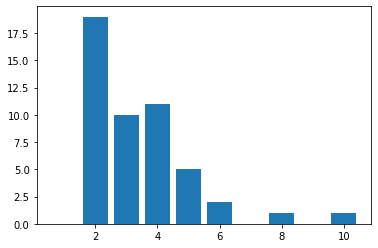

In [32]:
trim_baseline(summary_expanded_wo_why_fixed_location, "summary_expanded_wo_why_fixed_location.json")

100
Prompt: John walked to get to supermarket.<\s> John buys a gym bag from supermarket.<\s> John took a taxi to get to taxi.<\s> John paid the taxi driver at taxi<\s> John took a taxi to get to gym.<\s> John beat up the pro wrestler at gym
['John walked to get to supermarket.', 'John buys a gym bag from supermarket.', 'John took a taxi to get to taxi.', 'John paid the taxi driver at taxi.', 'John took a taxi to get to gym.', 'John beat up the pro wrestler at gym.']
[('John', 'NNP'), ('walked', 'VBD'), ('to', 'TO'), ('get', 'VB'), ('to', 'TO'), ('supermarket.', 'VB')]
[('John', 'NNP'), ('buys', 'VBZ'), ('a', 'DT'), ('gym', 'JJ'), ('bag', 'NN'), ('from', 'IN'), ('supermarket.', 'NN')]
[('John', 'NNP'), ('took', 'VBD'), ('a', 'DT'), ('taxi', 'NN'), ('to', 'TO'), ('get', 'VB'), ('to', 'TO'), ('taxi.', 'VB')]
[('John', 'NNP'), ('paid', 'VBD'), ('the', 'DT'), ('taxi', 'NN'), ('driver', 'NN'), ('at', 'IN'), ('taxi.', 'NN')]
[('John', 'NNP'), ('took', 'VBD'), ('a', 'DT'), ('taxi', 'NN'), ('to

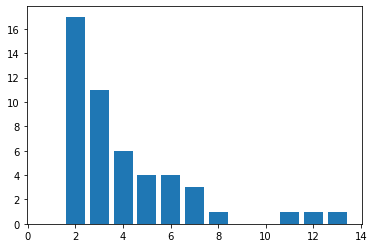

In [33]:
trim_baseline(summary_expanded_w_why_fixed_location, "summary_expanded_w_why_fixed_location.json")

87
Prompt: Sam was a high school wrestler.. Sam starts to go to college. Sam begins to graduate. Sam begins to be in school. Sam begins to talk to their parents. His coach and parents strongly convinced him to stick it out..
['Sam was a high school wrestler.', 'Sam starts to go to college.', 'Sam begins to graduate.', 'Sam begins to be in school.', 'Sam begins to talk to their parents.', 'His coach and parents strongly convinced him to stick it out.']
[('Sam', 'NNP'), ('was', 'VBD'), ('a', 'DT'), ('high', 'JJ'), ('school', 'NN'), ('wrestler.', 'NN')]
[('Sam', 'NNP'), ('starts', 'VBZ'), ('to', 'TO'), ('go', 'VB'), ('to', 'TO'), ('college.', 'VB')]
[('Sam', 'NNP'), ('begins', 'VBZ'), ('to', 'TO'), ('graduate.', 'VB')]
[('Sam', 'NNP'), ('begins', 'VBZ'), ('to', 'TO'), ('be', 'VB'), ('in', 'IN'), ('school.', 'NN')]
[('Sam', 'NNP'), ('begins', 'VBZ'), ('to', 'TO'), ('talk', 'VB'), ('to', 'TO'), ('their', 'PRP$'), ('parents.', 'NN')]
[('His', 'PRP$'), ('coach', 'NN'), ('and', 'CC'), ('parent

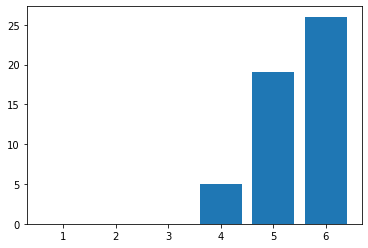

In [34]:
trim_baseline(C2PO, "C2PO_trimmed.json")

101
Prompt: Sam was a high school wrestler. He hated himself for losing. Sam liked his food and his drugs. Sam thought about quitting the wrestling team. His coach and parents strongly convinced him to stick it out.
['Sam was a high school wrestler.', 'He hated himself for losing.', 'Sam liked his food and his drugs.', 'Sam thought about quitting the wrestling team.', 'His coach and parents strongly convinced him to stick it out.']
[('Sam', 'NNP'), ('was', 'VBD'), ('a', 'DT'), ('high', 'JJ'), ('school', 'NN'), ('wrestler.', 'NN')]
[('He', 'PRP'), ('hated', 'VBD'), ('himself', 'PRP'), ('for', 'IN'), ('losing.', 'NN')]
[('Sam', 'NNP'), ('liked', 'VBD'), ('his', 'PRP$'), ('food', 'NN'), ('and', 'CC'), ('his', 'PRP$'), ('drugs.', 'NN')]
[('Sam', 'NNP'), ('thought', 'VBD'), ('about', 'IN'), ('quitting', 'VBG'), ('the', 'DT'), ('wrestling', 'NN'), ('team.', 'NN')]
[('His', 'PRP$'), ('coach', 'NN'), ('and', 'CC'), ('parents', 'NNS'), ('strongly', 'RB'), ('convinced', 'VBD'), ('him', 'PRP'), (

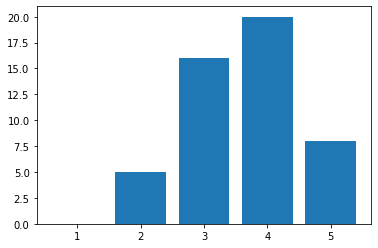

In [35]:
trim_baseline(gptj_baseline, "gptj_trimmed.json")

100
Prompt: </s> john was a great athlete . </s> he was the star of his high school team . </s> he practiced every day . </s> he tried out for the team after practicing . </s> he made the team !
['john was a great athlete.', 'he was the star of his high school team.', 'he practiced every day.', 'he tried out for the team after practicing.', 'he made the team!']
[('john', 'NN'), ('was', 'VBD'), ('a', 'DT'), ('great', 'JJ'), ('athlete.', 'NN')]
[('he', 'PRP'), ('was', 'VBD'), ('the', 'DT'), ('star', 'NN'), ('of', 'IN'), ('his', 'PRP$'), ('high', 'JJ'), ('school', 'NN'), ('team.', 'NN')]
[('he', 'PRP'), ('practiced', 'VBD'), ('every', 'DT'), ('day.', 'NN')]
[('he', 'PRP'), ('tried', 'VBD'), ('out', 'RP'), ('for', 'IN'), ('the', 'DT'), ('team', 'NN'), ('after', 'IN'), ('practicing.', 'NN')]
[('he', 'PRP'), ('made', 'VBD'), ('the', 'DT'), ('team!', 'NN')]
he practiced every day. he tried out for the team after practicing. he made the team!
Spacy [he, the team]
output  john was a great athle

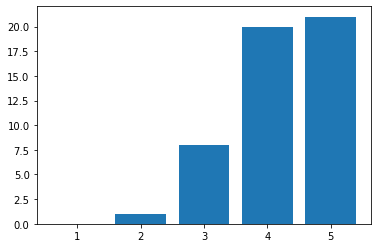

In [36]:
trim_baseline(pwr, "pwr_trimmed.json")

100
Prompt: [MALE] has been married to his wife for 20 years. he was very nervous about his upcoming reunion. he decided to go to an italian restaurant and get some food. the food was good but he could n't decide which dish he wanted. he decided to try a pork dish instead.
['[MALE] has been married to his wife for 20 years.', 'he was very nervous about his upcoming reunion.', 'he decided to go to an italian restaurant and get some food.', "the food was good but he could n't decide which dish he wanted.", 'he decided to try a pork dish instead.']
[('[MALE]', 'NN'), ('has', 'VBZ'), ('been', 'VBN'), ('married', 'VBN'), ('to', 'TO'), ('his', 'PRP$'), ('wife', 'NN'), ('for', 'IN'), ('20', 'CD'), ('years.', 'NNS')]
[('he', 'PRP'), ('was', 'VBD'), ('very', 'RB'), ('nervous', 'JJ'), ('about', 'IN'), ('his', 'PRP$'), ('upcoming', 'JJ'), ('reunion.', 'NN')]
[('he', 'PRP'), ('decided', 'VBD'), ('to', 'TO'), ('go', 'VB'), ('to', 'TO'), ('an', 'DT'), ('italian', 'JJ'), ('restaurant', 'NN'), ('and',

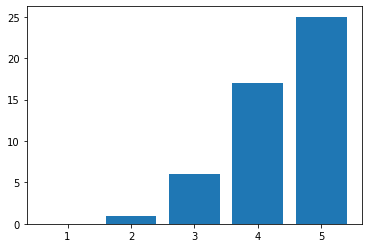

In [37]:
trim_baseline(common_sense, "cs_trimmed.json")

150
Prompt: Beth told her mother that she felt stuffed up. Her mother was greatly troubled at this. She called Beth's school and told them Beth could not attend. She employed all of the herbal remedies she had been given as a child. Beth recovered in the average time it takes for a cold to subside.
['Beth told her mother that she felt stuffed up.', 'Her mother was greatly troubled at this.', "She called Beth's school and told them Beth could not attend.", 'She employed all of the herbal remedies she had been given as a child.', 'Beth recovered in the average time it takes for a cold to subside.']
[('Beth', 'NNP'), ('told', 'VBD'), ('her', 'PRP$'), ('mother', 'NN'), ('that', 'IN'), ('she', 'PRP'), ('felt', 'VBD'), ('stuffed', 'JJ'), ('up.', 'NN')]
[('Her', 'PRP$'), ('mother', 'NN'), ('was', 'VBD'), ('greatly', 'RB'), ('troubled', 'JJ'), ('at', 'IN'), ('this.', 'NN')]
[('She', 'PRP'), ('called', 'VBD'), ("Beth's", 'NNP'), ('school', 'NN'), ('and', 'CC'), ('told', 'VBD'), ('them', 'PRP'),

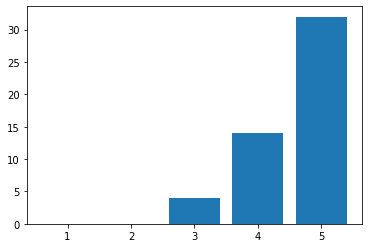

In [38]:
trim_baseline(ROC, "ROC.json")